In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [6]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [7]:
plt.rcParams.update({'font.size': 20})

In [8]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
red_thresh = get_closest_match(values=threshold, target=1.6)
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'

In [14]:
def load_mean_params():
    ising_model_file = os.path.join(file_dir, f'ising_model_{param_string}.pt')
    model = torch.load(ising_model_file, weights_only=False)
    print(f'loaded {ising_model_file}')
    print( 'h size', model.h.size() )
    print( 'J size', model.J.size() )
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=model.J.size(dim=-1), device=model.J.device )
    return model.h.mean(dim=0), model.J[:,:,triu_rows,triu_cols].mean(dim=0)
h, J = load_mean_params()
print( 'h reduced to', h.size() )
print( 'J reduced to', J.size() )

loaded E:\Ising_model_results_daai\ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt
h size torch.Size([101, 31, 360])
J size torch.Size([101, 31, 360, 360])
h reduced to torch.Size([31, 360])
J reduced to torch.Size([31, 64620])


In [11]:
mean_node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False ).mean(dim=0)[:,:4]
print( 'node features size', mean_node_features.size() )
mean_sc = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False ).mean(dim=0)[:,0]
print( 'SC size', mean_sc.size() )

node features size torch.Size([360, 4])
SC size torch.Size([64620])


In [12]:
def get_group_fc():
    mean_state = torch.load( os.path.join(file_dir, f'mean_state_{data_string}.pt'), weights_only=False )
    print( 'mean state size', mean_state.size() )
    mean_state_product = torch.load( os.path.join(file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )
    print( 'mean state product size', mean_state_product.size() )
    group_fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=group_fc.size(dim=-1), device=group_fc.device )
    return group_fc[:,triu_rows,triu_cols]
group_fc = get_group_fc()
print( 'group FC size', group_fc.size() )

mean state size torch.Size([31, 360])
mean state product size torch.Size([31, 360, 360])
group FC size torch.Size([31, 64620])


In [13]:
h_node_corr = isingmodellight.get_pairwise_correlation( mat1=h.unsqueeze(dim=-1), mat2=mean_node_features.unsqueeze(dim=0), epsilon=0, dim=1 )
print( h_node_corr.size() )

torch.Size([31, 4])


In [14]:
max_h_node_corr, max_h_node_corr_index = h_node_corr.abs().max(dim=0)
print( threshold[max_h_node_corr_index] )
print( h_node_corr[max_h_node_corr_index,range(4)] )

tensor([2.1000, 2.1000, 2.3000, 1.6000], device='cuda:0')
tensor([-0.3604,  0.5270, -0.2127, -0.2869], device='cuda:0')


In [30]:
h_node_corr_file = os.path.join(file_dir, f'h_node_corr_{param_string}.pt')
torch.save(obj=h_node_corr, f=h_node_corr_file)
print(f'saved {h_node_corr_file}')

saved E:\Ising_model_results_daai\h_node_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt


In [15]:
J_sc_corr = isingmodellight.get_pairwise_correlation( mat1=J, mat2=mean_sc.unsqueeze(dim=0), epsilon=0, dim=1 )
print( J_sc_corr.size() )

torch.Size([31])


In [29]:
J_sc_corr_file = os.path.join(file_dir, f'J_sc_corr_{param_string}.pt')
torch.save(obj=J_sc_corr, f=J_sc_corr_file)
print(f'saved {J_sc_corr_file}')

saved E:\Ising_model_results_daai\J_sc_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt


In [16]:
fc_sc_corr = isingmodellight.get_pairwise_correlation( mat1=group_fc, mat2=mean_sc.unsqueeze(dim=0), epsilon=0, dim=1 )
print( fc_sc_corr.size() )

torch.Size([31])


In [28]:
fc_sc_corr_file = os.path.join(file_dir, f'fc_sc_corr_{param_string}.pt')
torch.save(obj=fc_sc_corr, f=fc_sc_corr_file)
print(f'saved {fc_sc_corr_file}')

saved E:\Ising_model_results_daai\fc_sc_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt


In [17]:
adjusted_alpha = 0.05/(2 * num_threshold)
print(f'group-level correlation adjusted alpha = {adjusted_alpha:.3g}')

group-level correlation adjusted alpha = 0.000806


In [18]:
num_thresholds, num_features = h_node_corr.size()
num_nodes = h.size(dim=-1)
num_permutations = 1000000
h_node_corr_permutations = torch.zeros( size=(num_permutations, num_thresholds, num_features), dtype=h_node_corr.dtype, device=h_node_corr.device )
print( 'h_node_corr_permutations', h_node_corr_permutations.size() )
h_unsqueezed = h.unsqueeze(dim=-1)
print( 'h_unsqueezed', h_unsqueezed.size() )
node_features_unsqueezed = mean_node_features.unsqueeze(dim=0)
print( 'node_features_unsqueezed', node_features_unsqueezed.size() )
for permutation_index in range(num_permutations):
    permutation = torch.randperm(n=num_nodes, dtype=int_type, device=h_unsqueezed.device)
    # print( 'permutation', permutation.size() )
    h_node_corr_permutations[permutation_index,:,:] = isingmodellight.get_pairwise_correlation( mat1=h_unsqueezed[:,permutation,:], mat2=node_features_unsqueezed, epsilon=0, dim=1 )
h_node_corr_critical = torch.quantile( input=h_node_corr_permutations.abs(), q=1.0-adjusted_alpha, dim=0 )
print( h_node_corr_critical.size() )
print( h_node_corr_critical )

h_node_corr_permutations torch.Size([1000000, 31, 4])
h_unsqueezed torch.Size([31, 360, 1])
node_features_unsqueezed torch.Size([1, 360, 4])
torch.Size([31, 4])
tensor([[0.1755, 0.1750, 0.1757, 0.1749],
        [0.1755, 0.1749, 0.1749, 0.1744],
        [0.1748, 0.1744, 0.1753, 0.1749],
        [0.1746, 0.1750, 0.1748, 0.1744],
        [0.1744, 0.1747, 0.1750, 0.1745],
        [0.1746, 0.1752, 0.1747, 0.1745],
        [0.1746, 0.1753, 0.1747, 0.1742],
        [0.1749, 0.1753, 0.1752, 0.1744],
        [0.1751, 0.1752, 0.1750, 0.1743],
        [0.1751, 0.1757, 0.1751, 0.1744],
        [0.1753, 0.1753, 0.1750, 0.1749],
        [0.1751, 0.1751, 0.1747, 0.1748],
        [0.1757, 0.1748, 0.1747, 0.1746],
        [0.1758, 0.1750, 0.1748, 0.1747],
        [0.1759, 0.1746, 0.1751, 0.1751],
        [0.1754, 0.1743, 0.1749, 0.1748],
        [0.1758, 0.1747, 0.1754, 0.1754],
        [0.1754, 0.1744, 0.1754, 0.1751],
        [0.1753, 0.1748, 0.1756, 0.1752],
        [0.1753, 0.1744, 0.1755, 0.1748],

In [19]:
# adjusted_alpha = 0.05/(2 * num_thresholds)#  * num_features
# print(f'adjusted alpha {adjusted_alpha:.3g}')
# h_node_corr_critical = torch.quantile( input=h_node_corr_permutations.abs(), q=1-adjusted_alpha, dim=0 )
h_node_corr_critical_min = h_node_corr_critical.min()
h_node_corr_critical_max = h_node_corr_critical.max()
print([h_node_corr_critical_min.item(), h_node_corr_critical_max.item()])

[0.17389321327209473, 0.17669451236724854]


In [20]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names)
for feature_index in range(num_features):
    print(feature_names[feature_index])
    print('threshold, corr, crit abs corr')
    for threshold_index in range( threshold.numel() ):
        print(f'{threshold[threshold_index]:.3g}, {h_node_corr[threshold_index,feature_index]:.3g}, {h_node_corr_critical[threshold_index,feature_index]:.3g}')
    # print( torch.stack([ h_node_corr[:,feature_index], h_node_corr_critical[:,feature_index] ], dim=1) )

thickness
threshold, corr, crit abs corr
0, -0.0992, 0.176
0.1, -0.113, 0.175
0.2, -0.1, 0.175
0.3, -0.1, 0.175
0.4, -0.103, 0.174
0.5, -0.109, 0.175
0.6, -0.122, 0.175
0.7, -0.131, 0.175
0.8, -0.143, 0.175
0.9, -0.156, 0.175
1, -0.195, 0.175
1.1, -0.24, 0.175
1.2, -0.263, 0.176
1.3, -0.261, 0.176
1.4, -0.276, 0.176
1.5, -0.304, 0.175
1.6, -0.322, 0.176
1.7, -0.306, 0.175
1.8, -0.275, 0.175
1.9, -0.311, 0.175
2, -0.35, 0.175
2.1, -0.36, 0.176
2.2, -0.352, 0.176
2.3, -0.339, 0.176
2.4, -0.339, 0.176
2.5, -0.317, 0.176
2.6, -0.302, 0.177
2.7, -0.299, 0.176
2.8, -0.269, 0.177
2.9, -0.228, 0.177
3, -0.213, 0.177
myelination
threshold, corr, crit abs corr
0, 0.0391, 0.175
0.1, 0.0989, 0.175
0.2, 0.105, 0.174
0.3, 0.113, 0.175
0.4, 0.124, 0.175
0.5, 0.139, 0.175
0.6, 0.162, 0.175
0.7, 0.182, 0.175
0.8, 0.21, 0.175
0.9, 0.242, 0.176
1, 0.326, 0.175
1.1, 0.394, 0.175
1.2, 0.416, 0.175
1.3, 0.404, 0.175
1.4, 0.43, 0.175
1.5, 0.485, 0.174
1.6, 0.505, 0.175
1.7, 0.465, 0.174
1.8, 0.406, 0.175
1.9

In [32]:
h_node_corr_critical_file = os.path.join(file_dir, f'h_node_corr_critical_{param_string}_adj_alpha_{adjusted_alpha:.3g}.pt')
torch.save(obj=h_node_corr_critical, f=h_node_corr_critical_file)
print(f'saved {h_node_corr_critical_file}')

saved E:\Ising_model_results_daai\h_node_corr_critical_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_adj_alpha_0.000806.pt


In [21]:
num_thresholds = J_sc_corr.size(dim=-1)
num_edges = J.size(dim=-1)
num_permutations = 1000000# 100 * 20 * 2 * num_threshold
print(f'num_permutations={num_permutations}')
J_sc_corr_permutations = torch.zeros( size=(num_permutations, num_thresholds), dtype=J_sc_corr.dtype, device=J_sc_corr.device )
print( 'J_sc_corr_permutations', J_sc_corr_permutations.size() )
sc_unsqueezed = mean_sc.unsqueeze(dim=0)
print( 'sc_unsqueezed', sc_unsqueezed.size() )
for permutation_index in range(num_permutations):
    permutation = torch.randperm(n=num_edges, dtype=int_type, device=sc_unsqueezed.device)
    # print( 'permutation', permutation.size() )
    J_sc_corr_permutations[permutation_index,:] = isingmodellight.get_pairwise_correlation( mat1=J, mat2=sc_unsqueezed[:,permutation], epsilon=0, dim=1 )
J_sc_corr_critical = torch.quantile( input=J_sc_corr_permutations.abs(), q=1-adjusted_alpha, dim=0 )
print( J_sc_corr_critical.size() )
J_sc_corr_critical_min = J_sc_corr_critical.min()
J_sc_corr_critical_max = J_sc_corr_critical.max()
print(J_sc_corr_critical)
print([J_sc_corr_critical_min.item(), J_sc_corr_critical_max.item()])

num_permutations=1000000
J_sc_corr_permutations torch.Size([1000000, 31])
sc_unsqueezed torch.Size([1, 64620])
torch.Size([31])
tensor([0.0137, 0.0137, 0.0137, 0.0137, 0.0137, 0.0136, 0.0135, 0.0135, 0.0134,
        0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0133, 0.0133,
        0.0133, 0.0133, 0.0133, 0.0133, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132,
        0.0133, 0.0133, 0.0133, 0.0133], device='cuda:0')
[0.013228164054453373, 0.013717707246541977]


In [22]:
print(  torch.stack( (J_sc_corr, J_sc_corr_critical), dim=1 )  )

tensor([[0.6087, 0.0137],
        [0.6087, 0.0137],
        [0.6043, 0.0137],
        [0.5989, 0.0137],
        [0.5920, 0.0137],
        [0.5840, 0.0136],
        [0.5702, 0.0135],
        [0.5585, 0.0135],
        [0.5427, 0.0134],
        [0.5256, 0.0134],
        [0.5133, 0.0134],
        [0.4960, 0.0134],
        [0.4774, 0.0134],
        [0.4638, 0.0134],
        [0.4505, 0.0134],
        [0.4442, 0.0134],
        [0.4293, 0.0133],
        [0.4152, 0.0133],
        [0.4052, 0.0133],
        [0.3950, 0.0133],
        [0.3848, 0.0133],
        [0.3734, 0.0133],
        [0.3775, 0.0132],
        [0.3818, 0.0132],
        [0.3859, 0.0132],
        [0.3900, 0.0132],
        [0.3939, 0.0132],
        [0.3976, 0.0133],
        [0.4011, 0.0133],
        [0.4031, 0.0133],
        [0.4020, 0.0133]], device='cuda:0')


In [33]:
J_sc_corr_critical_file = os.path.join(file_dir, f'J_sc_corr_critical_{param_string}_adj_alpha_{adjusted_alpha:.3g}.pt')
torch.save(obj=J_sc_corr_critical, f=J_sc_corr_critical_file)
print(f'saved {J_sc_corr_critical_file}')

saved E:\Ising_model_results_daai\J_sc_corr_critical_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_adj_alpha_0.000806.pt


In [23]:
num_thresholds = fc_sc_corr.size(dim=-1)
num_edges = group_fc.size(dim=-1)
num_permutations = 1000000# 100 * 20 * 2 * num_threshold
fc_sc_corr_permutations = torch.zeros( size=(num_permutations, num_thresholds), dtype=fc_sc_corr.dtype, device=fc_sc_corr.device )
print( 'fc_sc_corr_permutations', fc_sc_corr_permutations.size() )
sc_unsqueezed = mean_sc.unsqueeze(dim=0)
print( 'sc_unsqueezed', sc_unsqueezed.size() )
for permutation_index in range(num_permutations):
    permutation = torch.randperm(n=num_edges, dtype=int_type, device=sc_unsqueezed.device)
    # print( 'permutation', permutation.size() )
    fc_sc_corr_permutations[permutation_index,:] = isingmodellight.get_pairwise_correlation( mat1=group_fc, mat2=sc_unsqueezed[:,permutation], epsilon=0, dim=1 )
fc_sc_corr_critical = torch.quantile( input=fc_sc_corr_permutations.abs(), q=1-adjusted_alpha, dim=0 )
print( fc_sc_corr_critical.size() )
fc_sc_corr_critical_min = fc_sc_corr_critical.min()
fc_sc_corr_critical_max = fc_sc_corr_critical.max()
print(fc_sc_corr_critical)
print([fc_sc_corr_critical_min.item(), fc_sc_corr_critical_max.item()])

fc_sc_corr_permutations torch.Size([1000000, 31])
sc_unsqueezed torch.Size([1, 64620])
torch.Size([31])
tensor([0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132,
        0.0132, 0.0132, 0.0132, 0.0133, 0.0132, 0.0132, 0.0133, 0.0132, 0.0132,
        0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133,
        0.0133, 0.0133, 0.0133, 0.0133], device='cuda:0')
[0.01322379894554615, 0.013347032479941845]


In [24]:
print(  torch.stack( (fc_sc_corr, fc_sc_corr_critical), dim=1 )  )

tensor([[0.2640, 0.0132],
        [0.2643, 0.0132],
        [0.2648, 0.0132],
        [0.2654, 0.0132],
        [0.2662, 0.0132],
        [0.2672, 0.0132],
        [0.2684, 0.0132],
        [0.2699, 0.0132],
        [0.2715, 0.0132],
        [0.2734, 0.0132],
        [0.2755, 0.0132],
        [0.2778, 0.0132],
        [0.2802, 0.0133],
        [0.2829, 0.0132],
        [0.2857, 0.0132],
        [0.2887, 0.0133],
        [0.2920, 0.0132],
        [0.2955, 0.0132],
        [0.2992, 0.0133],
        [0.3030, 0.0133],
        [0.3070, 0.0133],
        [0.3114, 0.0133],
        [0.3161, 0.0133],
        [0.3213, 0.0133],
        [0.3269, 0.0133],
        [0.3330, 0.0133],
        [0.3394, 0.0133],
        [0.3465, 0.0133],
        [0.3540, 0.0133],
        [0.3618, 0.0133],
        [0.3696, 0.0133]], device='cuda:0')


In [34]:
fc_sc_corr_critical_file = os.path.join(file_dir, f'fc_sc_corr_critical_{param_string}_adj_alpha_{adjusted_alpha:.3g}.pt')
torch.save(obj=fc_sc_corr_critical, f=fc_sc_corr_critical_file)
print(f'saved {fc_sc_corr_critical_file}')

saved E:\Ising_model_results_daai\fc_sc_corr_critical_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_adj_alpha_0.000806.pt


In [25]:
brightness = 0.85
thickness_color = [brightness,0.0,0.0]
myelination_color = [0.0,brightness,0.0]
curvature_color = [0.0,0.0,brightness]
sulcus_depth_color = [brightness,0.0,brightness]
j_color = [brightness,brightness,0.0]
fc_color = [0.0,brightness,brightness]
crit_color = 'black'

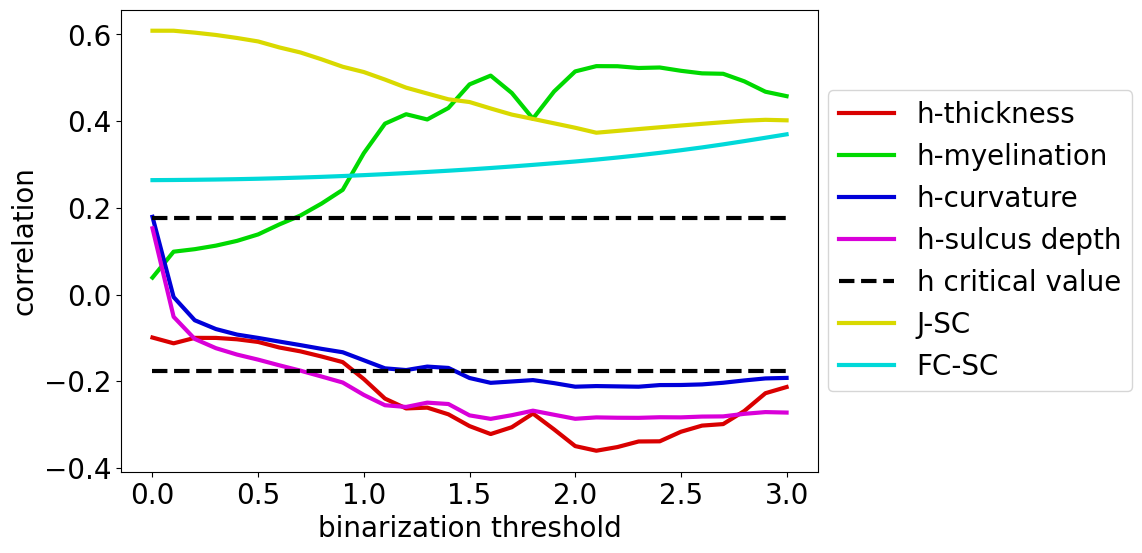

In [26]:
threshold_np = depytorch(threshold)
h_node_corr_np = depytorch(h_node_corr)
J_sc_corr_np = depytorch(J_sc_corr)
fc_sc_corr_np = depytorch(fc_sc_corr)
horizontal_crit_np = depytorch( torch.full_like(input=threshold, fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h-{feature_name}', color=feature_color, linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color=fc_color, linewidth=line_width)
axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

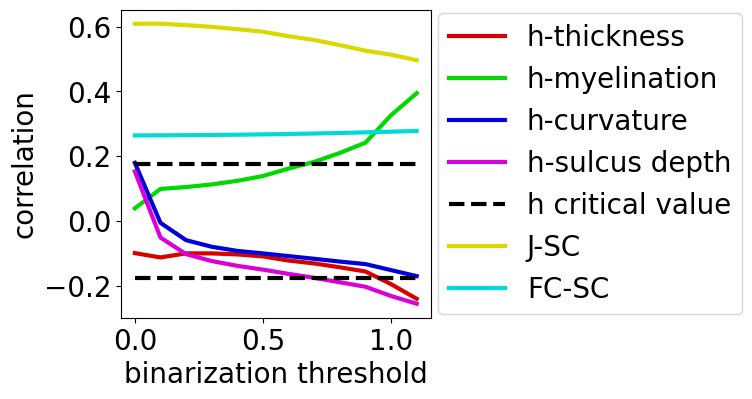

In [94]:
max_threshold = 1.1
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
J_sc_corr_np = depytorch(J_sc_corr[:max_thresh_index])
fc_sc_corr_np = depytorch(fc_sc_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h-{feature_name}', color=feature_color, linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color=fc_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

In [ ]:
num_thresholds, num_nodes = h.size()
num_features = mean_node_features.size(dim=-1)
ones_for_nodes = torch.ones( size=(num_nodes,1), dtype=mean_node_features.dtype, device=mean_node_features.device )
node_features_and_1 = torch.cat( (mean_node_features,ones_for_nodes), dim=-1 )
feature_coeffs = torch.zeros( size=(num_thresholds, num_features), dtype=mean_node_features.dtype, device=mean_node_features.device )
h_pred = torch.zeros_like(h)
for threshold_index in range(num_thresholds):
    h_for_threshold = h[threshold_index,:]
    regression = torch.linalg.lstsq( node_features_and_1, h_for_threshold.unsqueeze(dim=-1) )
    print(f'threshold={threshold[threshold_index]:.3g}', regression)
    feature_coeffs[threshold_index,:] = regression.solution.squeeze(dim=-1)
    h_pred = torch.matmul(node_features_and_1, regression.solution).squeeze(dim=-1)
h_pred_corr = isingmodellight.get_pairwise_correlation( mat1=h, mat2=h_pred, epsilon=0, dim=-1 )
print('linear regression coefficients')
pred(feature_coeffs)
print('correlation between fitted and predicted h')
print(h_pred_corr)

In [8]:
data_string = 'all_mean_std_1'
param_string = f'{data_string}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000'

In [69]:
data_string = 'all_mean_std_0'
param_string = f'{data_string}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000'

In [12]:
def load_mean_params(param_string:str):
    model_file = os.path.join( other_file_dir, f'ising_model_light_{param_string}.pt' )
    model = torch.load(model_file, weights_only=False)
    num_nodes = model.J.size(dim=-1)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=model.J.device )
    return model.h.mean(dim=0), model.J[:,:,triu_rows,triu_cols].mean(dim=0)
h, J = load_mean_params(param_string=param_string)
print( 'h size', h.size() )
print( 'J size', J.size() )

NameError: name 'param_string' is not defined

In [10]:
node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )[:,:,:4]
print( 'node features size', node_features.size() )
sc = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[:,:,0].clone()# so we can drop the others from memory.
print( 'SC size', sc.size() )

node features size torch.Size([837, 360, 4])
SC size torch.Size([837, 64620])


In [104]:
def get_data_fc_triu(data_string:str):
    mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_{data_string}.pt'), weights_only=False ).mean(dim=0)
    print( 'mean state size', mean_state.size() )
    mean_state_product = torch.load( os.path.join(other_file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False ).mean(dim=0)
    print( 'mean state product size', mean_state_product.size() )
    fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
    print( 'fc size', fc.size() )
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=mean_state.size(dim=-1), device=mean_state.device )
    return fc[:,triu_rows,triu_cols]
fc = get_data_fc_triu(data_string=data_string)
print( 'triu fc size', fc.size() )

mean state size torch.Size([837, 360])
mean state product size torch.Size([837, 360, 360])
fc size torch.Size([837, 360, 360])
triu fc size torch.Size([837, 64620])


In [24]:
h_node_corr = isingmodellight.get_pairwise_correlation( mat1=h.unsqueeze(dim=-1), mat2=node_features, epsilon=0, dim=0 )
print( h_node_corr.size() )

torch.Size([360, 4])


In [25]:
J_sc_corr = isingmodellight.get_pairwise_correlation( mat1=J, mat2=sc, epsilon=0, dim=0 )
print( J_sc_corr.size() )

torch.Size([64620])


In [26]:
fc_sc_corr = isingmodellight.get_pairwise_correlation( mat1=fc, mat2=sc, epsilon=0, dim=0 )
print( fc_sc_corr.size() )

torch.Size([64620])


In [27]:
num_nodes, num_features = h_node_corr.size()
adjusted_alpha = 0.05/(2 * num_nodes * num_features)
print(f'adjusted alpha for node correlations = {adjusted_alpha:.3g}')

adjusted alpha for node correlations = 1.74e-05


In [21]:
num_subjects = h.size(dim=0)
num_permutations = 1000000
print(f'num_permutations {num_permutations}')
h_node_corr_permutations = torch.zeros( size=(num_permutations, num_nodes), dtype=h_node_corr.dtype, device=h_node_corr.device )
h_node_corr_critical = torch.zeros_like(h_node_corr)
for feature_index in range(num_features):
    node_feature = node_features[:,:,feature_index]
    for permutation_index in range(num_permutations):
        permutation = torch.randperm(n=num_subjects, dtype=int_type, device=h.device)
        h_node_corr_permutations[permutation_index,:] = isingmodellight.get_pairwise_correlation( mat1=h[permutation,:], mat2=node_feature, epsilon=0, dim=0 )
    h_node_corr_critical[:,feature_index] = torch.quantile( input=h_node_corr_permutations.abs(), q=1-adjusted_alpha, dim=0 )
print( 'h_node_corr_critical', h_node_corr_critical.size() )
h_node_corr_critical_min = h_node_corr_critical.min()
h_node_corr_critical_max = h_node_corr_critical.max()
print([h_node_corr_critical_min.item(), h_node_corr_critical_max.item()])

num_permutations 1000000


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.68 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 10.01 GiB is allocated by PyTorch, and 2.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [28]:
num_edges = J_sc_corr.size(dim=0)
adjusted_alpha = 0.05/(2 * num_edges)
print(f'adjusted alpha for J-SC correlations = {adjusted_alpha:.3g}')

adjusted alpha for J-SC correlations = 3.87e-07


In [ ]:
num_subjects = J.size(dim=0)
num_permutations = 100
print(f'num_permutations {num_permutations}')
J_sc_corr_permutations = torch.zeros( size=(num_permutations, num_edges), dtype=J_sc_corr.dtype, device=J_sc_corr.device )
for permutation_index in range(num_permutations):
    permutation = torch.randperm(n=num_subjects, dtype=int_type, device=J.device)
    J_sc_corr_permutations[permutation_index,:] = isingmodellight.get_pairwise_correlation( mat1=J[permutation,:], mat2=sc, epsilon=0, dim=0 )
J_sc_corr_critical = torch.quantile( input=J_sc_corr_permutations.abs(), q=1-adjusted_alpha, dim=0 )
print( 'J_sc_corr_critical', J_sc_corr_critical.size() )
h_node_corr_critical_min = h_node_corr_critical.min()
h_node_corr_critical_max = h_node_corr_critical.max()
print([h_node_corr_critical_min.item(), h_node_corr_critical_max.item()])

In [37]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
h_node_feature_corrs = [ depytorch(  torch.load( os.path.join(file_dir, f'h_{feature_name}_corr_{param_string}.pt'), weights_only=False )  ) for feature_name in feature_names_file ]

In [38]:
h_node_feature_crit_corrs = [ depytorch(  torch.load( os.path.join(file_dir, f'h_{feature_name}_corr_critical_{param_string}_perms_1440000_alpha_3.47e-06.pt'), weights_only=False )  ) for feature_name in feature_names_file ]

In [39]:
h_node_feature_corr_tensor = torch.stack( [ torch.load( os.path.join(file_dir, f'h_{feature_name}_corr_{param_string}.pt'), weights_only=False ) for feature_name in feature_names_file ], dim=-1 )
print( h_node_feature_corr_tensor.size() )
print( h_node_feature_corr_tensor.min(dim=0).values.tolist() )
print( h_node_feature_corr_tensor.max(dim=0).values.tolist() )

torch.Size([360, 4])
[-0.09553171694278717, -0.25057339668273926, -0.21719856560230255, -0.1988789141178131]
[0.18346591293811798, 0.4516258239746094, 0.41524431109428406, 0.3820495903491974]


In [40]:
h_node_feature_crit_corr_tensor = torch.stack( [ torch.load( os.path.join(file_dir, f'h_{feature_name}_corr_critical_{param_string}_perms_1440000_alpha_3.47e-06.pt'), weights_only=False ) for feature_name in feature_names_file ], dim=-1 )
print( h_node_feature_crit_corr_tensor.size() )
print( h_node_feature_crit_corr_tensor.min(dim=0).values.tolist() )
print( h_node_feature_crit_corr_tensor.max(dim=0).values.tolist() )

torch.Size([360, 4])
[0.13396400213241577, 0.1280248761177063, 0.1345301866531372, 0.13449707627296448]
[0.1391191929578781, 0.18258430063724518, 0.13956794142723083, 0.1399543434381485]


In [109]:
h_node_num_significant = torch.count_nonzero( h_node_feature_corr_tensor.abs() > h_node_feature_crit_corr_tensor, dim=0 )
print(h_node_num_significant)
h_node_fraction_significant = h_node_num_significant/h_node_feature_corr_tensor.size(dim=0)
print(h_node_fraction_significant)

tensor([10, 29, 52, 43], device='cuda:0')
tensor([0.0278, 0.0806, 0.1444, 0.1194], device='cuda:0')


In [110]:
min_h_node_feature_crit_corr_tensor = h_node_feature_crit_corr_tensor.min(dim=0).values

In [111]:
max_h_node_feature_crit_corr_tensor = h_node_feature_crit_corr_tensor.max(dim=0).values

In [41]:
J_sc_corr = torch.load( os.path.join(file_dir, f'J_sc_corr_{param_string}.pt'), weights_only=False )
print( J_sc_corr.size() )

torch.Size([64620])


In [42]:
print( J_sc_corr.min().item(), J_sc_corr.max().item() )

-0.16584938764572144 0.4035748243331909


In [43]:
J_sc_crit_corr_file = os.path.join(file_dir, f'J_sc_corr_critical_{param_string}_perms_258480000_alpha_1.93e-08.pt')
J_sc_crit_corr = torch.load( J_sc_crit_corr_file, weights_only=False )
print(f'loaded {J_sc_crit_corr_file}')
print( J_sc_crit_corr.size() )
J_sc_crit_corr_max = J_sc_crit_corr.max().item()
print( J_sc_crit_corr.min().item(), J_sc_crit_corr_max)

loaded E:\Ising_model_results_daai\J_sc_corr_critical_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_perms_258480000_alpha_1.93e-08.pt
torch.Size([64620])
0.11975764483213425 0.27913475036621094


In [115]:
fc_sc_corr = torch.load( os.path.join(file_dir, f'fc_sc_corr_{param_string}.pt'), weights_only=False )
print( fc_sc_corr.size() )

torch.Size([64620])


In [116]:
print( fc_sc_corr.min().item(), fc_sc_corr.max().item() )

-0.16267110407352448 0.2872951328754425


In [117]:
fc_sc_crit_corr = torch.load( os.path.join(file_dir, f'fc_sc_corr_critical_{param_string}_perms_258480000_alpha_1.93e-08.pt'), weights_only=False )
print( fc_sc_crit_corr.size() )
fc_sc_crit_corr_max = fc_sc_crit_corr.max().item()
print( fc_sc_crit_corr.min().item(), fc_sc_crit_corr_max)

torch.Size([64620])
0.10967307537794113 0.24348752200603485


In [118]:
J_sc_num_significant = torch.count_nonzero( J_sc_corr.abs() > J_sc_crit_corr )
J_sc_fraction_significant = J_sc_num_significant/J_sc_corr.numel()
print( 'significant J-sc correlations: ', J_sc_num_significant, J_sc_fraction_significant )
fc_sc_num_significant = torch.count_nonzero( fc_sc_corr.abs() > fc_sc_crit_corr )
fc_sc_fraction_significant = fc_sc_num_significant/fc_sc_corr.numel()
print( 'significant fc-sc correlations: ', fc_sc_num_significant, fc_sc_fraction_significant )

significant J-sc correlations:  tensor(221, device='cuda:0') tensor(0.0034, device='cuda:0')
significant fc-sc correlations:  tensor(92, device='cuda:0') tensor(0.0014, device='cuda:0')


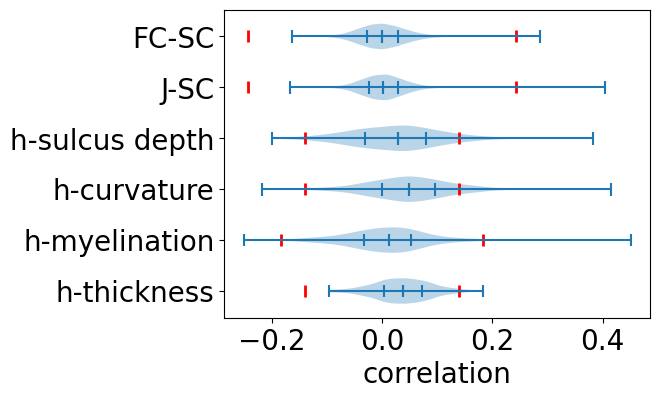

In [134]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = h_node_feature_corrs + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
axs.scatter( all_max_crit_corrs, label_x, color='red', marker='|', linewidth=2, s=80 )
axs.scatter( [-cc for cc in all_max_crit_corrs], label_x, color='red', marker='|', linewidth=2, s=80 )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.set_xlabel('correlation')
plt.show()

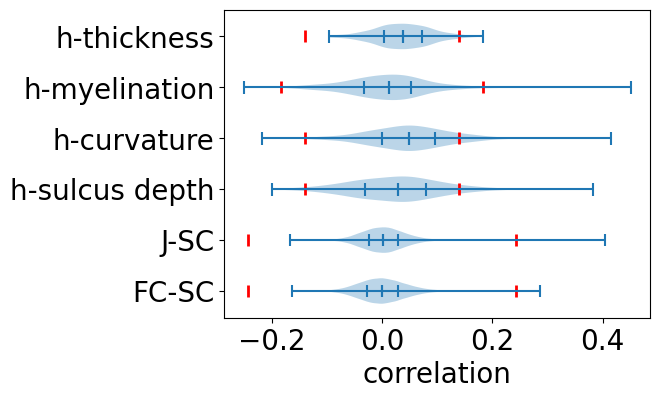

In [136]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = h_node_feature_corrs + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [11]:
names, coords = hcp.load_roi_info( directory_path='D:\\HCP_data', dtype=float_type, device=device )
print( len(names) )

360


In [26]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
h_node_corr_tensor_abs = h_node_feature_corr_tensor.abs()
h_node_is_signifcant = h_node_corr_tensor_abs > h_node_feature_crit_corr_tensor
num_features = h_node_is_signifcant.size(dim=1)
for feature_index in range(num_features):
    is_sig = h_node_is_signifcant[:,feature_index]
    sig_abs, sig_abs_indices = h_node_corr_tensor_abs[is_sig,feature_index].sort(descending=True)
    sig_corr = (h_node_feature_corr_tensor[is_sig,feature_index])[sig_abs_indices]
    sig_region = (names[depytorch(is_sig)])[depytorch(sig_abs_indices)]
    print('')
    print(f'h_i-{feature_names[feature_index]}')
    num_sig = len(sig_region)
    for n, r, c in zip( range(num_sig), sig_region, sig_corr ):
        print(f'{n+1}. {r}, {c:.3g}')


h_i-thickness
1. R_PH, 0.183
2. R_PIT, 0.167
3. R_33pr, 0.162
4. R_Pir, 0.157
5. R_PoI1, 0.153
6. L_STSvp, 0.143
7. R_10v, 0.142
8. L_p24, 0.139
9. L_Pir, 0.139
10. L_H, 0.137

h_i-myelination
1. L_PEF, 0.452
2. R_PEF, 0.318
3. L_PH, -0.251
4. L_55b, 0.25
5. L_IFJa, 0.248
6. L_FFC, -0.242
7. L_10pp, 0.239
8. R_LIPv, 0.225
9. L_47l, 0.219
10. L_IFJp, 0.206
11. L_LIPv, 0.196
12. L_A1, -0.181
13. L_PreS, 0.18
14. R_47l, 0.179
15. L_TE1p, -0.178
16. R_IFJp, 0.169
17. L_47m, 0.168
18. R_IFSp, 0.167
19. R_FFC, -0.157
20. R_POS2, -0.153
21. R_8C, 0.151
22. R_7Pm, -0.151
23. R_V3B, 0.146
24. L_FEF, 0.144
25. L_STSdp, -0.144
26. L_52, 0.142
27. R_FOP5, 0.138
28. L_31a, -0.137
29. L_10v, 0.137

h_i-curvature
1. R_PH, 0.415
2. L_FFC, 0.37
3. L_V8, 0.363
4. L_PH, 0.326
5. R_PIT, 0.308
6. R_V8, 0.278
7. L_PIT, 0.25
8. R_FST, 0.24
9. R_7Pm, 0.225
10. R_FFC, 0.224
11. R_10v, -0.217
12. L_TF, -0.214
13. L_FST, 0.208
14. R_TF, -0.203
15. R_TPOJ2, 0.197
16. L_p32pr, 0.195
17. R_V4t, 0.195
18. L_PHA3, 0

In [27]:
triu_row, triu_col = isingmodellight.get_triu_indices_for_products( num_nodes=len(names), device=device )
r1_names = names[depytorch(triu_row)]
r2_names = names[depytorch(triu_col)]

In [28]:
for label, corr, crit in zip(['J', 'FC'],[J_sc_corr, fc_sc_corr],[J_sc_crit_corr, fc_sc_crit_corr]):
    abs_corr = corr.abs()
    is_sig = abs_corr > crit
    sig_abs_corr, sig_abs_corr_indices = abs_corr[is_sig].sort(descending=True)
    sig_corr = (corr[is_sig])[sig_abs_corr_indices]
    is_sig_np = depytorch(is_sig)
    sig_abs_corr_indices_np = depytorch(sig_abs_corr_indices)
    sig_r1 = (r1_names[is_sig_np])[sig_abs_corr_indices_np]
    sig_r2 = (r2_names[is_sig_np])[sig_abs_corr_indices_np]
    num_sig = len(sig_r1)
    print(f'{label}-SC')
    for n, r1, r2, c in zip( range(num_sig), sig_r1, sig_r2, sig_corr ):
        print(f'{n+1}. {r1}, {r2}, {c:.3g}')

J-SC
1. R_STSvp, R_TPOJ1, 0.404
2. R_PHT, R_TPOJ2, 0.389
3. L_PHT, L_TPOJ2, 0.376
4. L_PHT, L_PH, 0.365
5. L_MIP, L_IP1, 0.363
6. L_d32, L_a32pr, 0.338
7. R_PSL, R_STV, 0.334
8. R_3b, R_1, 0.334
9. L_8C, L_44, 0.332
10. R_MIP, R_IP1, 0.322
11. L_IP1, L_PFm, 0.321
12. L_TPOJ1, L_PGi, 0.32
13. L_3b, L_1, 0.32
14. R_FEF, R_55b, 0.31
15. R_44, R_6r, 0.306
16. L_45, L_47l, 0.301
17. R_8Av, R_i6-8, 0.3
18. R_IFSa, R_p47r, 0.299
19. L_MIP, L_V3CD, 0.292
20. R_V4t, R_LO3, 0.291
21. L_d32, L_p24, 0.288
22. L_45, L_p47r, 0.286
23. R_POS2, R_7m, 0.284
24. R_IFJa, R_IFSp, 0.284
25. R_PH, R_FST, 0.284
26. L_STV, L_TPOJ1, 0.278
27. R_8C, R_IP2, 0.275
28. L_6a, L_i6-8, 0.273
29. L_24dv, L_p24pr, 0.268
30. R_47l, R_FOP5, 0.266
31. R_IFJa, R_IFJp, 0.266
32. R_AIP, R_IP2, 0.265
33. L_STSvp, L_TE1m, 0.263
34. L_8Av, L_IFJa, 0.262
35. R_LO1, R_V3CD, 0.26
36. R_TE1a, R_TE2a, 0.258
37. L_IFJa, L_p47r, 0.257
38. R_V3B, R_V3CD, 0.255
39. R_PEF, R_IFJp, 0.254
40. R_FFC, R_PH, 0.254
41. L_6v, L_6r, 0.253
42. R_

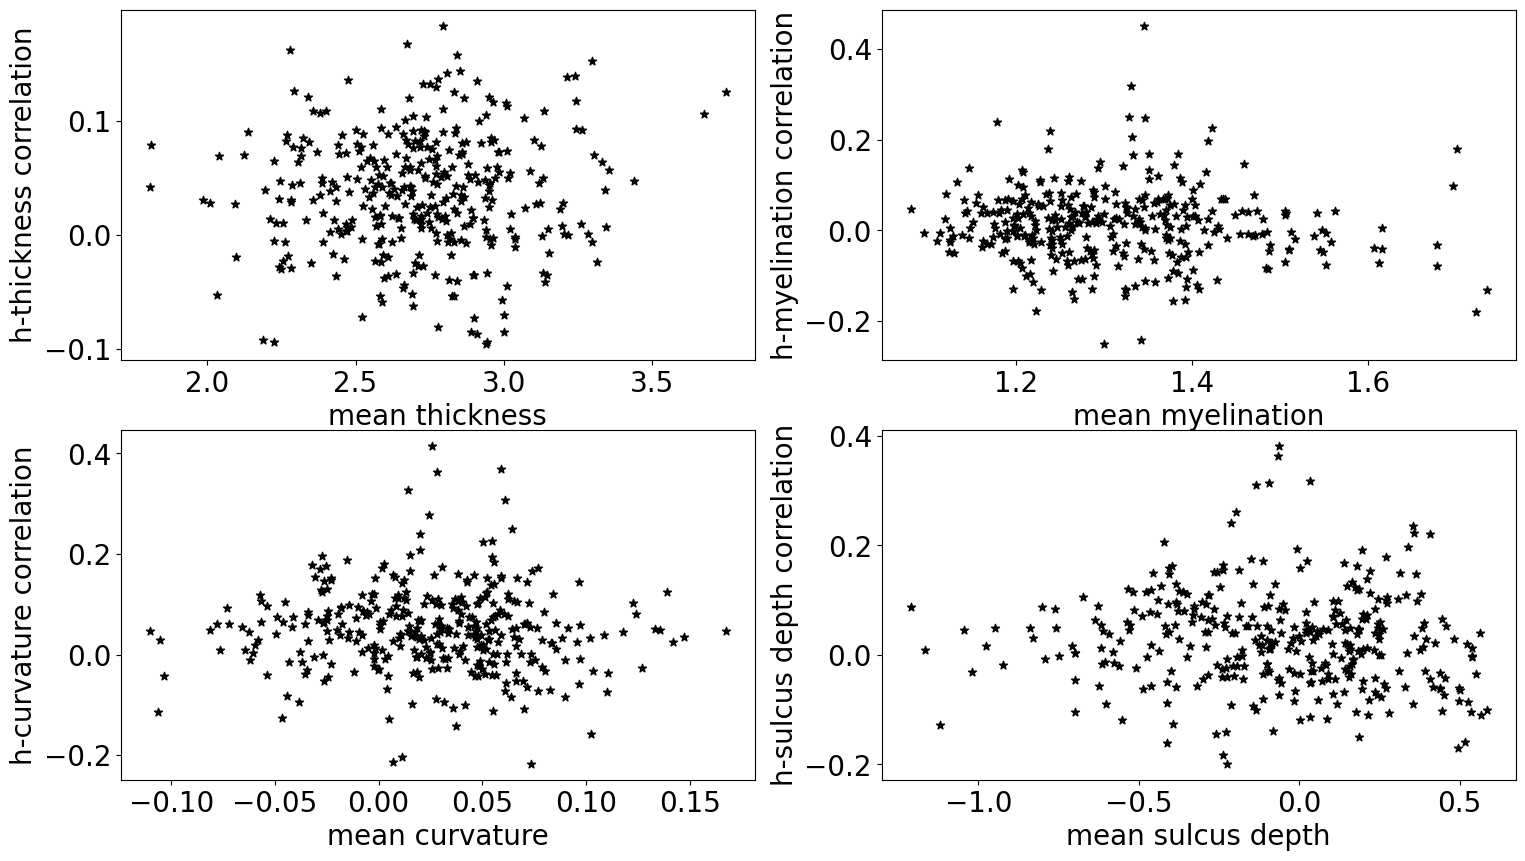

In [36]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names)
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 10) )
for feature_index, r, c in zip( range(num_features), [0,0,1,1], [0,1,0,1] ):
    feature_name = feature_names[feature_index]
    ax = axs[r,c]
    ax.scatter( depytorch(mean_node_features[:,feature_index]), depytorch(h_node_feature_corr_tensor[:,feature_index]), color='black', marker='*' )
    ax.set_xlabel(f'mean {feature_name}')
    ax.set_ylabel(f'h-{feature_name} correlation')
plt.show()

In [72]:
h_std = h.std(dim=0)
print( h_std.size() )

torch.Size([360])


In [37]:
mean_corr_corr = isingmodellight.get_pairwise_correlation(mat1=mean_node_features, mat2=h_node_feature_corr_tensor, epsilon=0, dim=0)
print(mean_corr_corr)

tensor([ 0.0494, -0.0720, -0.0375, -0.0776], device='cuda:0')


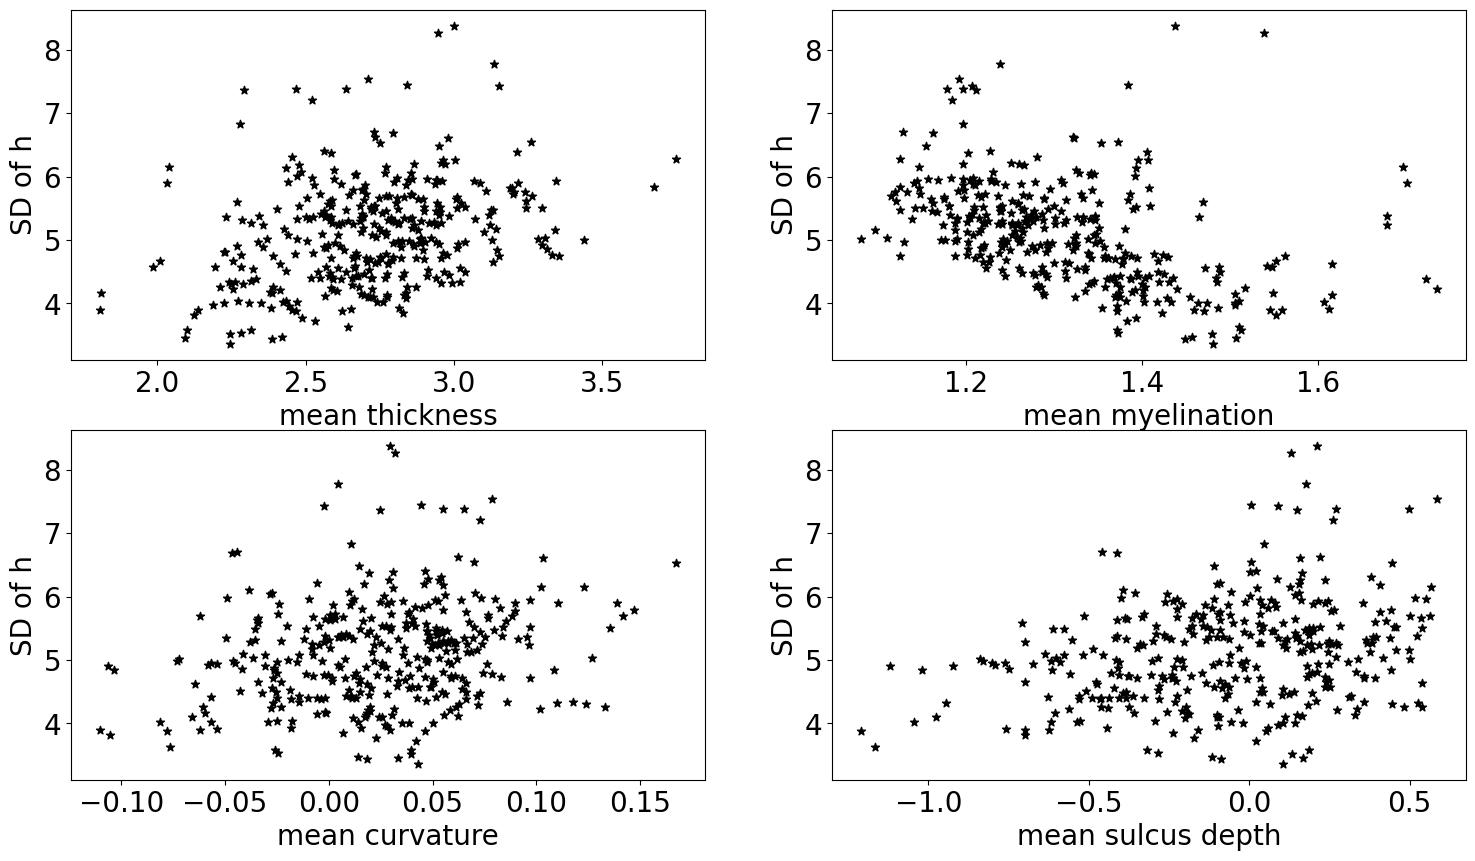

In [40]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names)
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 10) )
for feature_index, r, c in zip( range(num_features), [0,0,1,1], [0,1,0,1] ):
    feature_name = feature_names[feature_index]
    ax = axs[r,c]
    ax.scatter( depytorch(mean_node_features[:,feature_index]), depytorch(h_std), color='blue', marker='o' )
    ax.set_xlabel(f'mean {feature_name}')
    ax.set_ylabel(f'SD of h')
plt.show()

In [41]:
mean_std_corr = isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=h_std.unsqueeze(dim=-1), epsilon=0, dim=0 )
print(mean_std_corr)

tensor([ 0.3237, -0.4421,  0.2196,  0.2832], device='cuda:0')


In [48]:
num_permutations = 1000000
mean_std_corr_abs = mean_std_corr.abs()
mean_std_corr_num_greater = torch.zeros_like(mean_std_corr)
num_nodes = h_std.size(dim=0)
for permutation in range(num_permutations):
    perm = torch.randperm(n=num_nodes, dtype=int_type, device=h_std.device)
    mean_std_corr_abs_perm = isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=h_std[perm].unsqueeze(dim=-1), epsilon=0, dim=0 ).abs()
    mean_std_corr_num_greater += (mean_std_corr_abs_perm >= mean_std_corr_abs).float()
p_val = mean_std_corr_num_greater/num_permutations
print(p_val)

tensor([0.0000e+00, 0.0000e+00, 2.7000e-05, 0.0000e+00], device='cuda:0')


In [46]:
print( isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=h_std[perm].unsqueeze(dim=-1), epsilon=0, dim=0 ) )

tensor([-0.0676,  0.0713, -0.0268, -0.0513], device='cuda:0')


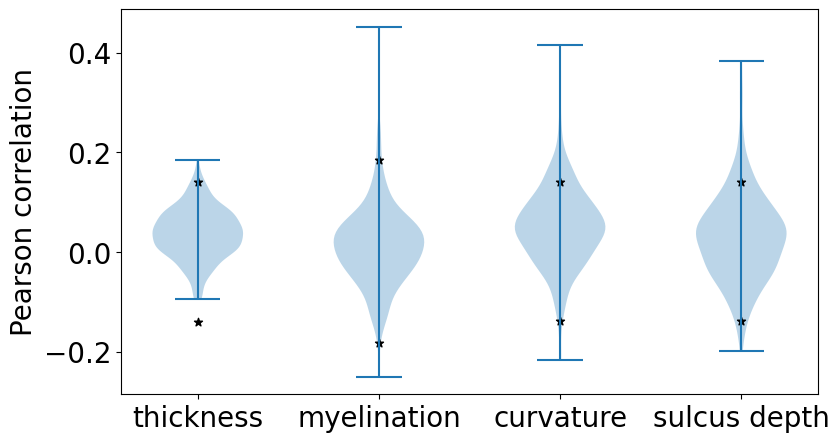

In [47]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['thickness', 'myelination', 'curvature', 'sulcus depth']
label_x = range( 1, len(corr_labels)+1 )
axs.violinplot( h_node_feature_corrs )
axs.scatter( label_x, depytorch(max_h_node_feature_crit_corr_tensor), color='black', marker='*' )
axs.scatter( label_x, depytorch(-1*max_h_node_feature_crit_corr_tensor), color='black', marker='*' )
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
plt.show()

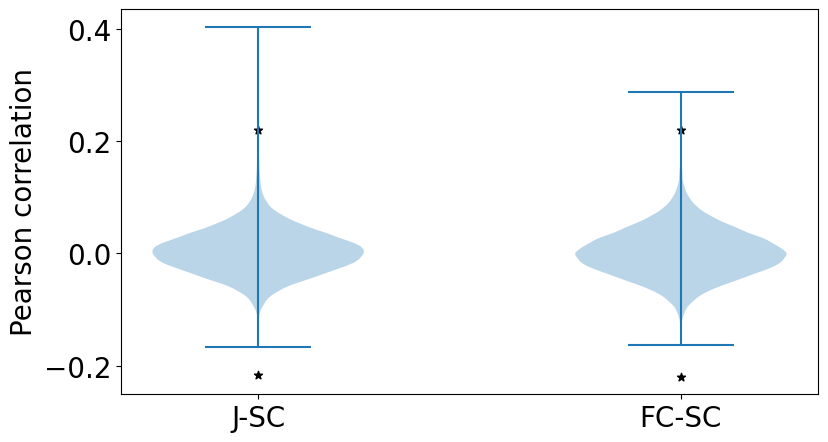

In [48]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
axs.violinplot( [depytorch(J_sc_corr), depytorch(fc_sc_corr)] )
axs.scatter( label_x, [fc_sc_crit_corr_max, fc_sc_crit_corr_max], color='black', marker='*' )
axs.scatter( label_x, [-1*J_sc_crit_corr_max, -1*fc_sc_crit_corr_max], color='black', marker='*' )
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
plt.show()

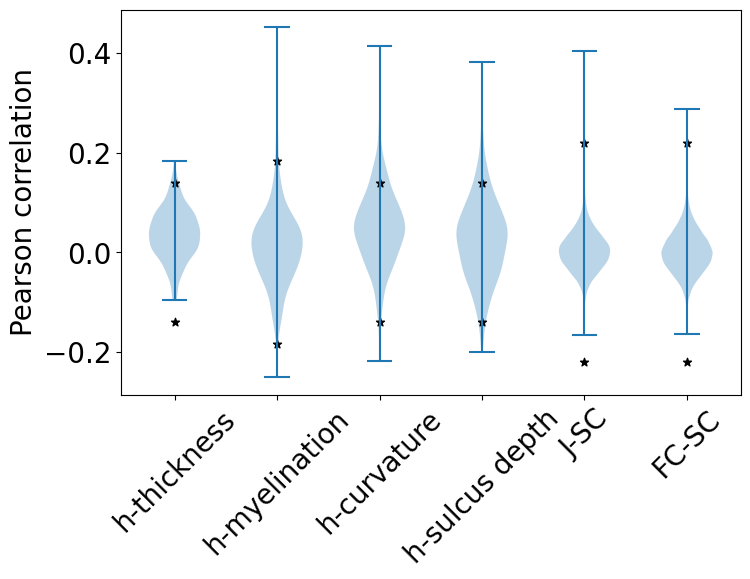

In [49]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(8, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
axs.violinplot( h_node_feature_corrs + [depytorch(J_sc_corr), depytorch(fc_sc_corr)] )
all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
axs.scatter( label_x, all_max_crit_corrs, color='black', marker='*' )
axs.scatter( label_x, [-cc for cc in all_max_crit_corrs], color='black', marker='*' )
axs.set_xticks(label_x)
plt.xticks(rotation=45)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
plt.show()

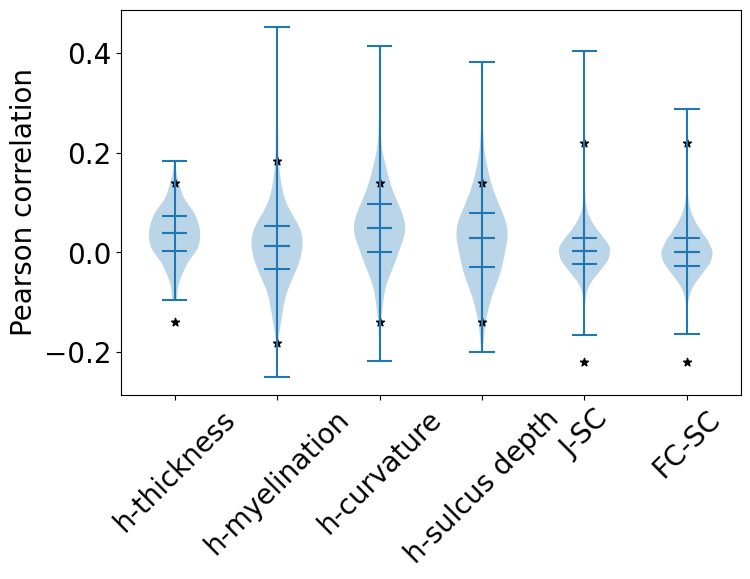

In [80]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(8, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = h_node_feature_corrs + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs) )
all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
axs.scatter( label_x, all_max_crit_corrs, color='black', marker='*' )
axs.scatter( label_x, [-cc for cc in all_max_crit_corrs], color='black', marker='*' )
axs.set_xticks(label_x)
plt.xticks(rotation=45)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
plt.show()

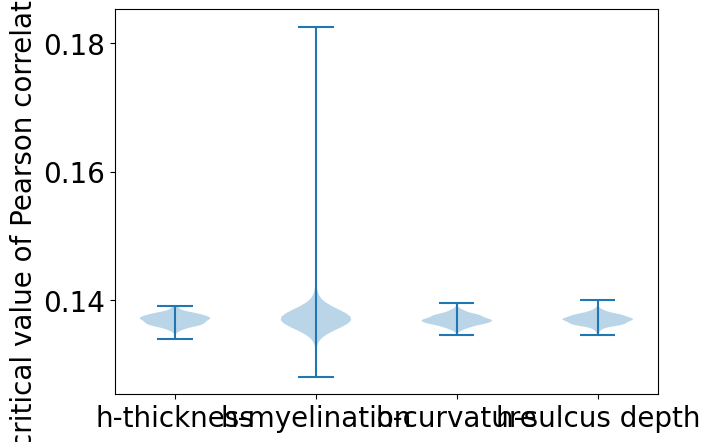

In [50]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(7, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth']
label_x = range( 1, len(corr_labels)+1 )
axs.violinplot( h_node_feature_crit_corrs )
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('critical value of Pearson correlation')
plt.show()

In [51]:
def set_violin_color(plot_handle, color:list):
    for violin in plot_handle['bodies']:
        # violin.set_facecolor([0.5+0.5*c for c in color])
        # violin.set_edgecolor(color)
        violin.set_color(color)
        # print(violin)
        # violin.set_alpha(0.5)

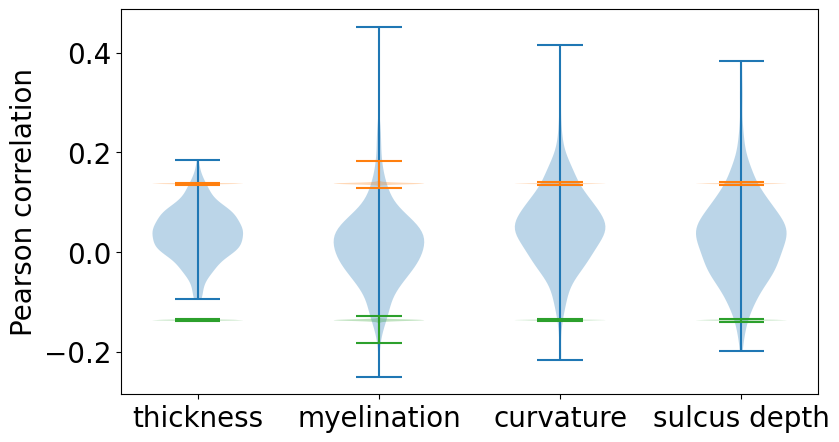

In [52]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['thickness', 'myelination', 'curvature', 'sulcus depth']
label_x = range( 1, len(corr_labels)+1 )
corr_plot = axs.violinplot( h_node_feature_corrs )
# print(corr_plot)
# set_violin_color(plot_handle=corr_plot, color=[0.0, 0.0, 1.0])
upper_crit_plot = axs.violinplot( h_node_feature_crit_corrs )
# set_violin_color(plot_handle=upper_crit_plot, color=[0.0, 0.0, 0.0])
lower_crit_plot = axs.violinplot([-1*cc for cc in h_node_feature_crit_corrs])
# set_violin_color(plot_handle=lower_crit_plot, color=[0.0, 0.0, 0.0])
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
# axs.legend()
plt.show()

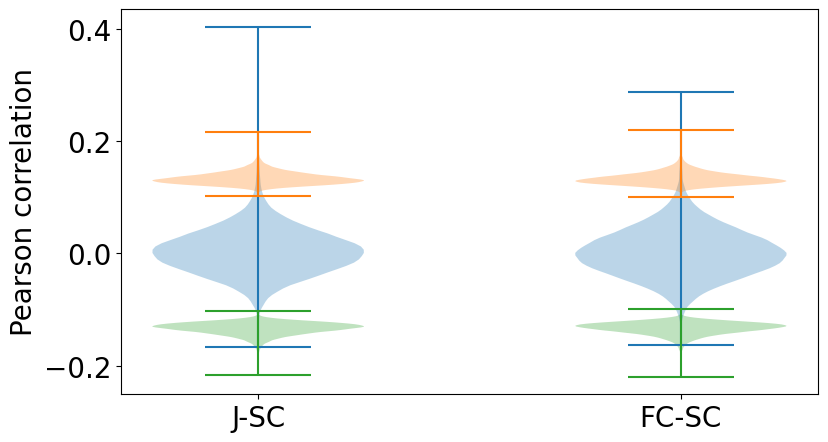

In [53]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
axs.violinplot( [depytorch(J_sc_corr), depytorch(fc_sc_corr)] )
axs.violinplot( [depytorch(J_sc_crit_corr), depytorch(fc_sc_crit_corr)] )
axs.violinplot( [depytorch(-1*J_sc_crit_corr), depytorch(-1*fc_sc_crit_corr)] )
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
plt.show()

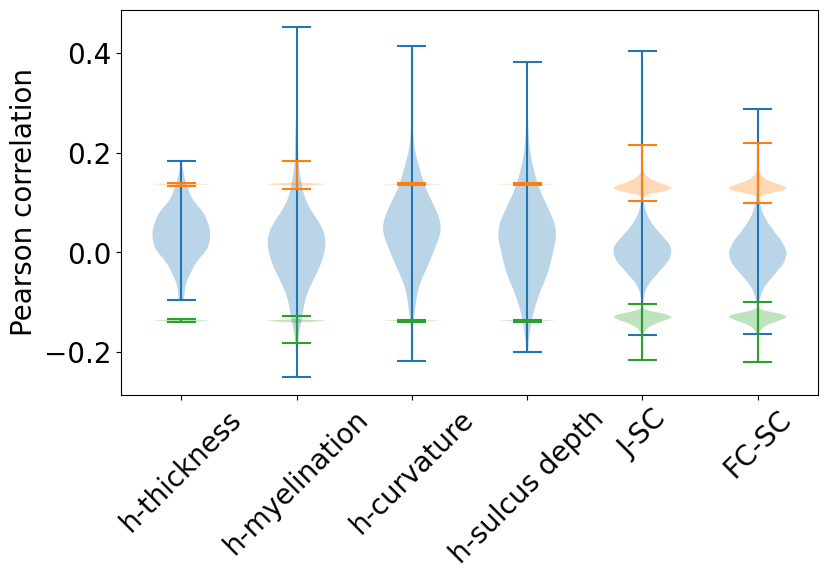

In [71]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
corr_plot = axs.violinplot( h_node_feature_corrs + [depytorch(J_sc_corr), depytorch(fc_sc_corr)] )
# print(corr_plot)
# set_violin_color(plot_handle=corr_plot, color=[0.0, 0.0, 1.0])
all_crit_corrs = h_node_feature_crit_corrs + [depytorch(J_sc_crit_corr), depytorch(fc_sc_crit_corr)]
upper_crit_plot = axs.violinplot(all_crit_corrs)
# set_violin_color(plot_handle=upper_crit_plot, color=[0.0, 0.0, 0.0])
lower_crit_plot = axs.violinplot([-1*cc for cc in all_crit_corrs])
# set_violin_color(plot_handle=lower_crit_plot, color=[0.0, 0.0, 0.0])
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
plt.xticks(rotation=45)
axs.set_ylabel('Pearson correlation')
# axs.legend()
plt.show()

In [55]:
h_feature_feature_corr_corrs = torch.corrcoef( h_node_feature_corr_tensor.transpose(dim0=0, dim1=1) )
print( h_feature_feature_corr_corrs.size() )
print( depytorch(h_feature_feature_corr_corrs) )

torch.Size([4, 4])
[[ 1.         -0.20218848  0.14892632  0.20523922]
 [-0.20218846  0.9999999  -0.3139751  -0.39697084]
 [ 0.14892632 -0.3139751   0.99999994  0.91052026]
 [ 0.20523924 -0.39697087  0.9105203   1.        ]]


In [56]:
h_node_feature_corr_is_significant = h_node_feature_corr_tensor.abs() >= h_node_feature_crit_corr_tensor
print( 'fraction of regions where correlation is significant', torch.count_nonzero(h_node_feature_corr_is_significant, dim=0)/h_node_feature_corr_is_significant.size(dim=0) )

fraction of regions where correlation is significant tensor([0.0278, 0.0806, 0.1444, 0.1194], device='cuda:0')


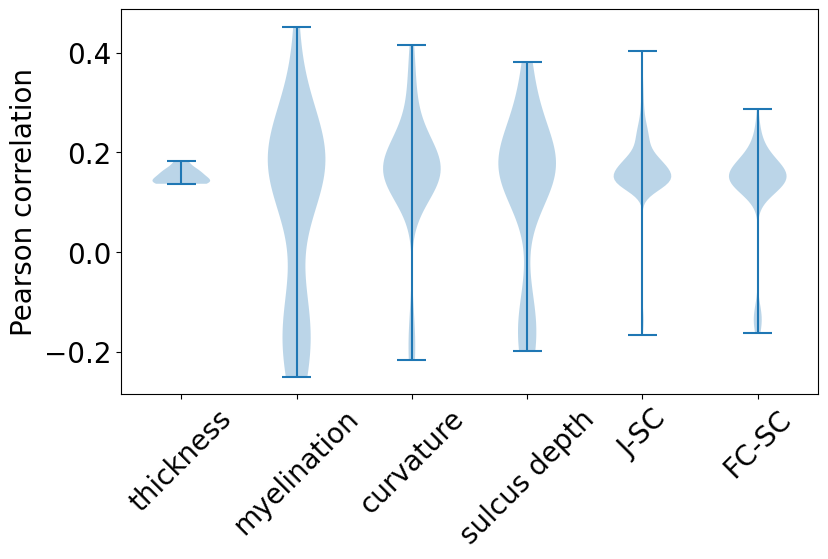

In [57]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['thickness', 'myelination', 'curvature', 'sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_sig_corrs = [cc[np.abs(cc) >= crit_cc] for cc, crit_cc in zip(h_node_feature_corrs, h_node_feature_crit_corrs)] + [depytorch(J_sc_corr[J_sc_corr.abs() >= J_sc_crit_corr]), depytorch(fc_sc_corr[fc_sc_corr.abs() >= fc_sc_crit_corr])]
corr_plot = axs.violinplot(all_sig_corrs)
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
plt.xticks(rotation=45)
axs.set_ylabel('Pearson correlation')
# axs.legend()
plt.show()

In [58]:
print([np.min( np.abs(cc) ).item() for cc in all_sig_corrs])

[0.13690298795700073, 0.13712602853775024, 0.1386331468820572, 0.1383582502603531, 0.1166796088218689, 0.1131305918097496]


In [59]:
sig_corr_indices = range( len(all_sig_corrs) )
neg_sig_corrs = [ cc[cc < 0] for cc in all_sig_corrs ]
neg_not_empty_indices = list( filter(lambda idx: neg_sig_corrs[idx].size > 0, sig_corr_indices) )
print( neg_not_empty_indices )
non_empty_neg_sig_corrs = [neg_sig_corrs[idx] for idx in neg_not_empty_indices]
# print(non_empty_neg_sig_corrs)
pos_sig_corrs = [ cc[cc >= 0] for cc in all_sig_corrs ]
pos_not_empty_indices = list( filter(lambda idx: pos_sig_corrs[idx].size > 0, sig_corr_indices) )
print( pos_not_empty_indices )
non_empty_pos_sig_corrs = [pos_sig_corrs[idx] for idx in pos_not_empty_indices]
# print(non_empty_pos_sig_corrs)

[1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]


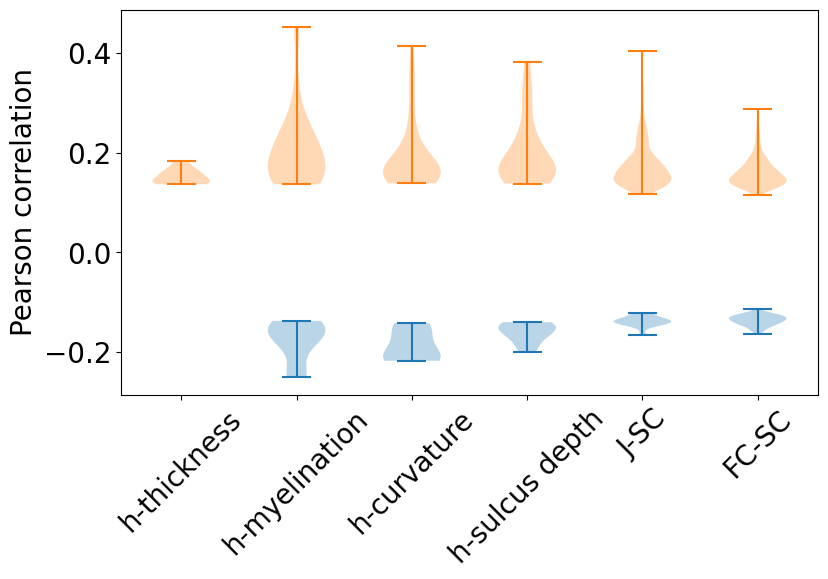

In [60]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_plot = axs.violinplot( non_empty_neg_sig_corrs, positions=neg_not_empty_indices )
corr_plot = axs.violinplot( non_empty_pos_sig_corrs, positions=pos_not_empty_indices )
axs.set_xticks(sig_corr_indices)
axs.set_xticklabels(corr_labels)
plt.xticks(rotation=45)
axs.set_ylabel('Pearson correlation')
# axs.legend()
plt.show()

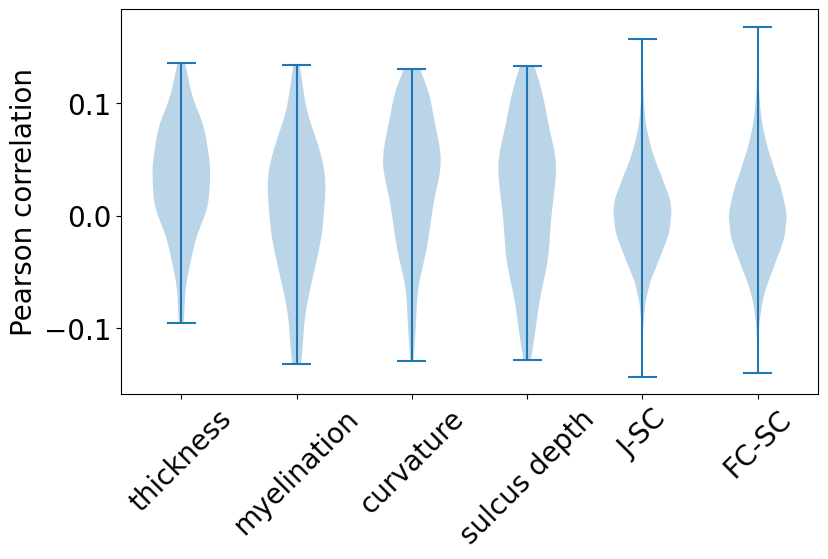

In [74]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['thickness', 'myelination', 'curvature', 'sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_non_sig_corrs = [cc[np.abs(cc) < crit_cc] for cc, crit_cc in zip(h_node_feature_corrs, h_node_feature_crit_corrs)] + [depytorch(J_sc_corr[J_sc_corr.abs() < J_sc_crit_corr]), depytorch(fc_sc_corr[fc_sc_corr.abs() < fc_sc_crit_corr])]
corr_plot = axs.violinplot(all_non_sig_corrs)
axs.set_xticks(label_x)
axs.set_xticklabels(corr_labels)
plt.xticks(rotation=45)
axs.set_ylabel('Pearson correlation')
# axs.legend()
plt.show()

In [76]:
non_sig_corr_indices = range( len(all_non_sig_corrs) )
non_sig_not_empty_indices = list( filter(lambda idx: all_non_sig_corrs[idx].size > 0, non_sig_corr_indices) )
print( non_sig_not_empty_indices )
non_empty_non_sig_corrs = [all_non_sig_corrs[idx] for idx in non_sig_not_empty_indices]

[0, 1, 2, 3, 4, 5]


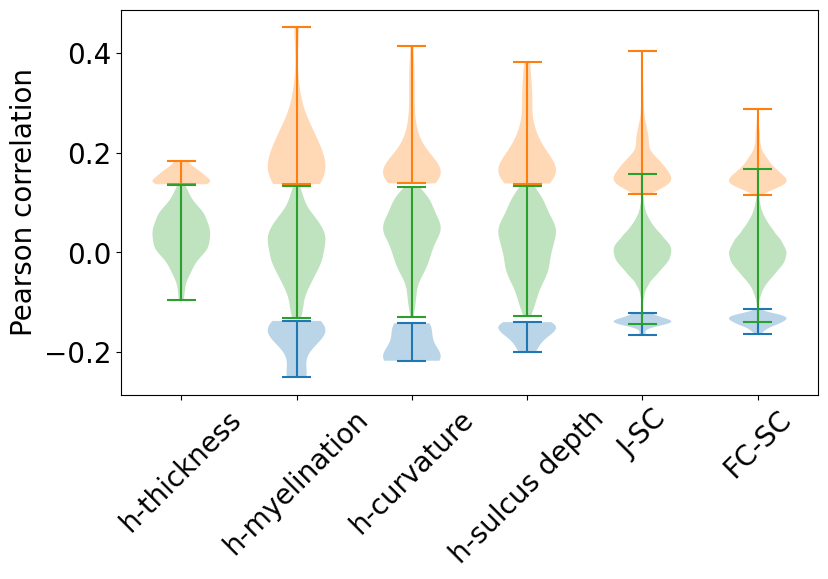

In [77]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_plot = axs.violinplot( non_empty_neg_sig_corrs, positions=neg_not_empty_indices )
corr_plot = axs.violinplot( non_empty_pos_sig_corrs, positions=pos_not_empty_indices )
corr_plot = axs.violinplot( non_empty_non_sig_corrs, positions=non_sig_not_empty_indices )
axs.set_xticks(sig_corr_indices)
axs.set_xticklabels(corr_labels)
plt.xticks(rotation=45)
axs.set_ylabel('Pearson correlation')
# axs.legend()
plt.show()

In [78]:
for sig_corrs, non_sig_corrs, corr_name in zip(all_sig_corrs, all_non_sig_corrs, corr_labels):
    num_sig = len(sig_corrs)
    num_non_sig = len(non_sig_corrs)
    total_corrs = num_sig + num_non_sig
    fraction_sig = num_sig/total_corrs
    print(f'For {corr_name} correlation, {num_sig} out of {total_corrs} correlations, {fraction_sig:.3g}, are significant.')

For h-thickness correlation, 10 out of 360 correlations, 0.0278, are significant.
For h-myelination correlation, 29 out of 360 correlations, 0.0806, are significant.
For h-curvature correlation, 52 out of 360 correlations, 0.144, are significant.
For h-sulcus depth correlation, 43 out of 360 correlations, 0.119, are significant.
For J-SC correlation, 614 out of 64620 correlations, 0.0095, are significant.
For FC-SC correlation, 413 out of 64620 correlations, 0.00639, are significant.


In [79]:
all_non_sig_crit_cors = [crit_cc[np.abs(cc) < crit_cc] for cc, crit_cc in zip(h_node_feature_corrs, h_node_feature_crit_corrs)] + [depytorch(J_sc_crit_corr[J_sc_corr.abs() < J_sc_crit_corr]), depytorch(fc_sc_crit_corr[fc_sc_corr.abs() < fc_sc_crit_corr])]
all_sig_crit_cors = [crit_cc[np.abs(cc) >= crit_cc] for cc, crit_cc in zip(h_node_feature_corrs, h_node_feature_crit_corrs)] + [depytorch(J_sc_crit_corr[J_sc_corr.abs() >= J_sc_crit_corr]), depytorch(fc_sc_crit_corr[fc_sc_corr.abs() >= fc_sc_crit_corr])]

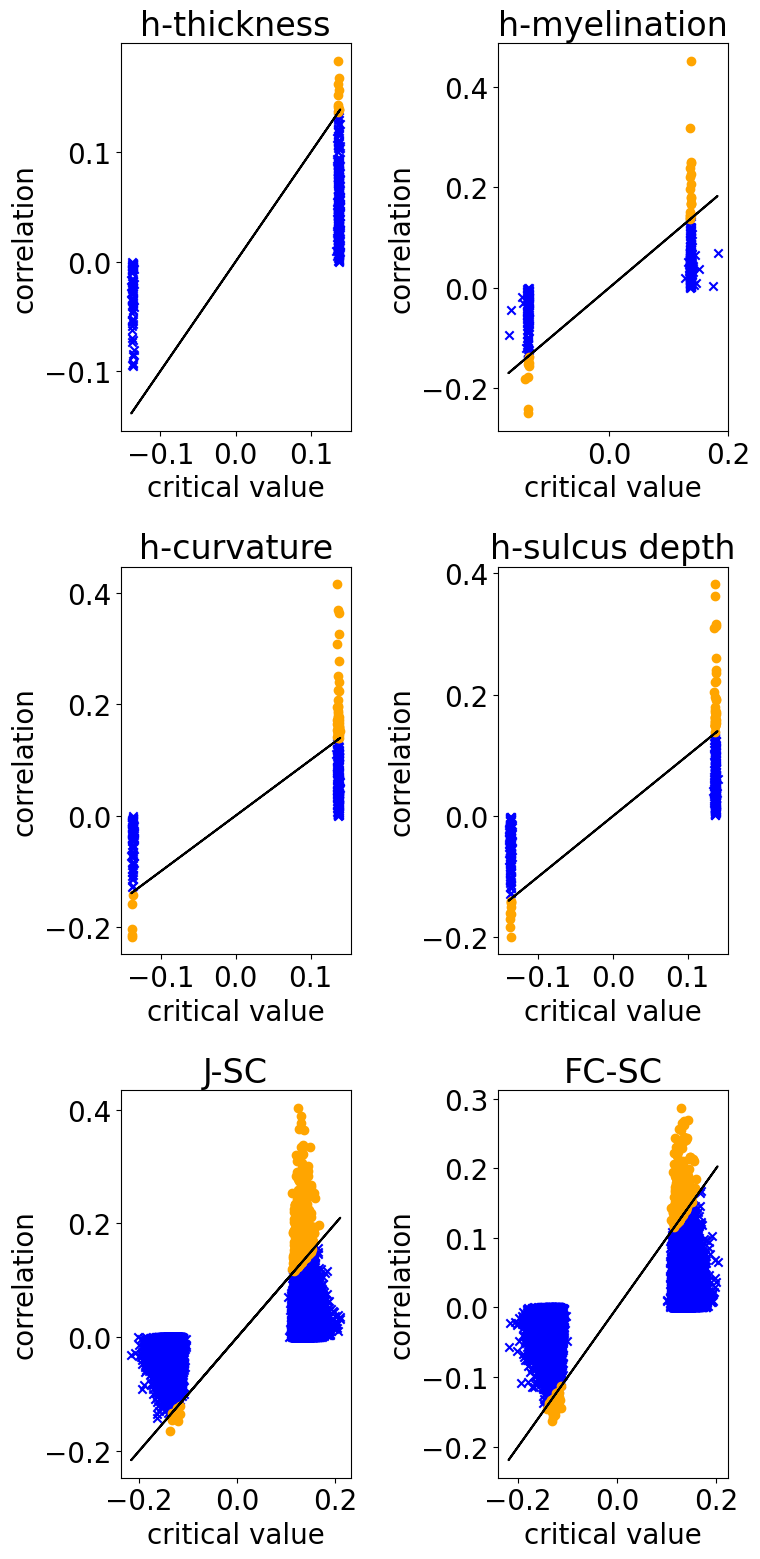

In [94]:
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(8, 16) )
for ax_row, ax_col, corr_name, sig_corr, non_sig_corr, sig_crit_corr, non_sig_crit_corr in zip([0,0,1,1,2,2], [0,1,0,1,0,1], corr_labels, all_sig_corrs, all_non_sig_corrs, all_sig_crit_cors, all_non_sig_crit_cors):
    ax = axs[ax_row,ax_col]
    signed_non_sig_crit_corr = np.sign(non_sig_corr)*non_sig_crit_corr
    signed_sig_crit_corr = np.sign(sig_corr)*sig_crit_corr
    ax.scatter( signed_non_sig_crit_corr, non_sig_corr, label=f'h-{feature_name} (not sig.)', marker='x', color='blue' )
    ax.scatter( signed_sig_crit_corr, sig_corr, label=f'h-{feature_name} (sig.)', marker='o', color='orange' )
    all_cirt_corr = np.concatenate( (signed_non_sig_crit_corr, signed_sig_crit_corr) )
    ax.plot(all_cirt_corr, all_cirt_corr, label='identity line', color='black')
    ax.set_title(f'{corr_name}')
    ax.set_xlabel('critical value')
    ax.set_ylabel('correlation')
    plt.tight_layout()
plt.show()

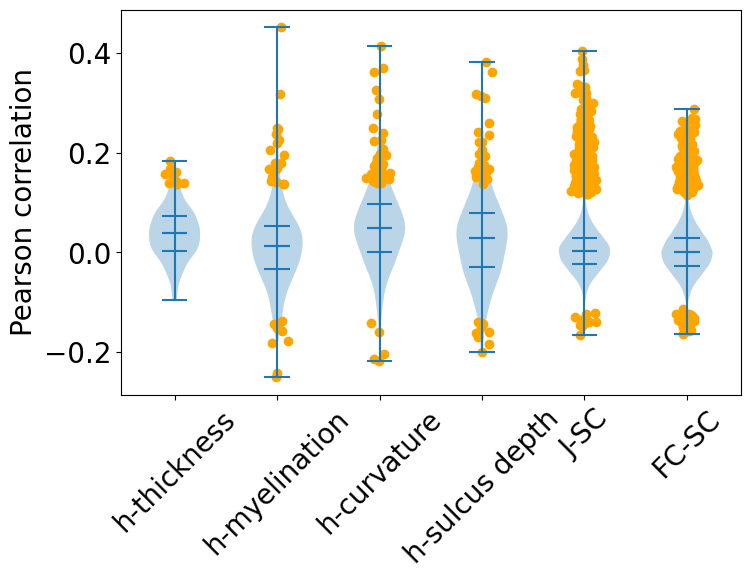

In [107]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(8, 5) )
corr_labels = ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = h_node_feature_corrs + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs) )
all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter( label_x, all_max_crit_corrs, color='black', marker='*' )
# axs.scatter( label_x, [-cc for cc in all_max_crit_corrs], color='black', marker='*' )
for sig_corr, x in zip(all_sig_corrs, label_x):
    axs.scatter(  np.full_like(sig_corr, fill_value=x) + 0.04*np.random.randn( len(sig_corr) ), sig_corr, color='orange', marker='o'  )
axs.set_xticks(label_x)
plt.xticks(rotation=45)
axs.set_xticklabels(corr_labels)
axs.set_ylabel('Pearson correlation')
plt.show()

In [33]:
h_variance = h.var(dim=0)

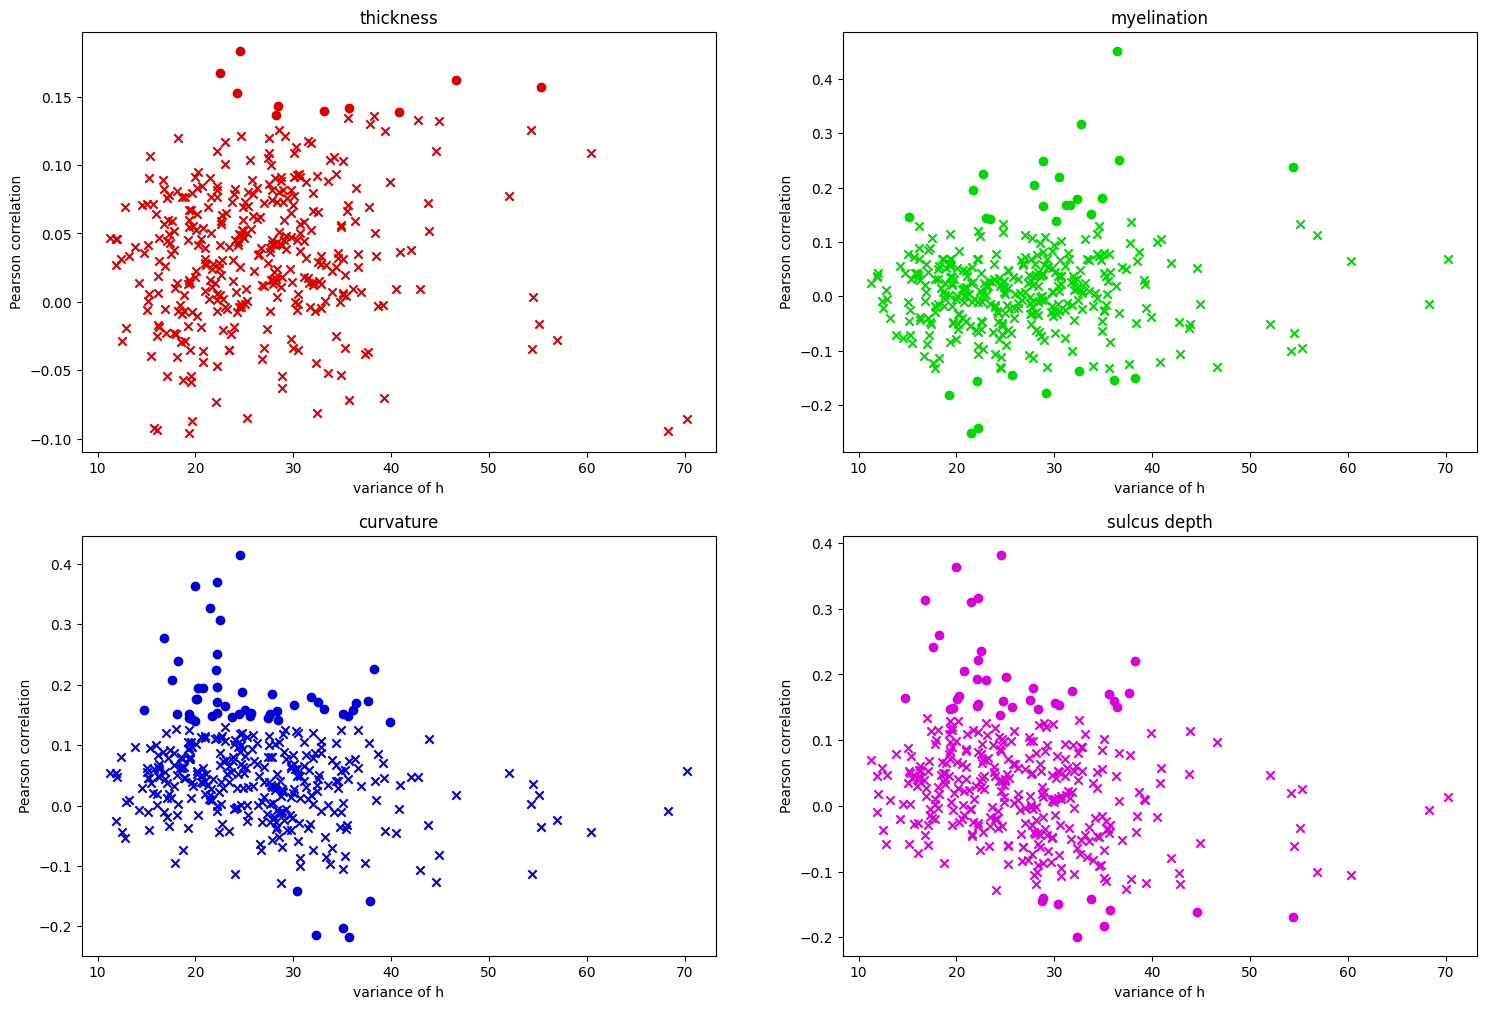

In [34]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
for feature_index, ax_row, ax_col, feature_name, feature_color in zip([0,1,2,3],[0,0,1,1],[0,1,0,1],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    ax = axs[ax_row,ax_col]
    current_is_sig = h_node_feature_corr_is_significant[:,feature_index]
    current_h_node_feature_corr = h_node_feature_corr_tensor[:,feature_index]
    sig_h_variance = h_variance[current_is_sig]
    sig_corr = current_h_node_feature_corr[current_is_sig]
    ax.scatter( depytorch(sig_h_variance), depytorch(sig_corr), label=f'h-{feature_name} (sig.)', marker='o', color=feature_color )
    current_not_sig = torch.logical_not(current_is_sig)
    not_h_variance = h_variance[current_not_sig]
    not_corr = current_h_node_feature_corr[current_not_sig]
    ax.scatter( depytorch(not_h_variance), depytorch(not_corr), label=f'h-{feature_name} (not sig.)', marker='x', color=feature_color )
    # ax.legend()
    # ax.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
    ax.set_title(feature_name)
    ax.set_xlabel('variance of h')
    ax.set_ylabel('Pearson correlation')
plt.show()

In [36]:
for feature_index, feature_name in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth']):
    h_var_corr_corr = isingmodellight.get_pairwise_correlation(mat1=h_variance, mat2=h_node_feature_corr_tensor[:,feature_index], epsilon=0, dim=0)
    print(f'The correlation between the variance of h for region and h-{feature_name} correlation is {h_var_corr_corr:.3g}.')

The correlation between the variance of h for region and h-thickness correlation is 0.0909.
The correlation between the variance of h for region and h-myelination correlation is 0.0873.
The correlation between the variance of h for region and h-curvature correlation is -0.224.
The correlation between the variance of h for region and h-sulcus depth correlation is -0.265.


In [37]:
node_feature_std = node_features.var(dim=0)
print( node_feature_std.size() )

torch.Size([360, 4])


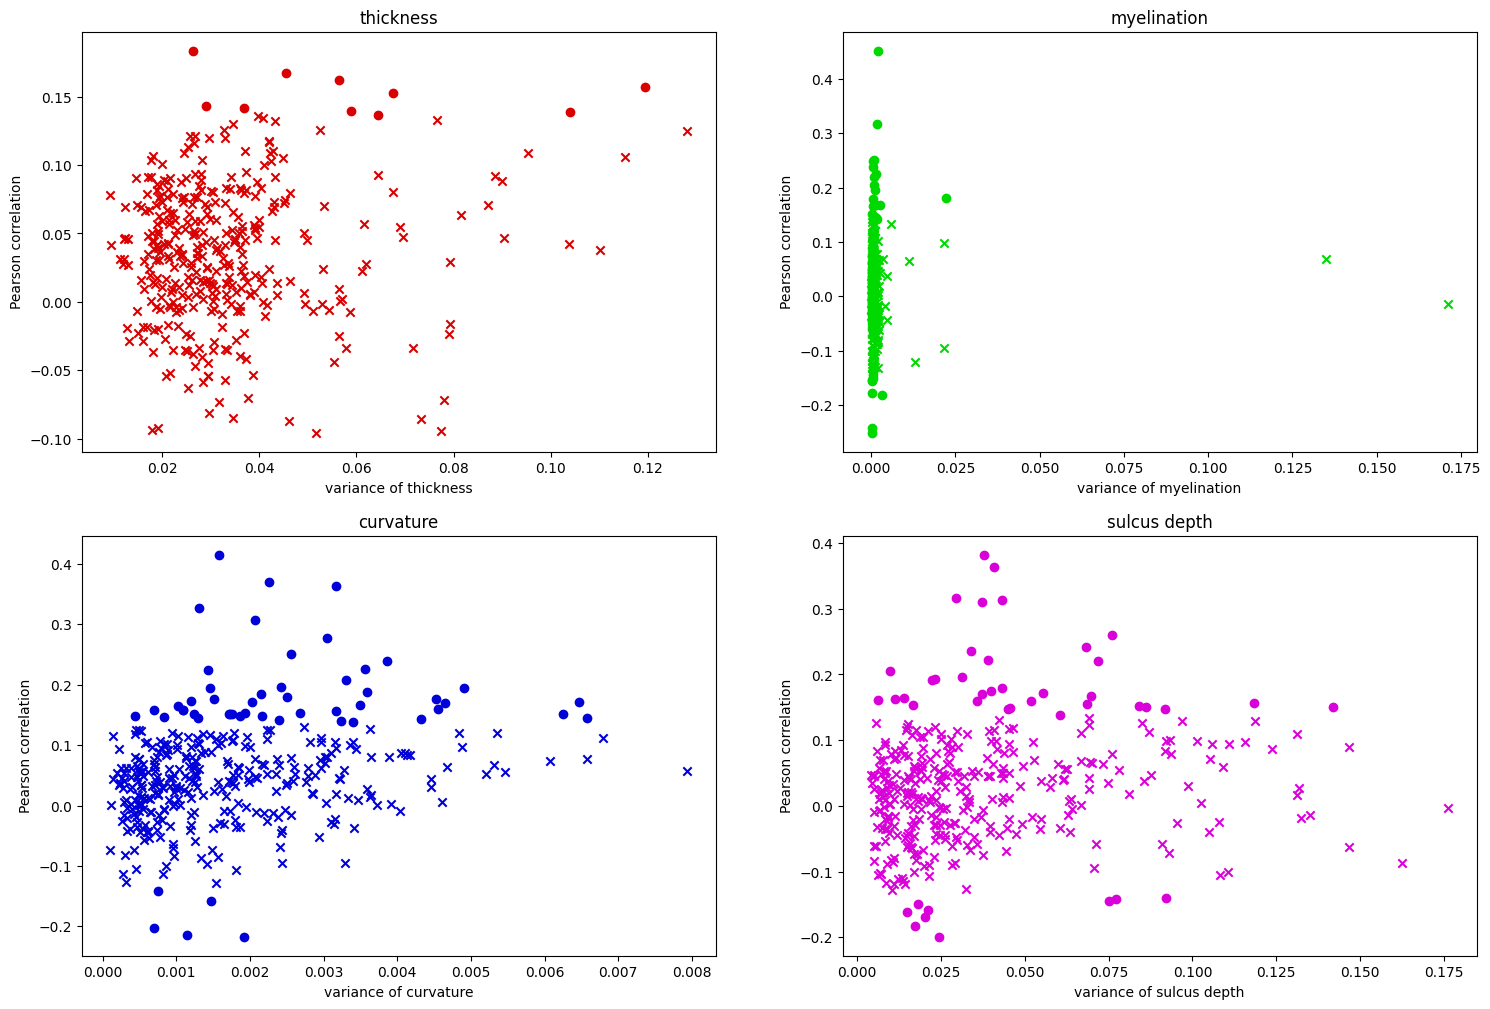

In [38]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
for feature_index, ax_row, ax_col, feature_name, feature_color in zip([0,1,2,3],[0,0,1,1],[0,1,0,1],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    ax = axs[ax_row,ax_col]
    current_feature_std = node_feature_std[:,feature_index]
    current_is_sig = h_node_feature_corr_is_significant[:,feature_index]
    current_h_node_feature_corr = h_node_feature_corr_tensor[:,feature_index]
    sig_feature_std = current_feature_std[current_is_sig]
    sig_corr = current_h_node_feature_corr[current_is_sig]
    ax.scatter( depytorch(sig_feature_std), depytorch(sig_corr), label=f'h-{feature_name} (sig.)', marker='o', color=feature_color )
    current_not_sig = torch.logical_not(current_is_sig)
    not_feature_std = current_feature_std[current_not_sig]
    not_corr = current_h_node_feature_corr[current_not_sig]
    ax.scatter( depytorch(not_feature_std), depytorch(not_corr), label=f'h-{feature_name} (not sig.)', marker='x', color=feature_color )
    # ax.legend()
    # ax.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
    ax.set_title(feature_name)
    ax.set_xlabel(f'variance of {feature_name}')
    ax.set_ylabel('Pearson correlation')
    # ax.set_xlim([-0.001, 0.005])
plt.show()

In [40]:
for feature_index, feature_name in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth']):
    h_var_corr_corr = isingmodellight.get_pairwise_correlation(mat1=node_feature_std[:,feature_index], mat2=h_node_feature_corr_tensor[:,feature_index], epsilon=0, dim=0)
    print(f'The correlation between the variance of {feature_name} for region and h-{feature_name} correlation is {h_var_corr_corr:.3g}.')

The correlation between the variance of thickness for region and h-thickness correlation is 0.133.
The correlation between the variance of myelination for region and h-myelination correlation is 0.021.
The correlation between the variance of curvature for region and h-curvature correlation is 0.28.
The correlation between the variance of sulcus depth for region and h-sulcus depth correlation is 0.155.


In [21]:
h_mean_mean = h.mean(dim=0)

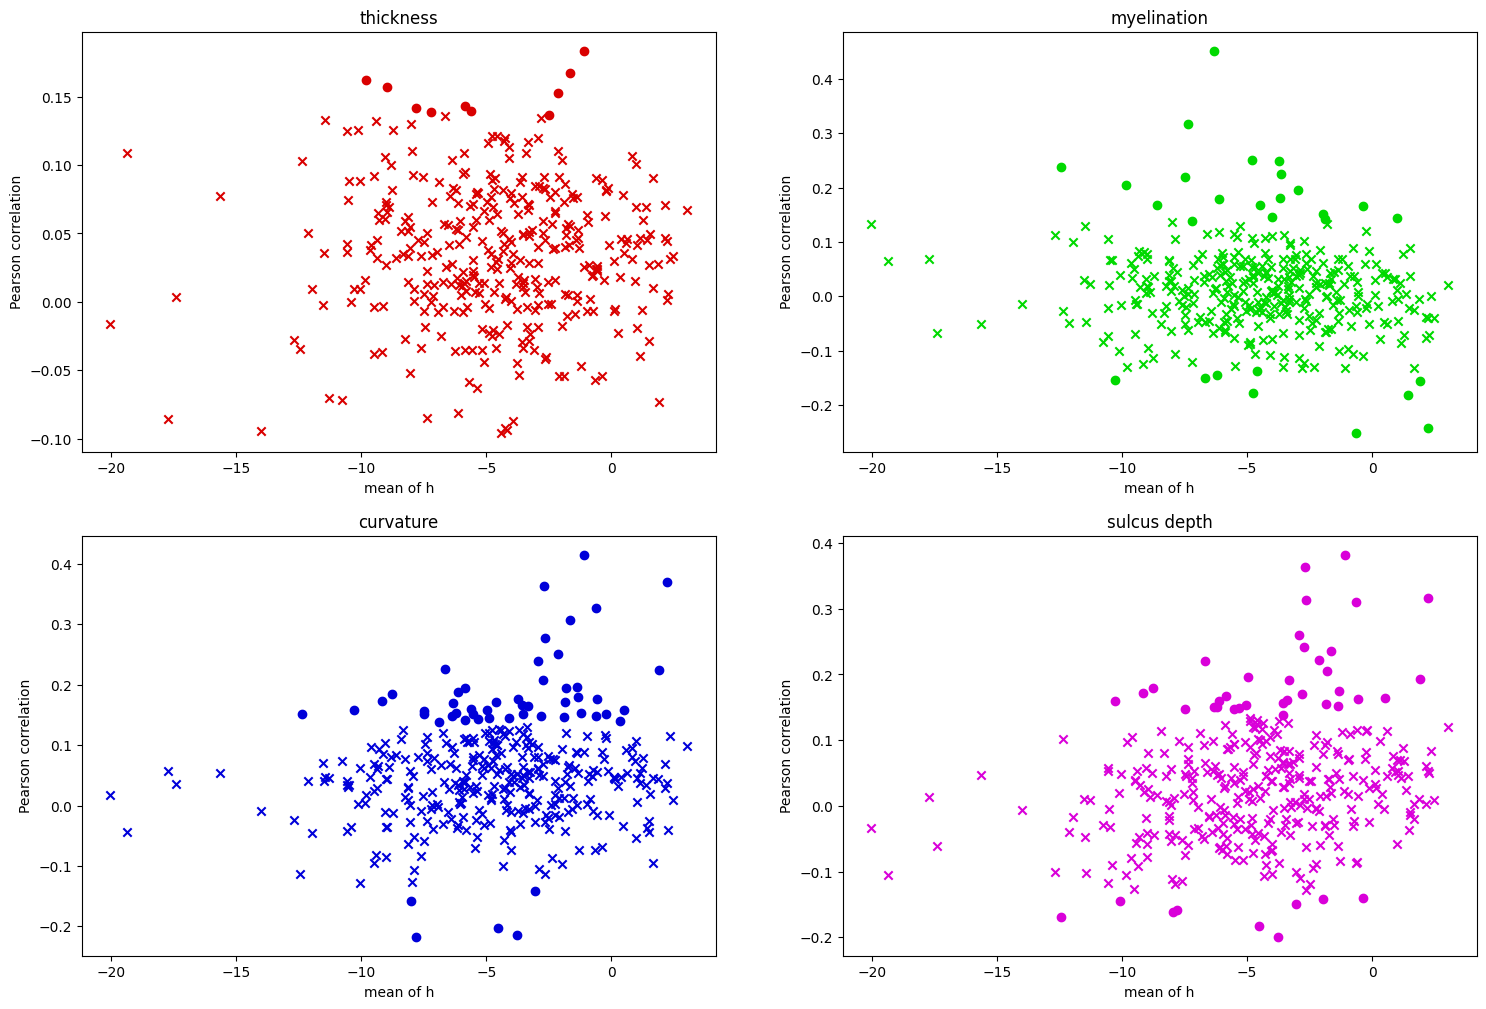

In [26]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
for feature_index, ax_row, ax_col, feature_name, feature_color in zip([0,1,2,3],[0,0,1,1],[0,1,0,1],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    ax = axs[ax_row,ax_col]
    current_is_sig = h_node_feature_corr_is_significant[:,feature_index]
    current_h_node_feature_corr = h_node_feature_corr_tensor[:,feature_index]
    sig_h_mean_mean = h_mean_mean[current_is_sig]
    sig_corr = current_h_node_feature_corr[current_is_sig]
    ax.scatter( depytorch(sig_h_mean_mean), depytorch(sig_corr), label=f'h-{feature_name} (sig.)', marker='o', color=feature_color )
    current_not_sig = torch.logical_not(current_is_sig)
    not_h_mean_mean = h_mean_mean[current_not_sig]
    not_corr = current_h_node_feature_corr[current_not_sig]
    ax.scatter( depytorch(not_h_mean_mean), depytorch(not_corr), label=f'h-{feature_name} (not sig.)', marker='x', color=feature_color )
    # ax.legend()
    # ax.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
    ax.set_title(feature_name)
    ax.set_xlabel('mean of h')
    ax.set_ylabel('Pearson correlation')
plt.show()

In [28]:
for feature_index, feature_name in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth']):
    h_mean_corr_corr = isingmodellight.get_pairwise_correlation(mat1=h_mean_mean, mat2=h_node_feature_corr_tensor[:,feature_index], epsilon=0, dim=0)
    print(f'The correlation between mean h for region and h-{feature_name} correlation is {h_mean_corr_corr:.3g}.')

The correlation between mean h for region and h-thickness correlation is -0.000124.
The correlation between mean h for region and h-myelination correlation is -0.136.
The correlation between mean h for region and h-curvature correlation is 0.149.
The correlation between mean h for region and h-sulcus depth correlation is 0.232.


In [29]:
node_feature_mean = node_features.mean(dim=0)
print( node_feature_mean.size() )

torch.Size([360, 4])


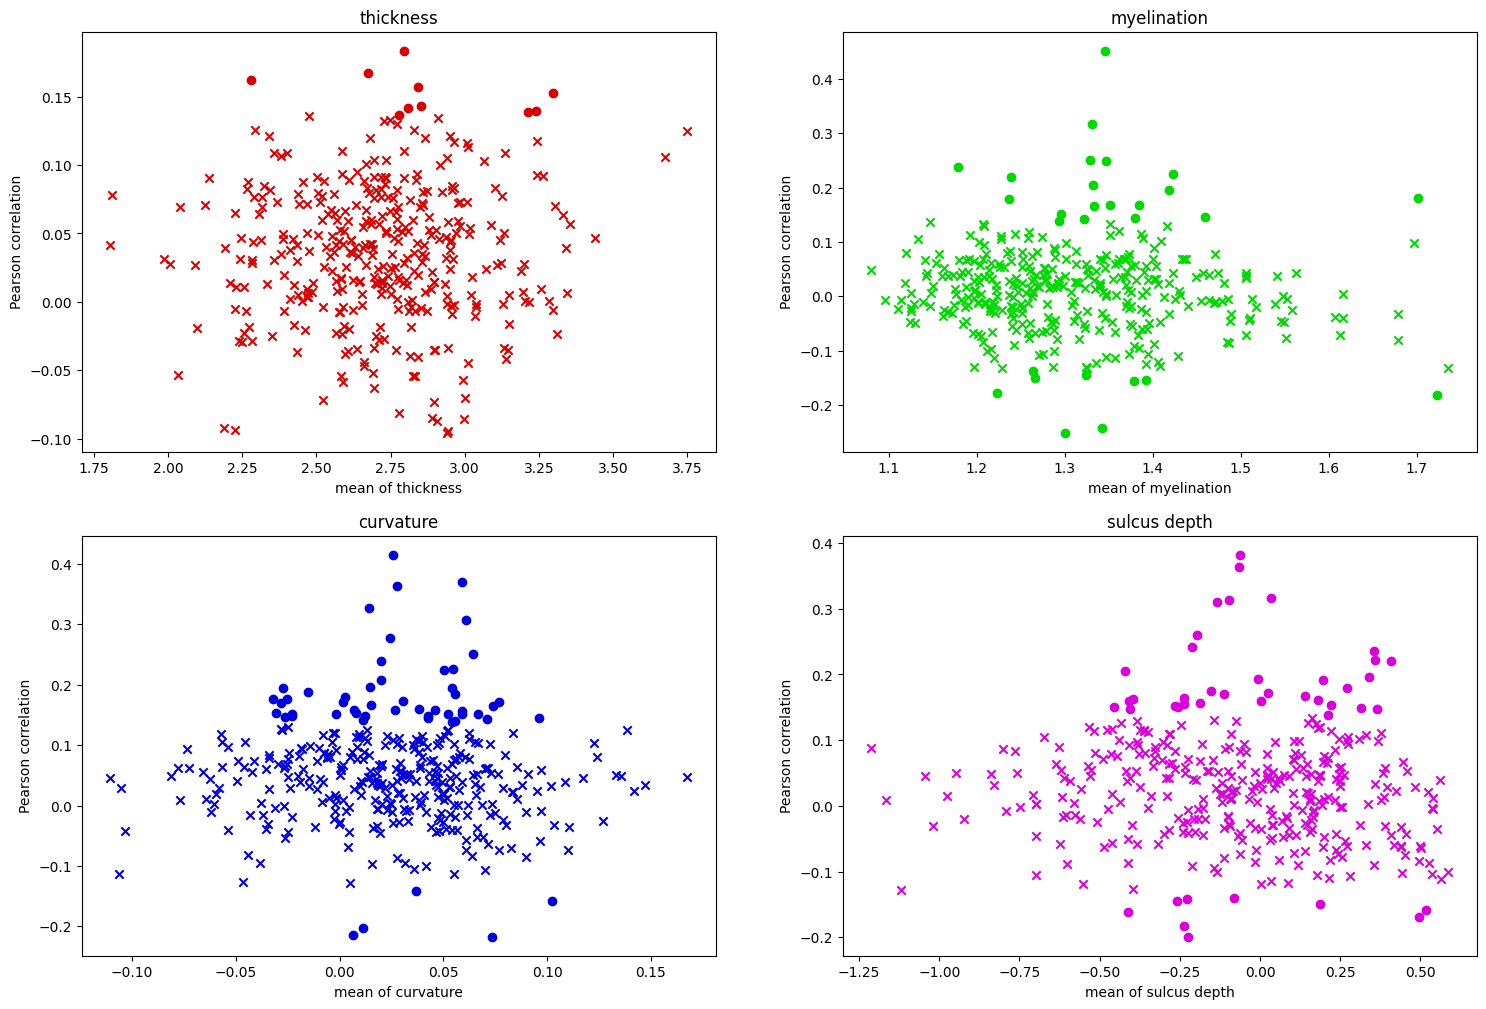

In [31]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
for feature_index, ax_row, ax_col, feature_name, feature_color in zip([0,1,2,3],[0,0,1,1],[0,1,0,1],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    ax = axs[ax_row,ax_col]
    current_is_sig = h_node_feature_corr_is_significant[:,feature_index]
    current_h_node_feature_corr = h_node_feature_corr_tensor[:,feature_index]
    sig_node_feature_mean = node_feature_mean[current_is_sig,feature_index]
    sig_corr = current_h_node_feature_corr[current_is_sig]
    ax.scatter( depytorch(sig_node_feature_mean), depytorch(sig_corr), label=f'h-{feature_name} (sig.)', marker='o', color=feature_color )
    current_not_sig = torch.logical_not(current_is_sig)
    not_node_feature_mean = node_feature_mean[current_not_sig,feature_index]
    not_corr = current_h_node_feature_corr[current_not_sig]
    ax.scatter( depytorch(not_node_feature_mean), depytorch(not_corr), label=f'h-{feature_name} (not sig.)', marker='x', color=feature_color )
    # ax.legend()
    # ax.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
    ax.set_title(feature_name)
    ax.set_xlabel(f'mean of {feature_name}')
    ax.set_ylabel('Pearson correlation')
plt.show()

In [39]:
for feature_index, feature_name in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth']):
    h_mean_corr_corr = isingmodellight.get_pairwise_correlation(mat1=node_feature_mean[:,feature_index], mat2=h_node_feature_corr_tensor[:,feature_index], epsilon=0, dim=0)
    print(f'The correlation between mean {feature_name} for region and h-{feature_name} correlation is {h_mean_corr_corr:.3g}.')

The correlation between mean thickness for region and h-thickness correlation is 0.0494.
The correlation between mean myelination for region and h-myelination correlation is -0.072.
The correlation between mean curvature for region and h-curvature correlation is -0.0375.
The correlation between mean sulcus depth for region and h-sulcus depth correlation is -0.0776.


In [26]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
state_mean_rmse_file = os.path.join(file_dir, f'state_mean_rmse_ising_model_light_group_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt')
state_mean_rmse = torch.load(state_mean_rmse_file, weights_only=False)
print( state_mean_rmse.size() )

torch.Size([101, 31])


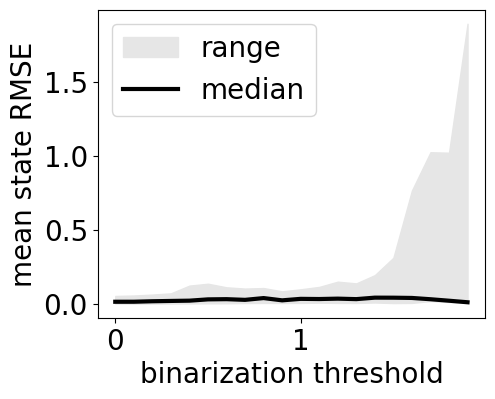

In [28]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
max_thrshold_index = 20
threshold_np = depytorch(threshold[:max_thrshold_index])
state_mean_rmse_min_np = depytorch( state_mean_rmse.min(dim=0).values[:max_thrshold_index] )
state_mean_rmse_median_np = depytorch( state_mean_rmse.median(dim=0).values[:max_thrshold_index] )
state_mean_rmse_max_np = depytorch( state_mean_rmse.max(dim=0).values[:max_thrshold_index] )
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, state_mean_rmse_min_np, state_mean_rmse_max_np, color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, state_mean_rmse_median_np, color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean state RMSE')
plt.show()

In [29]:
state_product_mean_rmse_file = os.path.join(file_dir, f'state_product_mean_rmse_ising_model_light_group_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt')
state_product_mean_rmse = torch.load(state_product_mean_rmse_file, weights_only=False)
print( state_product_mean_rmse.size() )

torch.Size([101, 31])


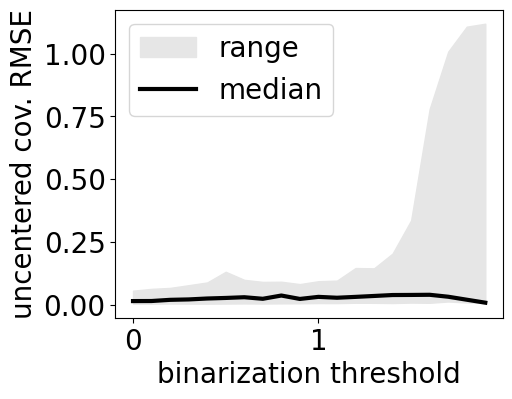

In [31]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
max_thrshold_index = 20
threshold_np = depytorch(threshold[:max_thrshold_index])
state_product_mean_rmse_min_np = depytorch( state_product_mean_rmse.min(dim=0).values[:max_thrshold_index] )
state_product_mean_rmse_median_np = depytorch( state_product_mean_rmse.median(dim=0).values[:max_thrshold_index] )
state_product_mean_rmse_max_np = depytorch( state_product_mean_rmse.max(dim=0).values[:max_thrshold_index] )
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, state_product_mean_rmse_min_np, state_product_mean_rmse_max_np, color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, state_product_mean_rmse_median_np, color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('uncentered cov. RMSE')
plt.show()

In [44]:
print( 'min', state_mean_rmse_min_np )
print( 'med', state_mean_rmse_median_np )
print( 'max', state_mean_rmse_max_np )

min [0.00304274 0.00401363 0.00517645 0.00407979 0.00518835 0.0056383
 0.00559853 0.00746356 0.0079579  0.00879059 0.00921835 0.00763165
 0.00891198 0.0066821  0.00847711 0.00696168 0.01803634 0.01706779
 0.01445823 0.01083486 0.00840505 0.00646539 0.00500287 0.00382163
 0.00293421 0.00223839 0.00170913 0.00127192 0.00098818 0.00076247
 0.00058615]
med [0.01543856 0.01466599 0.02031117 0.02672852 0.02631218 0.02996442
 0.03166303 0.03205731 0.04309868 0.02704147 0.03057124 0.03378206
 0.03839174 0.03849417 0.03822028 0.04394496 0.0432755  0.03434361
 0.0228252  0.01319891 0.00976595 0.00661085 0.00509145 0.00393064
 0.00301471 0.00230323 0.00176427 0.00134151 0.00102926 0.0008025
 0.00061578]
max [7.08873197e-02 7.17377663e-02 8.32298547e-02 1.10039935e-01
 1.19719587e-01 1.33567989e-01 1.09697491e-01 1.25323713e-01
 1.10540159e-01 1.14266224e-01 1.07783578e-01 1.30570829e-01
 1.50307700e-01 1.36680320e-01 1.58159867e-01 2.64938921e-01
 8.26520741e-01 1.01074684e+00 1.02127528e+00 1.89

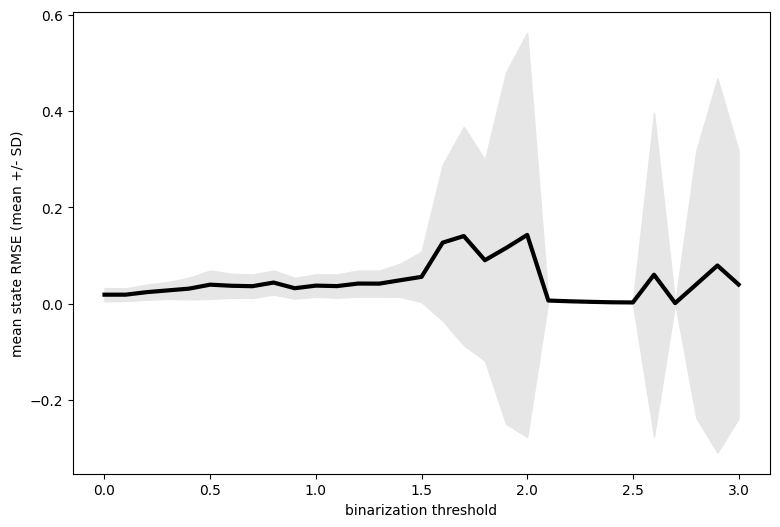

In [51]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
threshold_np = depytorch(threshold)
state_mean_rmse_std, state_mean_rmse_mean = torch.std_mean(state_mean_rmse, dim=0)
state_mean_rmse_mean_np = depytorch(state_mean_rmse_mean)
state_mean_rmse_below_np = depytorch(state_mean_rmse_mean - state_mean_rmse_std)
state_mean_rmse_above_np = depytorch(state_mean_rmse_mean + state_mean_rmse_std)
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, state_mean_rmse_below_np, state_mean_rmse_above_np, color=[0.9+0.1*c for c in cval], label=f'1SD above/below the mean')
axs.plot( threshold_np, state_mean_rmse_mean_np, color=cval, linewidth=line_width, label=f'mean' )

axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean state RMSE (mean +/- SD)')
plt.show()

In [14]:
mean_state_original_file = os.path.join(other_file_dir, 'mean_state_group_as_is.pt')
mean_state_original = torch.load(mean_state_original_file, weights_only=False).squeeze(dim=0)
print( mean_state_original.size() )

torch.Size([1, 360])


In [15]:
mean_state_original_file = os.path.join(other_file_dir, 'mean_state_all_as_is.pt')
mean_state_all = torch.load(mean_state_original_file, weights_only=False)
print( mean_state_all.size() )
mean_state_original = mean_state_all[:,training_subject_start:training_subject_end,:].mean(dim=0,keepdim=False).mean(dim=0,keepdim=True)
print( mean_state_original.size() )

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Ising_model_results_daai\\mean_state_all_as_is.pt'

In [10]:
data_ts = torch.load( os.path.join(other_file_dir, 'data_ts_all_as_is.pt'), weights_only=False )[:,training_subject_start:training_subject_end,:,:]
data_ts_std, data_ts_mean = torch.std_mean( data_ts, dim=(0,1,3) )
print( data_ts_std.size() )
mean_state_original = data_ts_mean.unsqueeze(dim=0)
print( mean_state_original.size() )

torch.Size([360])
torch.Size([1, 360])


In [12]:
torch.save( obj=data_ts_mean, f=os.path.join(file_dir, 'group_data_mean.pt') )
torch.save( obj=data_ts_std, f=os.path.join(file_dir, 'group_data_SD.pt') )

In [9]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
mean_state_binarized_file = os.path.join(file_dir, f'mean_state_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}.pt')
mean_state_binarized = torch.load(mean_state_binarized_file, weights_only=False)
print( mean_state_binarized.size() )

torch.Size([31, 360])


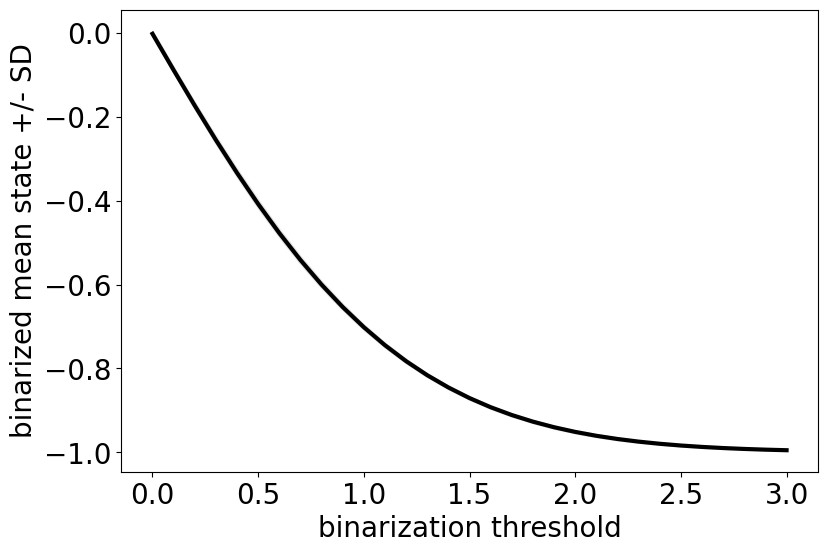

In [10]:
std_mean_state_binarized, mean_mean_state_binarized = torch.std_mean(mean_state_binarized, dim=-1)
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
threshold_np = depytorch(threshold)
mean_mean_state_binarized_np = depytorch(mean_mean_state_binarized)
state_mean_rmse_below_np = depytorch(mean_mean_state_binarized - std_mean_state_binarized)
state_mean_rmse_above_np = depytorch(mean_mean_state_binarized + std_mean_state_binarized)
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, state_mean_rmse_below_np, state_mean_rmse_above_np, color=[0.9+0.1*c for c in cval], label=f'1SD above/below the mean')
axs.plot( threshold_np, mean_mean_state_binarized_np, color=cval, linewidth=line_width, label=f'mean' )

axs.set_xlabel('binarization threshold')
axs.set_ylabel('binarized mean state +/- SD')
plt.show()

In [11]:
print( 'mean of binarized mean state', mean_mean_state_binarized )
print( 'SD of binarized mean state', std_mean_state_binarized )

mean of binarized mean state tensor([-0.0014, -0.0879, -0.1727, -0.2548, -0.3333, -0.4075, -0.4769, -0.5411,
        -0.5999, -0.6534, -0.7015, -0.7445, -0.7825, -0.8160, -0.8452, -0.8706,
        -0.8924, -0.9110, -0.9268, -0.9401, -0.9513, -0.9606, -0.9682, -0.9745,
        -0.9796, -0.9838, -0.9871, -0.9898, -0.9919, -0.9936, -0.9950],
       device='cuda:0')
SD of binarized mean state tensor([0.0073, 0.0079, 0.0088, 0.0097, 0.0103, 0.0104, 0.0102, 0.0096, 0.0087,
        0.0078, 0.0068, 0.0059, 0.0052, 0.0046, 0.0042, 0.0040, 0.0039, 0.0038,
        0.0037, 0.0036, 0.0035, 0.0033, 0.0031, 0.0028, 0.0026, 0.0023, 0.0021,
        0.0018, 0.0016, 0.0014, 0.0012], device='cuda:0')


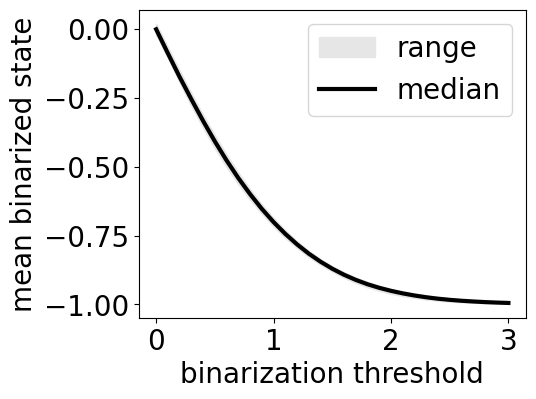

maximum range 0.0479


In [14]:
mean_state_bin_min = torch.min(mean_state_binarized, dim=-1).values
mean_state_bin_median = torch.median(mean_state_binarized, dim=-1).values
mean_state_bin_max = torch.max(mean_state_binarized, dim=-1).values
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
threshold_np = depytorch(threshold)
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(mean_state_bin_min), depytorch(mean_state_bin_max), color=[0.9+0.1*c for c in cval], label='range' )
axs.plot( threshold_np, depytorch(mean_state_bin_median), color=cval, linewidth=line_width, label='median' )

axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean binarized state')
axs.legend()
plt.show()
max_mean_state_bin_range = torch.max(mean_state_bin_max - mean_state_bin_min)
print(f'maximum range {max_mean_state_bin_range:.3g}')

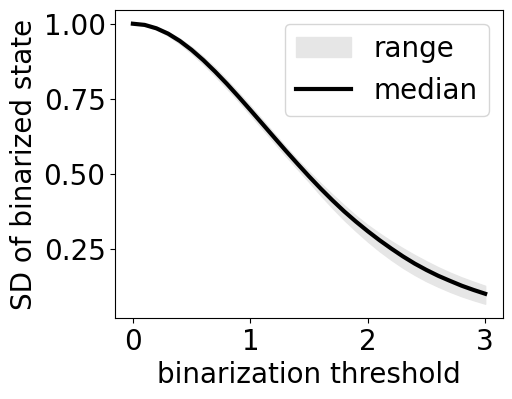

maximum range 0.0663


In [17]:
std_binarized_state = torch.sqrt( 1 - mean_state_binarized.square() )
std_state_bin_min = torch.min(std_binarized_state, dim=-1).values
std_state_bin_median = torch.median(std_binarized_state, dim=-1).values
std_state_bin_max = torch.max(std_binarized_state, dim=-1).values
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
threshold_np = depytorch(threshold)
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(std_state_bin_min), depytorch(std_state_bin_max), color=[0.9+0.1*c for c in cval], label='range' )
axs.plot( threshold_np, depytorch(std_state_bin_median), color=cval, linewidth=line_width, label='median' )

axs.set_xlabel('binarization threshold')
axs.set_ylabel('SD of binarized state')
axs.legend()
plt.show()
max_std_state_bin_range = torch.max(std_state_bin_max - std_state_bin_min)
print(f'maximum range {max_std_state_bin_range:.3g}')

In [20]:
selected_thresh_index = get_closest_match(threshold, 2.0)
print( f'At threshold {threshold[selected_thresh_index]}, SD of binarized state has min {std_state_bin_min[selected_thresh_index]:.3g}, median {std_state_bin_median[selected_thresh_index]:.3g}, max {std_state_bin_max[selected_thresh_index]:.3g}.' )

At threshold 2.0, SD of binarized state has min 0.275, median 0.31, max 0.33.


In [22]:
mean_state_individual_0 = torch.load( os.path.join(other_file_dir, 'mean_state_all_mean_std_0.pt'), weights_only=False )
print( mean_state_individual_0.size() )
mean_state_individual_1 = torch.load( os.path.join(other_file_dir, 'mean_state_all_mean_std_1.pt'), weights_only=False )
print( mean_state_individual_1.size() )

torch.Size([4, 837, 360])
torch.Size([4, 837, 360])


In [23]:
std_state_individual_0 = torch.sqrt( 1 - mean_state_individual_0.square() )
std_state_individual_1 = torch.sqrt( 1 - mean_state_individual_1.square() )

Text(0.5, 0, 'SD of binarized state')

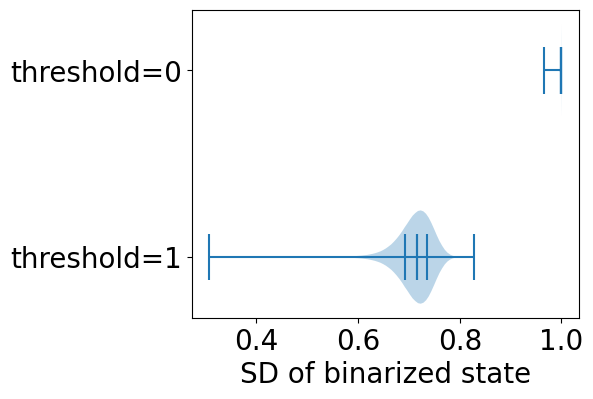

In [27]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs.violinplot(  list( reversed([depytorch(std_state_individual_0).flatten(), depytorch(std_state_individual_1).flatten()]) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*2, orientation='horizontal'  )
axs.set_yticks( range(1, 3) )
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(['threshold=0', 'threshold=1']) )  )
axs.set_xlabel('SD of binarized state')

In [28]:
print(f'SD of binarized state threshold=0 min {std_state_individual_0.min():.3g},  median {std_state_individual_0.median():.3g},  max {std_state_individual_0.max():.3g},  threshold=1 min {std_state_individual_1.min():.3g},  median {std_state_individual_1.median():.3g},  max {std_state_individual_1.max():.3g}')

SD of binarized state threshold=0 min 0.966,  median 1,  max 1,  threshold=1 min 0.307,  median 0.716,  max 0.828


In [27]:
# print( mean_state_original_right_dims.size() )
mean_state_original_binarized_corr = isingmodellight.get_pairwise_correlation(mat1=mean_state_binarized, mat2=mean_state_original, epsilon=0, dim=-1)
print(mean_state_original_binarized_corr)

tensor([-0.6625, -0.6418, -0.5816, -0.5146, -0.4502, -0.3896, -0.3302, -0.2692,
        -0.1980, -0.1153, -0.0162,  0.1008,  0.2342,  0.3670,  0.4872,  0.5785,
         0.6340,  0.6618,  0.6714,  0.6681,  0.6594,  0.6475,  0.6331,  0.6170,
         0.6003,  0.5824,  0.5636,  0.5448,  0.5258,  0.5082,  0.4884],
       device='cuda:0')


In [45]:
torch.save( obj=mean_state_original_binarized_corr, f=os.path.join(file_dir, 'mean_state_original_binarized_corr.pt') )

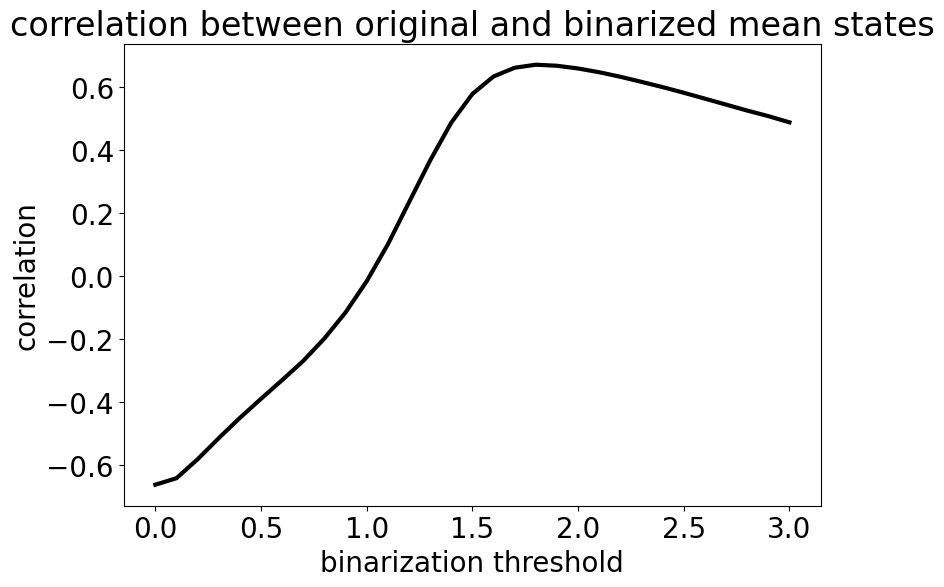

In [28]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.plot( threshold_np, depytorch(mean_state_original_binarized_corr), color=cval, linewidth=line_width, label=f'median' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between original and binarized mean states')
plt.show()

In [29]:
print( data_ts_std.size() )
std_state_original_binarized_corr = isingmodellight.get_pairwise_correlation( mat1=mean_state_binarized, mat2=data_ts_std.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(std_state_original_binarized_corr)

torch.Size([360])
tensor([ 0.0072,  0.0625,  0.1036,  0.1310,  0.1473,  0.1604,  0.1695,  0.1787,
         0.1840,  0.1878,  0.1848,  0.1774,  0.1588,  0.1309,  0.0938,  0.0521,
         0.0141, -0.0159, -0.0388, -0.0563, -0.0684, -0.0762, -0.0832, -0.0905,
        -0.0926, -0.0923, -0.0932, -0.0930, -0.0901, -0.0831, -0.0784],
       device='cuda:0')


In [46]:
torch.save( obj=std_state_original_binarized_corr, f=os.path.join(file_dir, 'std_state_original_binarized_corr.pt') )

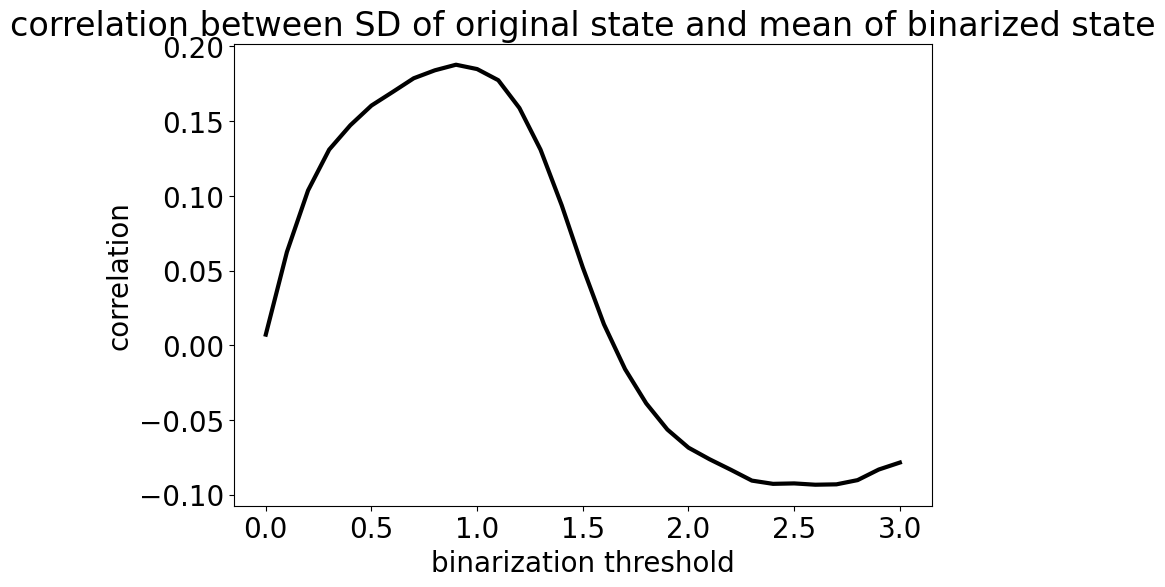

In [30]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.plot( threshold_np, depytorch(std_state_original_binarized_corr), color=cval, linewidth=line_width, label=f'median' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between SD of original state and mean of binarized state')
plt.show()

In [31]:
std_state_binarized = torch.sqrt( 1.0 - torch.square(mean_state_binarized) )

In [32]:
print( std_state_binarized.size() )
std_state_original_std_binarized_corr = isingmodellight.get_pairwise_correlation( mat1=std_state_binarized, mat2=data_ts_std.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(std_state_original_std_binarized_corr)

torch.Size([31, 360])
tensor([ 0.0414,  0.0605,  0.1020,  0.1299,  0.1471,  0.1608,  0.1704,  0.1801,
         0.1856,  0.1897,  0.1871,  0.1799,  0.1614,  0.1334,  0.0961,  0.0538,
         0.0154, -0.0153, -0.0388, -0.0568, -0.0693, -0.0774, -0.0847, -0.0917,
        -0.0941, -0.0938, -0.0944, -0.0939, -0.0906, -0.0830, -0.0783],
       device='cuda:0')


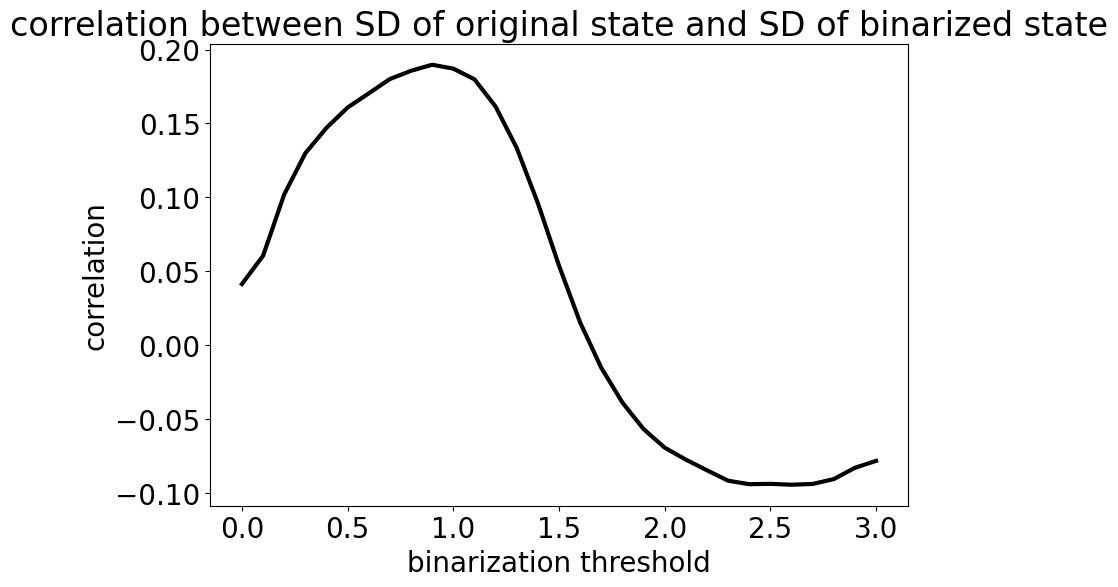

In [33]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.plot( threshold_np, depytorch(std_state_original_std_binarized_corr), color=cval, linewidth=line_width, label=f'median' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between SD of original state and SD of binarized state')
plt.show()

In [34]:
print( threshold[std_state_original_std_binarized_corr.argmax()] )

tensor(0.9000, device='cuda:0')


In [17]:
individual_std, individual_mean = torch.std_mean(data_ts, dim=-1)
std_mean_over_std, mean_mean_over_std = torch.std_mean( individual_mean/individual_std, dim=(0,1) )

In [36]:
print( mean_mean_over_std.size() )
mean_mean_over_std_corr = isingmodellight.get_pairwise_correlation( mat1=mean_state_binarized, mat2=mean_mean_over_std.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(mean_mean_over_std_corr)

torch.Size([360])
tensor([-0.6111, -0.5113, -0.3990, -0.3005, -0.2180, -0.1461, -0.0805, -0.0151,
         0.0554,  0.1334,  0.2201,  0.3162,  0.4163,  0.5035,  0.5688,  0.6029,
         0.6072,  0.5939,  0.5720,  0.5453,  0.5191,  0.4942,  0.4694,  0.4444,
         0.4213,  0.3997,  0.3780,  0.3571,  0.3381,  0.3234,  0.3054],
       device='cuda:0')


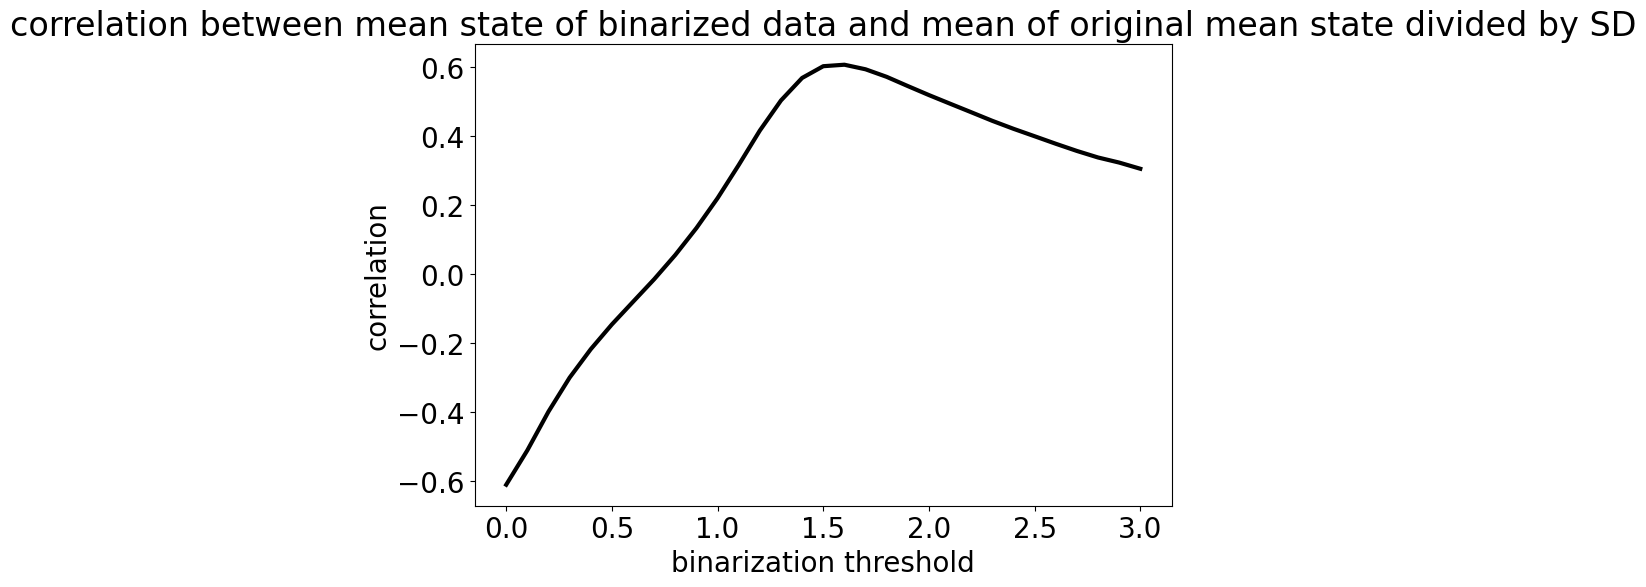

In [37]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.plot( threshold_np, depytorch(mean_mean_over_std_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between mean state of binarized data and mean of original mean state divided by SD')
plt.show()

In [38]:
print( std_mean_over_std.size() )
std_mean_over_std_corr = isingmodellight.get_pairwise_correlation( mat1=mean_state_binarized, mat2=std_mean_over_std.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(std_mean_over_std_corr)

torch.Size([360])
tensor([ 0.3449,  0.2262,  0.1116,  0.0137, -0.0697, -0.1429, -0.2148, -0.2846,
        -0.3573, -0.4313, -0.5097, -0.5853, -0.6452, -0.6777, -0.6730, -0.6276,
        -0.5562, -0.4740, -0.3918, -0.3148, -0.2419, -0.1765, -0.1154, -0.0577,
        -0.0032,  0.0495,  0.0980,  0.1462,  0.1941,  0.2390,  0.2835],
       device='cuda:0')


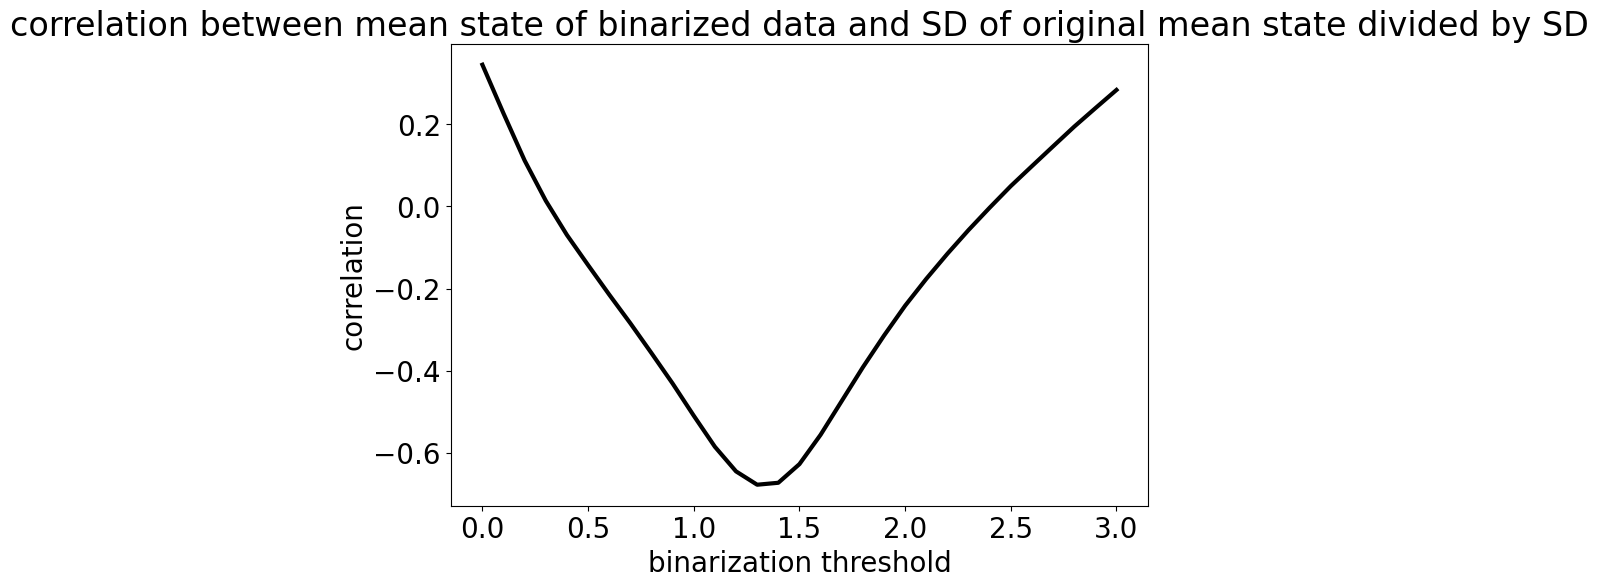

In [39]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.plot( threshold_np, depytorch(std_mean_over_std_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between mean state of binarized data and SD of original mean state divided by SD')
plt.show()

In [18]:
data_z = data_ts
data_z -= individual_mean.unsqueeze(dim=-1)
data_z /= individual_std.unsqueeze(dim=-1)
data_z.pow_(3.0)
data_skewness = data_z.mean( dim=(0,1,3) )
print( data_skewness.size() )

torch.Size([360])


In [24]:
torch.save( obj=data_skewness, f=os.path.join(file_dir, 'group_data_skewness.pt') )

In [22]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)

In [23]:
skewness_binarized_state_corr = isingmodellight.get_pairwise_correlation( mat1=mean_state_binarized, mat2=data_skewness.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(skewness_binarized_state_corr)

tensor([-0.9503, -0.8486, -0.7061, -0.5712, -0.4527, -0.3471, -0.2473, -0.1463,
        -0.0358,  0.0868,  0.2275,  0.3862,  0.5560,  0.7136,  0.8398,  0.9179,
         0.9464,  0.9405,  0.9151,  0.8799,  0.8410,  0.8009,  0.7603,  0.7194,
         0.6784,  0.6385,  0.5992,  0.5591,  0.5197,  0.4825,  0.4424],
       device='cuda:0')


In [47]:
torch.save( obj=skewness_binarized_state_corr, f=os.path.join(file_dir, 'skewness_binarized_state_corr.pt') )

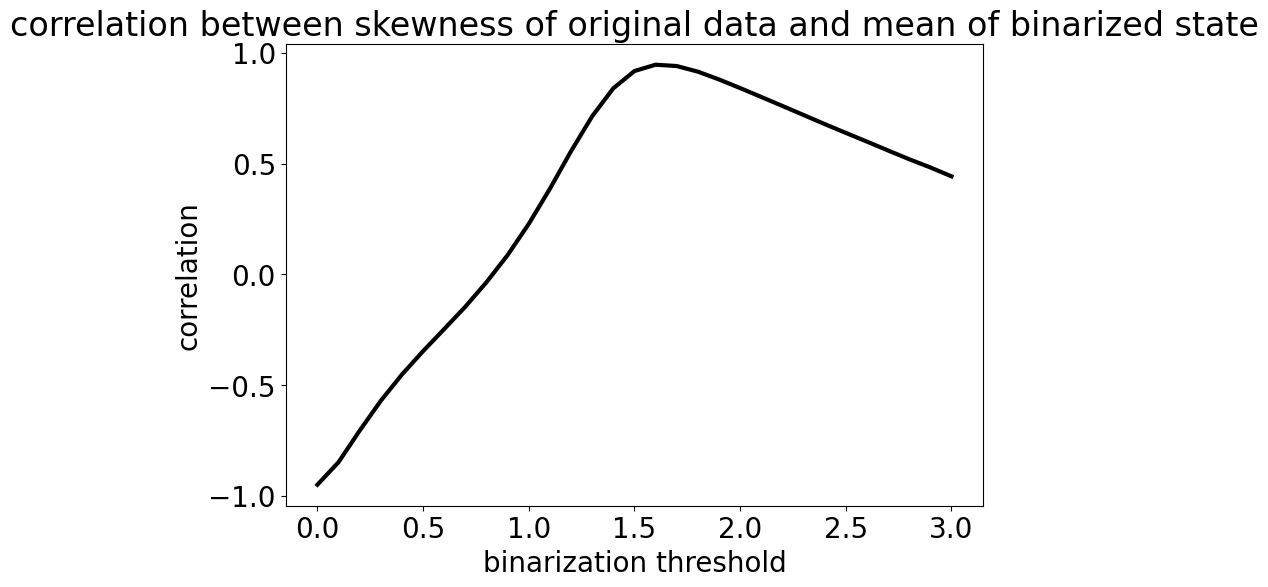

In [43]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
line_width=3.0
axs.plot( depytorch(threshold), depytorch(skewness_binarized_state_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between skewness of original data and mean of binarized state')
plt.show()

In [13]:
data_z = data_ts
data_z -= individual_mean.unsqueeze(dim=-1)
data_z /= individual_std.unsqueeze(dim=-1)
data_z.pow_(4.0)
data_kurtosis = data_z.mean( dim=(0,1,3) )
print( data_kurtosis.size() )

torch.Size([360])


In [23]:
torch.save( obj=data_kurtosis, f=os.path.join(file_dir, 'group_data_kurtosis.pt') )

In [14]:
kurtosis_binarized_state_corr = isingmodellight.get_pairwise_correlation( mat1=mean_state_binarized, mat2=data_kurtosis.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(kurtosis_binarized_state_corr)

tensor([ 0.3670,  0.0744, -0.1591, -0.3283, -0.4541, -0.5531, -0.6382, -0.7147,
        -0.7879, -0.8562, -0.9171, -0.9609, -0.9728, -0.9370, -0.8473, -0.7133,
        -0.5626, -0.4147, -0.2830, -0.1677, -0.0683,  0.0180,  0.0939,  0.1628,
         0.2263,  0.2824,  0.3345,  0.3825,  0.4282,  0.4668,  0.5061],
       device='cuda:0')


In [16]:
torch.save( obj=kurtosis_binarized_state_corr, f=os.path.join(file_dir, 'kurtosis_binarized_state_corr.pt') )

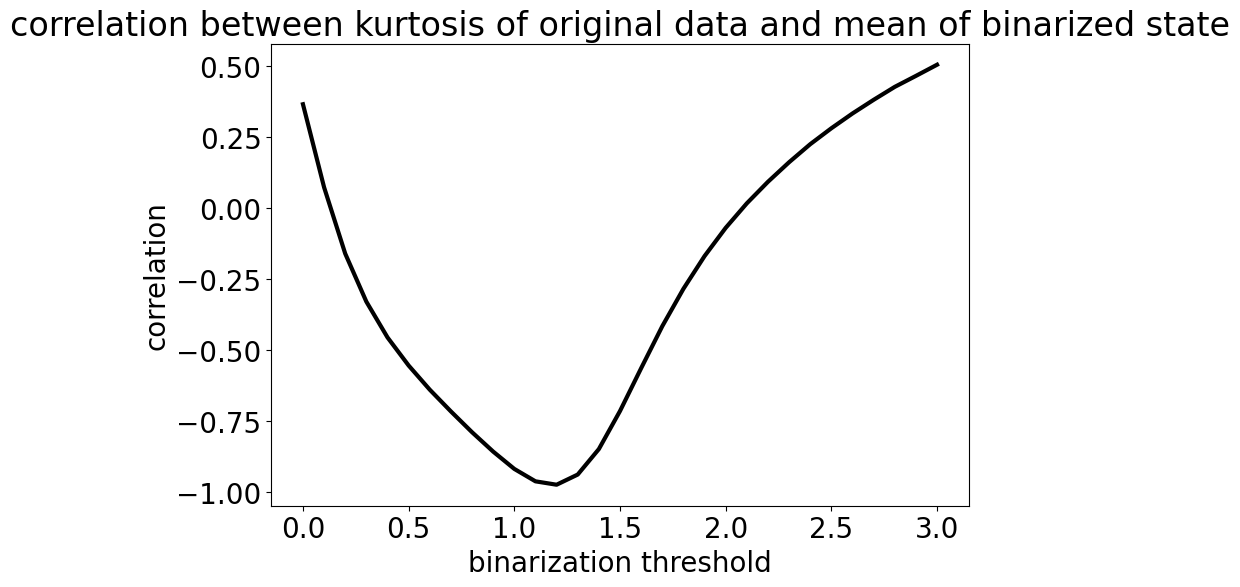

In [15]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
line_width=3.0
axs.plot( depytorch(threshold), depytorch(kurtosis_binarized_state_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between kurtosis of original data and mean of binarized state')
plt.show()

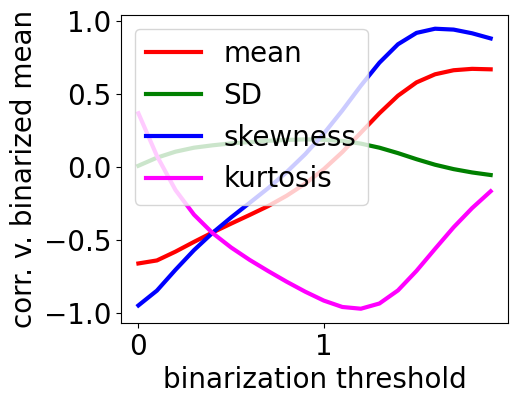

In [24]:
corr_file_names = ['mean_state_original_binarized_corr.pt', 'std_state_original_binarized_corr.pt', 'skewness_binarized_state_corr.pt', 'kurtosis_binarized_state_corr.pt']
corr_names = ['mean', 'SD', 'skewness', 'kurtosis']
corr_colors = ['red', 'green', 'blue', 'magenta']
line_width=3.0
max_thresh_index = 20
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
for corr_file_name, corr_name, corr_color in zip(corr_file_names, corr_names, corr_colors):
    moment_mean_corr = torch.load( f=os.path.join(file_dir, corr_file_name), weights_only=False )
    axs.plot( depytorch(threshold[:max_thresh_index]), depytorch(moment_mean_corr[:max_thresh_index]), color=corr_color, linewidth=line_width, label=corr_name )
axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. v. binarized mean')
# axs.set_title('correlation between continuous data Nth moment and binarized mean')
plt.show()

In [19]:
print( h.size(), moment.size(), moment_h_corr.size(), threshold.size() )

torch.Size([31, 360]) torch.Size([360]) torch.Size([31]) torch.Size([31])


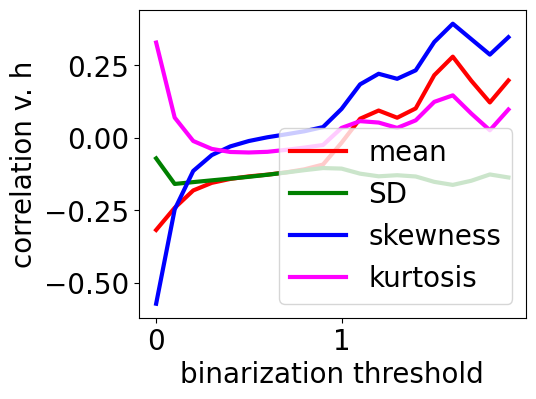

In [25]:
corr_names = ['mean', 'SD', 'skewness', 'kurtosis']
corr_colors = ['red', 'green', 'blue', 'magenta']
line_width=3.0
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
for corr_name, corr_color in zip(corr_names, corr_colors):
    moment = torch.load( f=os.path.join(file_dir, f'group_data_{corr_name}.pt'), weights_only=False )
    moment_h_corr =  isingmodellight.get_pairwise_correlation( mat1=h, mat2=moment.unsqueeze(dim=0), epsilon=0, dim=-1 )
    axs.plot( depytorch(threshold[:max_thresh_index]), depytorch(moment_h_corr[:max_thresh_index]), color=corr_color, linewidth=line_width, label=corr_name )
axs.legend(loc='lower right')
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation v. h')
# axs.set_title('correlation between continuous data Nth moment and binarized mean')
plt.show()

In [30]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
moment_names = ['mean', 'SD', 'skewness', 'kurtosis']
moment_tensor = torch.stack(  [ torch.load( f=os.path.join(file_dir, f'group_data_{moment_name}.pt'), weights_only=False ) for moment_name in moment_names ], dim=-1  )
moment_feature_corrs = isingmodellight.get_pairwise_correlation( mat1=moment_tensor.unsqueeze(dim=1), mat2=mean_node_features.unsqueeze(dim=2), epsilon=0.0, dim=0 )
print(moment_feature_corrs)
print( 'feature\t'+'\t'.join(moment_names) )
for feature_index in range( len(feature_names) ):
    print( feature_names[feature_index]+'\t'+'\t'.join([ f'{c:.3g}' for c in moment_feature_corrs[feature_index,:] ]) )

tensor([[-0.0194, -0.0645, -0.2633,  0.1907],
        [ 0.3985,  0.1265,  0.3277, -0.0498],
        [-0.2206, -0.1870, -0.2602,  0.1382],
        [-0.2865, -0.1957, -0.2691,  0.0962]], device='cuda:0')
feature	mean	SD	skewness	kurtosis
thickness	-0.0194	-0.0645	-0.263	0.191
myelination	0.398	0.127	0.328	-0.0498
curvature	-0.221	-0.187	-0.26	0.138
sulcus depth	-0.286	-0.196	-0.269	0.0962


h-mean = 0.427 at 2.9, h-thickness = -0.36 at 2.1, mean-thickness = -0.0194
h-SD = -0.162 at 1.6, h-thickness = -0.36 at 2.1, SD-thickness = -0.0645
h-skewness = -0.572 at 0, h-thickness = -0.36 at 2.1, skewness-thickness = -0.263
h-kurtosis = 0.415 at 3, h-thickness = -0.36 at 2.1, kurtosis-thickness = 0.191
h-mean = 0.427 at 2.9, h-myelination = 0.527 at 2.1, mean-myelination = 0.398
h-SD = -0.162 at 1.6, h-myelination = 0.527 at 2.1, SD-myelination = 0.127
h-skewness = -0.572 at 0, h-myelination = 0.527 at 2.1, skewness-myelination = 0.328
h-kurtosis = 0.415 at 3, h-myelination = 0.527 at 2.1, kurtosis-myelination = -0.0498
h-mean = 0.427 at 2.9, h-curvature = -0.213 at 2.3, mean-curvature = -0.221
h-SD = -0.162 at 1.6, h-curvature = -0.213 at 2.3, SD-curvature = -0.187
h-skewness = -0.572 at 0, h-curvature = -0.213 at 2.3, skewness-curvature = -0.26
h-kurtosis = 0.415 at 3, h-curvature = -0.213 at 2.3, kurtosis-curvature = 0.138
h-mean = 0.427 at 2.9, h-sulcus depth = -0.287 at 1.6

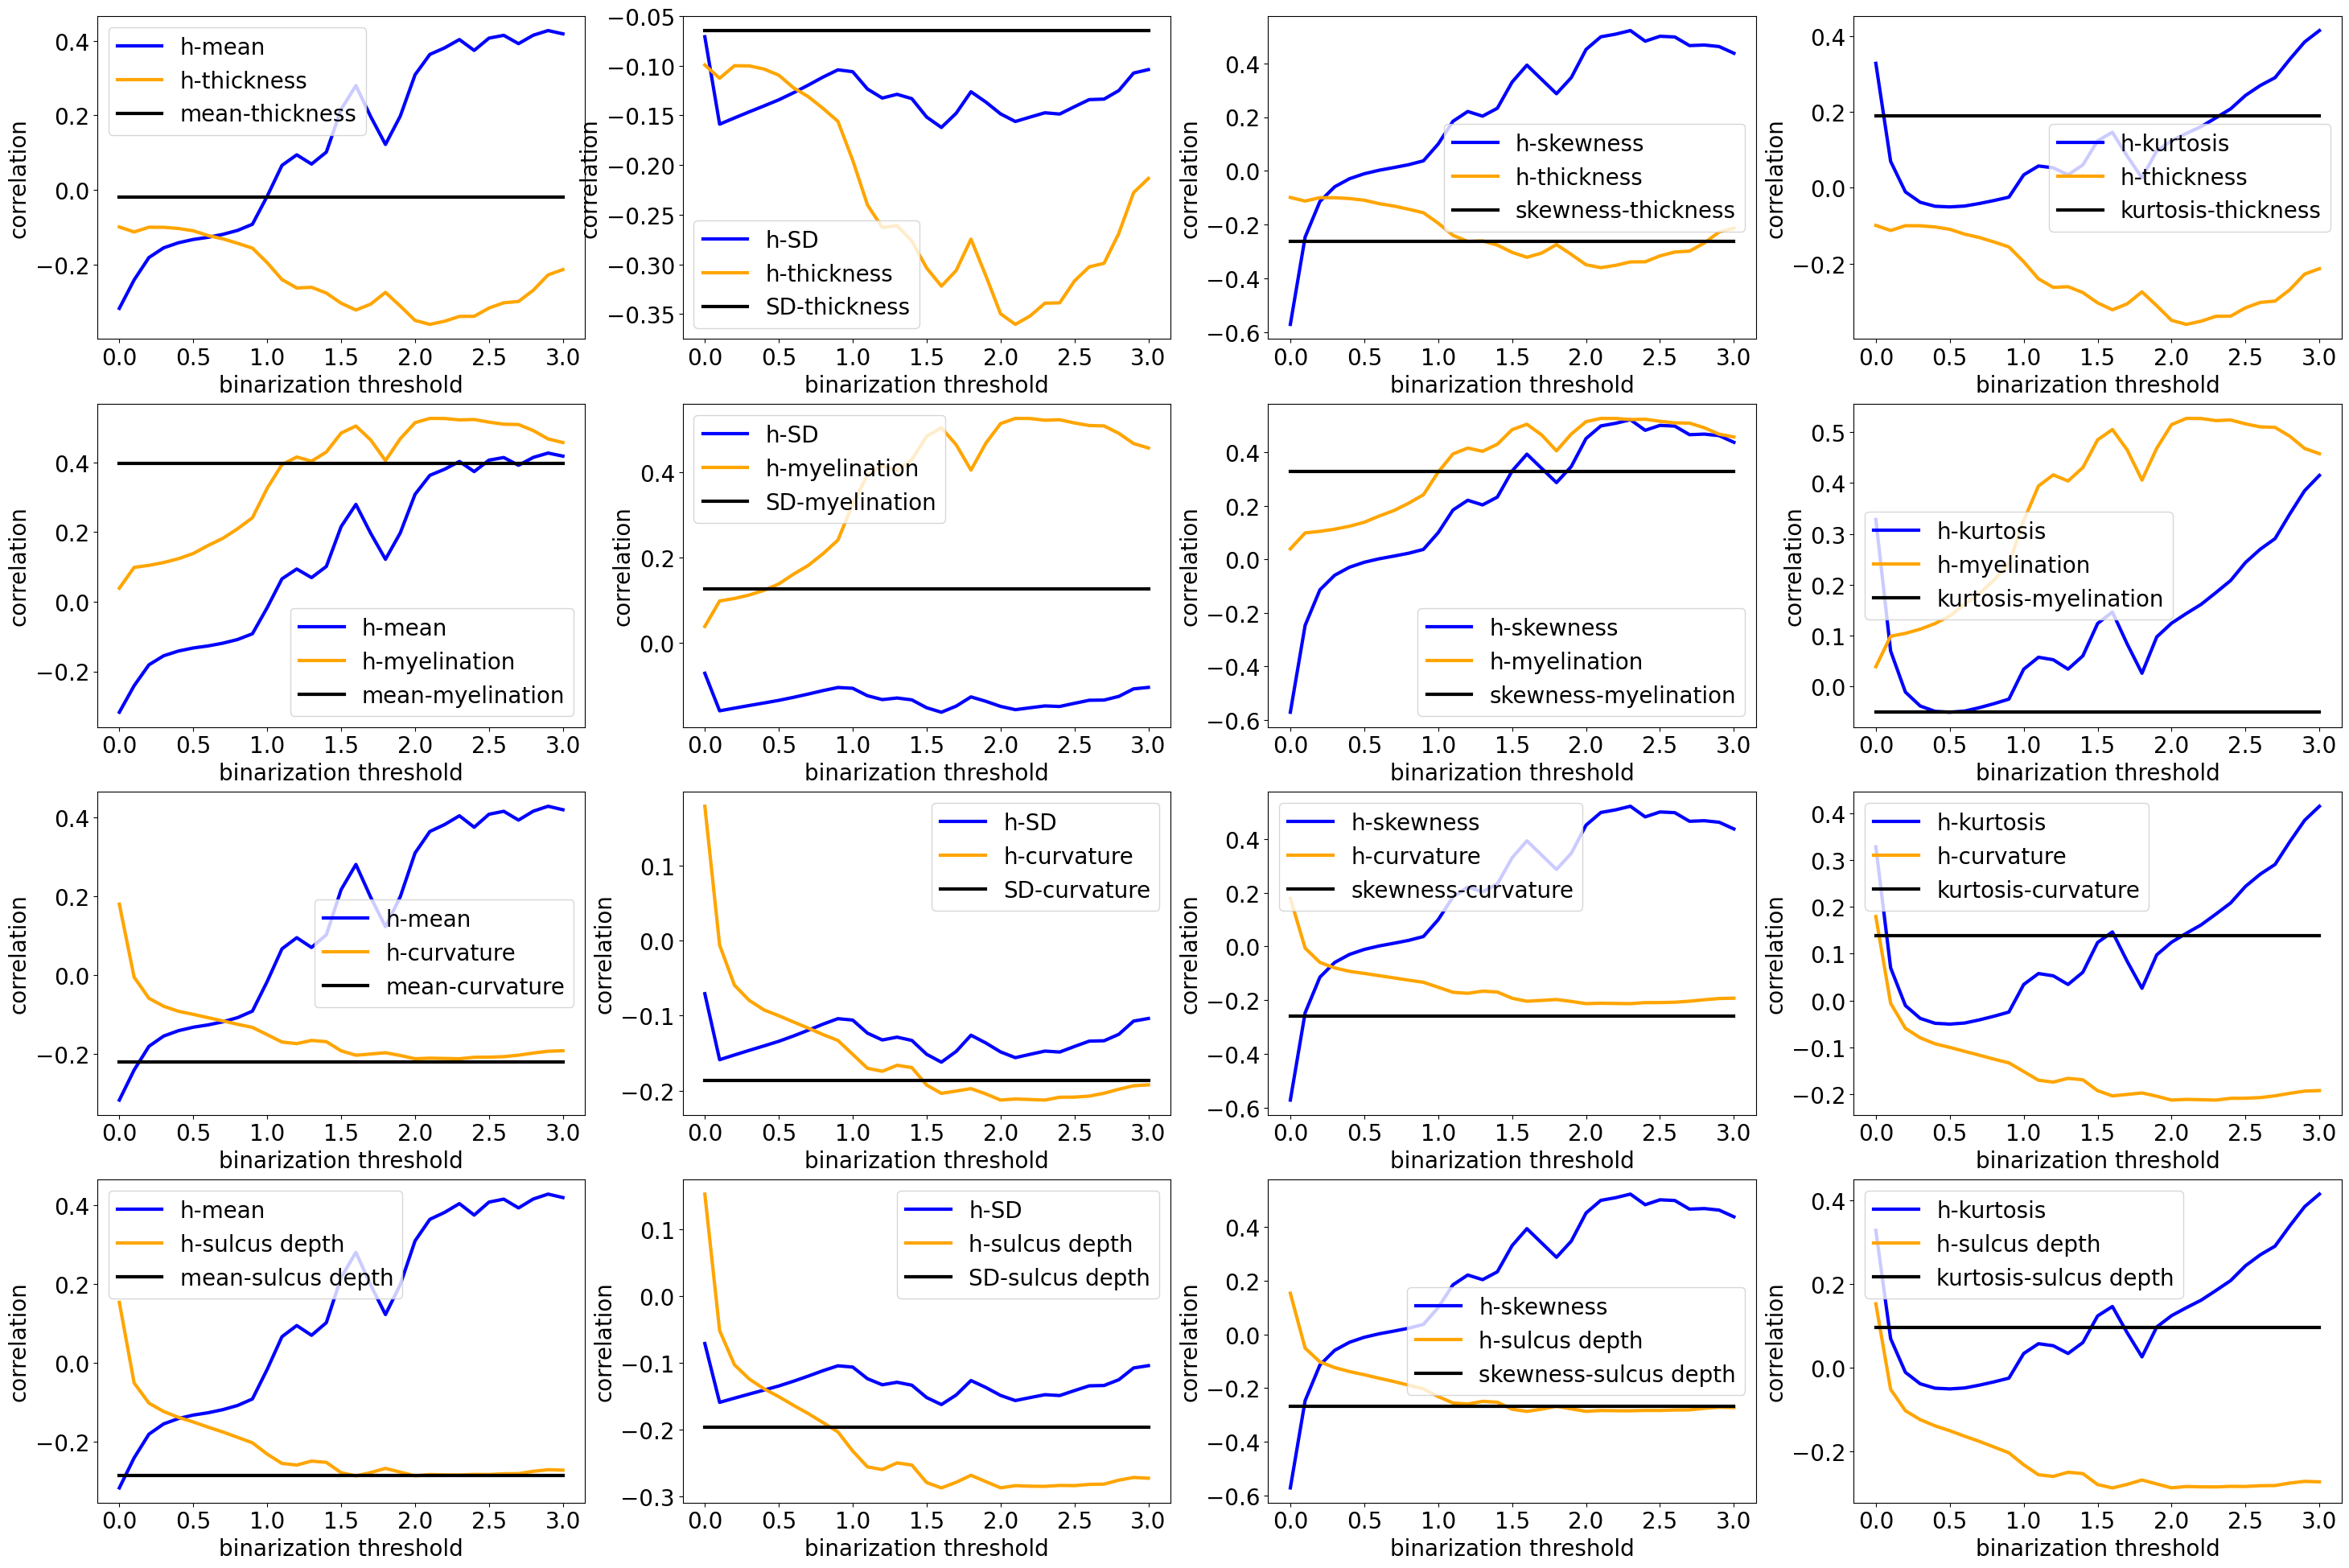

In [36]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names)
moment_names = ['mean', 'SD', 'skewness', 'kurtosis']
num_moments = len(moment_names)
moment_colors = ['red', 'green', 'blue', 'magenta']
line_width=3.0
fig, axs = plt.subplots( nrows=4, ncols=4, figsize=(36, 24) )
for feature_name, feature_index in zip( feature_names, range(num_features) ):
    for moment_name, moment_index in zip( moment_names, range(num_moments) ):
        moment_h_corr =  isingmodellight.get_pairwise_correlation( mat1=h, mat2=moment_tensor[:,moment_index].unsqueeze(dim=0), epsilon=0, dim=-1 )
        max_moment_h_corr_index = torch.argmax( moment_h_corr.abs() )
        max_moment_h_corr = moment_h_corr[max_moment_h_corr_index]
        max_moment_h_corr_threshold = threshold[max_moment_h_corr_index]
        feature_h_corr =  isingmodellight.get_pairwise_correlation( mat1=h, mat2=mean_node_features[:,feature_index].unsqueeze(dim=0), epsilon=0, dim=-1 )
        max_feature_h_corr_index = torch.argmax( feature_h_corr.abs() )
        max_feature_h_corr = feature_h_corr[max_feature_h_corr_index]
        max_feature_h_corr_threshold = threshold[max_feature_h_corr_index]
        mfc = moment_feature_corrs[feature_index, moment_index]
        moment_feature_corr = torch.full_like( threshold, fill_value=mfc )
        print(f'h-{moment_name} = {max_moment_h_corr:.3g} at {max_moment_h_corr_threshold:.3g}, h-{feature_name} = {max_feature_h_corr:.3g} at {max_feature_h_corr_threshold:.3g}, {moment_name}-{feature_name} = {mfc:.3g}')
        ax = axs[feature_index, moment_index]
        ax.plot( depytorch(threshold), depytorch(moment_h_corr), color='blue', linewidth=line_width, label=f'h-{moment_name}' )
        ax.plot( depytorch(threshold), depytorch(feature_h_corr), color='orange', linewidth=line_width, label=f'h-{feature_name}' )
        ax.plot( depytorch(threshold), depytorch(moment_feature_corr), color='black', linewidth=line_width, label=f'{moment_name}-{feature_name}' )
        # ax.legend(loc='lower right')
        ax.legend()
        ax.set_xlabel('binarization threshold')
        ax.set_ylabel('correlation')
plt.show()

In [70]:
kurtosis_state_corr_max_index = kurtosis_binarized_state_corr.abs().argmax()
print( threshold[kurtosis_state_corr_max_index].item(), kurtosis_binarized_state_corr[kurtosis_state_corr_max_index].item() )

1.2000000476837158 -0.9728095531463623


In [23]:
mean_h_corr = isingmodellight.get_pairwise_correlation( mat1=h, mat2=data_ts_mean.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(mean_h_corr)

tensor([-0.3174, -0.2412, -0.1812, -0.1551, -0.1415, -0.1327, -0.1269, -0.1190,
        -0.1084, -0.0920, -0.0168,  0.0660,  0.0942,  0.0694,  0.1015,  0.2160,
         0.2799,  0.1967,  0.1221,  0.1979,  0.3088,  0.3634,  0.3810,  0.4033,
         0.3742,  0.4071,  0.4146,  0.3923,  0.4150,  0.4274,  0.4186],
       device='cuda:0')


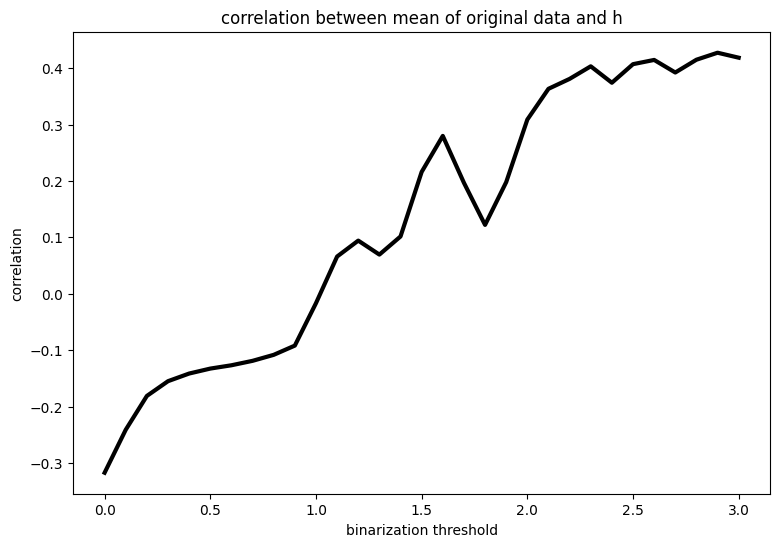

In [24]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
line_width=3.0
axs.plot( depytorch(threshold), depytorch(mean_h_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between mean of original data and h')
plt.show()

In [21]:
std_h_corr = isingmodellight.get_pairwise_correlation( mat1=h, mat2=data_ts_std.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(std_h_corr)

tensor([-0.0708, -0.1588, -0.1525, -0.1464, -0.1404, -0.1343, -0.1271, -0.1194,
        -0.1113, -0.1041, -0.1060, -0.1234, -0.1325, -0.1287, -0.1331, -0.1516,
        -0.1621, -0.1478, -0.1262, -0.1365, -0.1484, -0.1561, -0.1516, -0.1473,
        -0.1486, -0.1412, -0.1341, -0.1336, -0.1249, -0.1073, -0.1038],
       device='cuda:0')


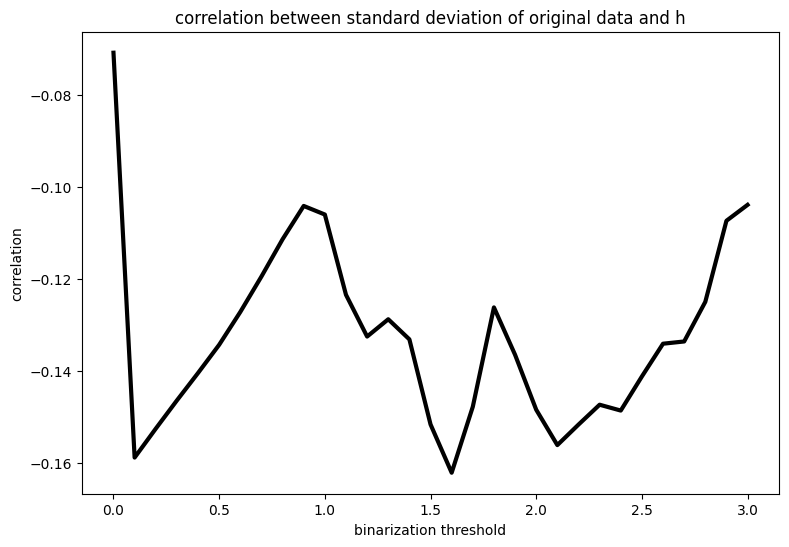

In [22]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
line_width=3.0
axs.plot( depytorch(threshold), depytorch(std_h_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between standard deviation of original data and h')
plt.show()

In [22]:
skewness_h_corr = isingmodellight.get_pairwise_correlation( mat1=h, mat2=data_skewness.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(skewness_h_corr)

tensor([-0.5717, -0.2467, -0.1140, -0.0594, -0.0295, -0.0109,  0.0020,  0.0121,
         0.0228,  0.0371,  0.0998,  0.1844,  0.2209,  0.2036,  0.2328,  0.3304,
         0.3934,  0.3401,  0.2870,  0.3469,  0.4518,  0.4989,  0.5087,  0.5221,
         0.4825,  0.5009,  0.4983,  0.4661,  0.4683,  0.4626,  0.4376],
       device='cuda:0')


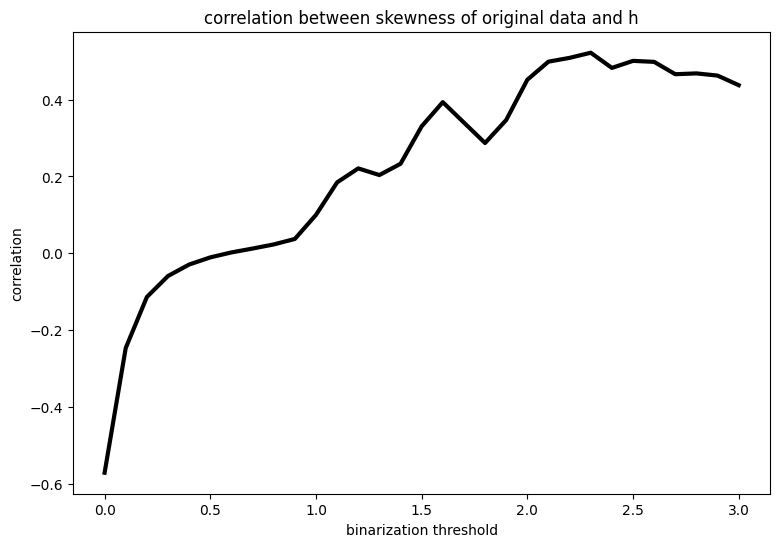

In [23]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
line_width=3.0
axs.plot( depytorch(threshold), depytorch(skewness_h_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between skewness of original data and h')
plt.show()

In [19]:
kurtosis_h_corr = isingmodellight.get_pairwise_correlation( mat1=h, mat2=data_kurtosis.unsqueeze(dim=0), epsilon=0, dim=-1 )
print(kurtosis_h_corr)

tensor([ 0.3284,  0.0699, -0.0108, -0.0381, -0.0486, -0.0504, -0.0481, -0.0414,
        -0.0335, -0.0246,  0.0342,  0.0576,  0.0528,  0.0343,  0.0604,  0.1240,
         0.1465,  0.0837,  0.0262,  0.0976,  0.1246,  0.1436,  0.1616,  0.1847,
         0.2085,  0.2438,  0.2700,  0.2907,  0.3393,  0.3850,  0.4150],
       device='cuda:0')


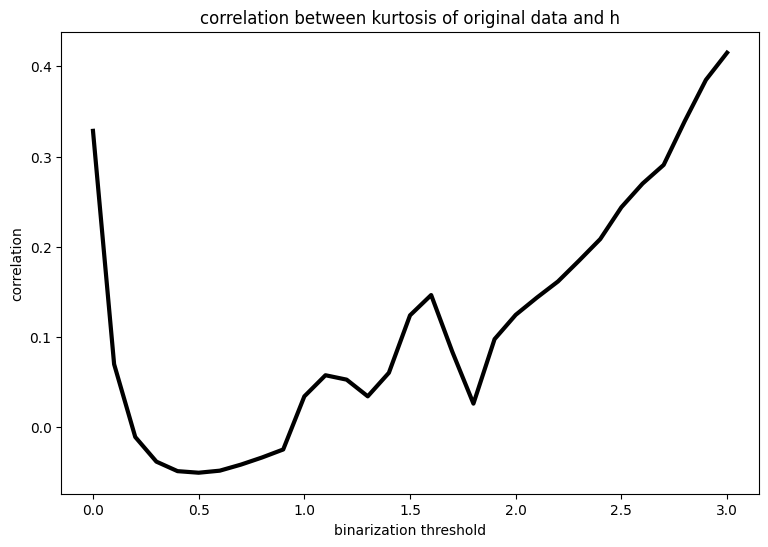

In [20]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
line_width=3.0
axs.plot( depytorch(threshold), depytorch(kurtosis_h_corr), color=cval, linewidth=line_width, label=f'corr' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between kurtosis of original data and h')
plt.show()

In [17]:
mean_node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False ).mean(dim=0)[:,:4]
print( 'node features size', mean_node_features.size() )

node features size torch.Size([360, 4])


In [32]:
mean_features_corr = isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=data_ts_mean.unsqueeze(dim=-1), epsilon=0, dim=0 ).flatten()
print(mean_features_corr)

tensor([-0.0194,  0.3985, -0.2206, -0.2865], device='cuda:0')


In [30]:
std_features_corr = isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=data_ts_std.unsqueeze(dim=-1), epsilon=0, dim=0 ).flatten()
print(std_features_corr)

tensor([-0.0645,  0.1265, -0.1870, -0.1957], device='cuda:0')


In [18]:
skewness_features_corr = isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=data_skewness.unsqueeze(dim=-1), epsilon=0, dim=0 ).flatten()
print(skewness_features_corr)

tensor([-0.2633,  0.3277, -0.2602, -0.2691], device='cuda:0')


In [65]:
kurtosis_features_corr = isingmodellight.get_pairwise_correlation( mat1=mean_node_features, mat2=data_kurtosis.unsqueeze(dim=-1), epsilon=0, dim=0 ).flatten()
print(kurtosis_features_corr)

tensor([ 0.1907, -0.0498,  0.1382,  0.0962], device='cuda:0')


In [ ]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.plot( threshold_np, depytorch(mean_state_original_binarized_corr), color=cval, linewidth=line_width, label=f'median' )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_title('correlation between original and binarized mean states')
plt.show()

Text(0.5, 0, 'unbinarized mean state')

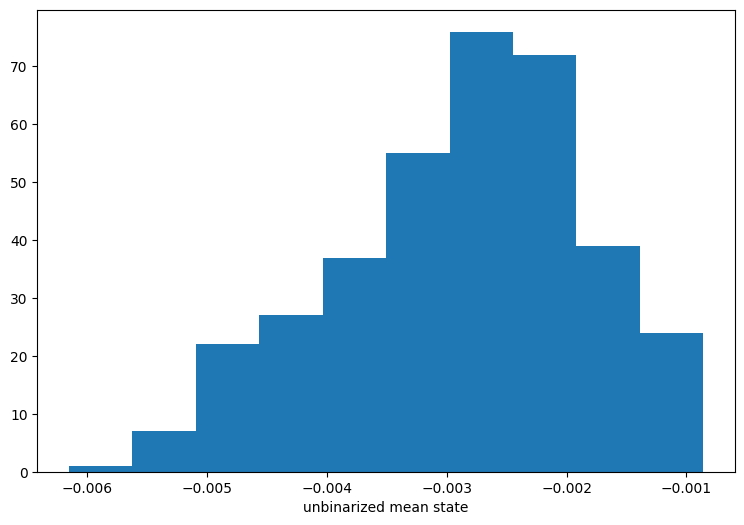

In [56]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.hist(  depytorch( mean_state_original.flatten() )  )
axs.set_xlabel('unbinarized mean state')

Text(0.5, 0, 'mean state for threshold 0')

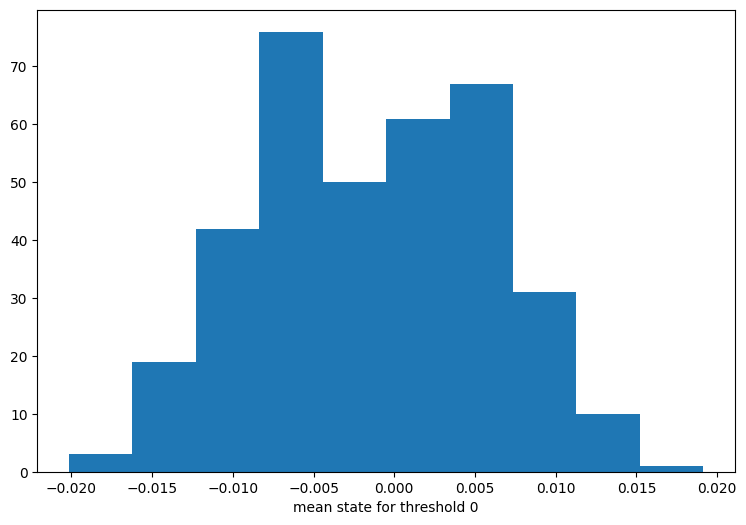

In [61]:
min_mean_state_corr_index = mean_state_original_binarized_corr.argmin()
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.hist(  depytorch( mean_state_binarized[min_mean_state_corr_index,:] )  )
axs.set_xlabel(f'mean state for threshold {threshold[min_mean_state_corr_index]:.3g}')

Text(0.5, 0, 'mean state for threshold 1.7')

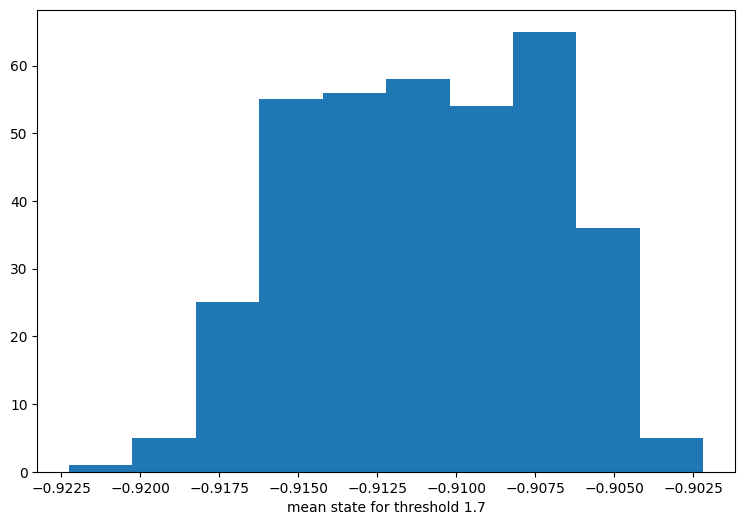

In [62]:
max_mean_state_corr_index = mean_state_original_binarized_corr.argmax()
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.hist(  depytorch( mean_state_binarized[max_mean_state_corr_index,:] )  )
axs.set_xlabel(f'mean state for threshold {threshold[max_mean_state_corr_index]:.3g}')

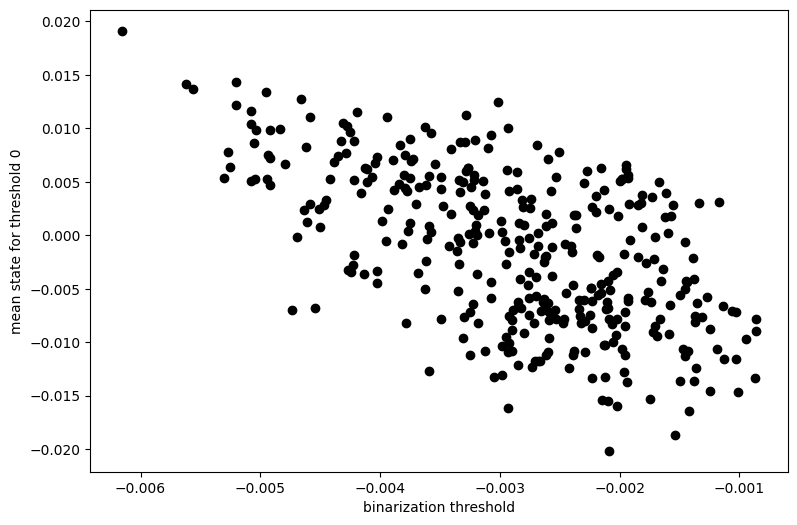

In [63]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.scatter(  depytorch( mean_state_original.flatten() ), depytorch(mean_state_binarized[min_mean_state_corr_index,:]), color=cval  )
axs.set_xlabel('binarization threshold')
axs.set_ylabel(f'mean state for threshold {threshold[min_mean_state_corr_index]:.3g}')
plt.show()

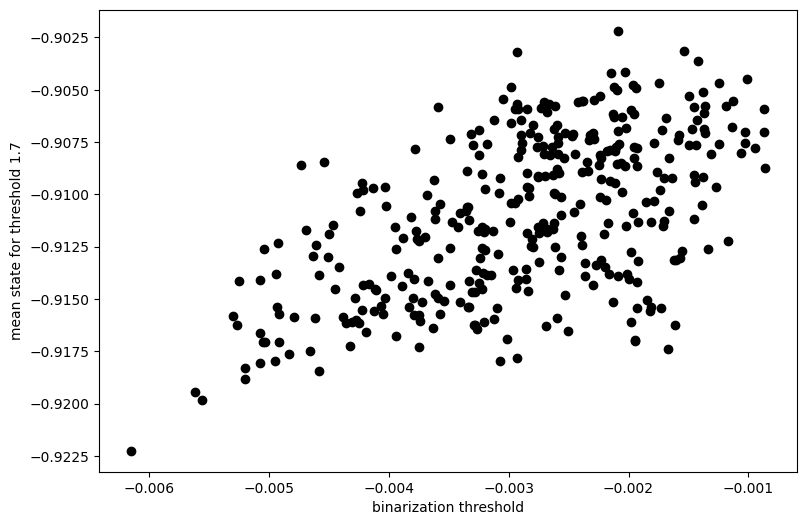

In [64]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
cval = [0.0, 0.0, 0.0]
axs.scatter(  depytorch( mean_state_original.flatten() ), depytorch(mean_state_binarized[max_mean_state_corr_index,:]), color=cval  )
axs.set_xlabel('binarization threshold')
axs.set_ylabel(f'mean state for threshold {threshold[max_mean_state_corr_index]:.3g}')
plt.show()

In [15]:
def write_node_file(file_name:str, coords:torch.Tensor, values_for_color:torch.Tensor=None, values_for_size:torch.Tensor=None, names:list=None):
    num_nodes = coords.size(dim=0)
    if type(values_for_color) == type(None):
        values_for_color = torch.zeros_like(coords[:,0])
    if type(values_for_size) == type(None):
        values_for_size = torch.ones_like(coords[:,0])
    if type(names) == type(None):
        names = ['-']*num_nodes
    node_lines = [ '\t'.join(['x', 'y', 'z', 'color', 'size', 'name'])+'\n' ] + [ '\t'.join([f'{x:.3g}', f'{y:.3g}', f'{z:.3g}', f'{c:.3g}', f'{s:.3g}', n])+'\n' for x, y, z, c, s, n in zip(coords[:,0], coords[:,1], coords[:,2], values_for_color, values_for_size, names) ]
    with open(file_name, 'w') as node_file:
        node_file.writelines(node_lines)

In [17]:
region_names, region_coords = hcp.load_roi_info( directory_path='D:\\HCP_data', dtype=float_type, device=device )
print( coords.size() )

torch.Size([360, 3])


In [130]:
print( h.size() )
print( h.min(), h.max() )

torch.Size([31, 360])
tensor(-34.4226, device='cuda:0') tensor(8.0793, device='cuda:0')


In [131]:
for target_threshold in [0.0, 1.0]:
    threshold_index = get_closest_match(values=threshold, target=target_threshold)
    current_threshold = threshold[threshold_index]
    current_h = h[threshold_index,:]
    print( current_h.min().item(), current_h.max().item() )
    node_file_name = os.path.join(file_dir, f'group_h_threshold_{current_threshold:.3g}.dlm')
    write_node_file(file_name=node_file_name, coords=region_coords, values_for_color=current_h, values_for_size=None, names=region_names)
    print(f'saved {node_file_name}')

-1.2833058834075928 1.2225583791732788
saved E:\Ising_model_results_daai\group_h_threshold_0.dlm
-20.209264755249023 6.756697654724121
saved E:\Ising_model_results_daai\group_h_threshold_1.dlm


In [124]:
print( mean_node_features.size() )
mean_node_features_std, mean_node_features_mean = torch.std_mean(mean_node_features, dim=0, keepdim=True)
mean_node_features_z = (mean_node_features - mean_node_features_mean)/mean_node_features_std
print( mean_node_features_z.min().item(), mean_node_features_z.max().item() )

torch.Size([360, 4])
-3.220640182495117 3.571580648422241


In [125]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'group_{feature_names[feature_index]}.dlm')
    write_node_file(file_name=node_file_name, coords=region_coords, values_for_color=mean_node_features_z[:,feature_index], values_for_size=None, names=region_names)
    print(f'saved {node_file_name}')

saved E:\Ising_model_results_daai\group_thickness.dlm
saved E:\Ising_model_results_daai\group_myelination.dlm
saved E:\Ising_model_results_daai\group_curvature.dlm
saved E:\Ising_model_results_daai\group_sulcus_depth.dlm


In [121]:
print( h_node_feature_corr_tensor.size() )
print( h_node_feature_corr_tensor.abs().max().item() )

torch.Size([360, 4])
0.4516258239746094


In [120]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'individual_corr_{feature_names[feature_index]}_{param_string}.dlm')
    write_node_file(file_name=node_file_name, coords=region_coords, values_for_color=h_node_feature_corr_tensor[:,feature_index], values_for_size=None, names=region_names)
    print(f'saved {node_file_name}')

saved E:\Ising_model_results_daai\individual_corr_thickness_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm
saved E:\Ising_model_results_daai\individual_corr_myelination_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm
saved E:\Ising_model_results_daai\individual_corr_curvature_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm
saved E:\Ising_model_results_daai\individual_corr_sulcus_depth_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm


In [116]:
print( h_node_feature_corr_is_significant.size() )

torch.Size([360, 4])


In [119]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'individual_corr_is_sig_{feature_names[feature_index]}_{param_string}.dlm')
    write_node_file(file_name=node_file_name, coords=region_coords, values_for_color=h_node_feature_corr_is_significant[:,feature_index], values_for_size=None, names=region_names)
    print(f'saved {node_file_name}')

saved E:\Ising_model_results_daai\individual_corr_is_sig_thickness_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm
saved E:\Ising_model_results_daai\individual_corr_is_sig_myelination_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm
saved E:\Ising_model_results_daai\individual_corr_is_sig_curvature_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm
saved E:\Ising_model_results_daai\individual_corr_is_sig_sulcus_depth_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm


In [13]:
node_feature_std = node_features.std(dim=0)

In [18]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
for feature_index in range( len(feature_names) ):
    node_file_name = os.path.join(file_dir, f'individual_std_{feature_names[feature_index]}.dlm')
    write_node_file(file_name=node_file_name, coords=region_coords, values_for_color=node_feature_std[:,feature_index], values_for_size=None, names=region_names)
    print(f'saved {node_file_name}')

saved E:\Ising_model_results_daai\individual_std_thickness.dlm
saved E:\Ising_model_results_daai\individual_std_myelination.dlm
saved E:\Ising_model_results_daai\individual_std_curvature.dlm
saved E:\Ising_model_results_daai\individual_std_sulcus_depth.dlm


In [19]:
h_std = h.std(dim=0)

In [20]:
node_file_name = os.path.join(file_dir, f'h_std_{param_string}.dlm')
write_node_file(file_name=node_file_name, coords=region_coords, values_for_color=h_std, values_for_size=None, names=region_names)
print(f'saved {node_file_name}')

saved E:\Ising_model_results_daai\h_std_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm


In [30]:
feature_index = 1
is_gt_pt1 = node_feature_std[:,feature_index] >= 0.075
print( region_names[depytorch(is_gt_pt1)] )
print( node_feature_std[is_gt_pt1,feature_index] )

['L_Pir' 'L_PreS' 'L_25' 'L_pOFC' 'R_Pir' 'R_PreS' 'R_25' 'R_pOFC']
tensor([0.1145, 0.1490, 0.0762, 0.3673, 0.1469, 0.1470, 0.1060, 0.4136],
       device='cuda:0')


In [32]:
feature_index = 1
is_gt_8 = h_std >= 7
print( region_names[depytorch(is_gt_8)] )
print( h_std[is_gt_8] )

['L_33pr' 'L_10pp' 'L_OFC' 'L_25' 'L_pOFC' 'R_10pp' 'R_OFC' 'R_Pir' 'R_25'
 'R_pOFC']
tensor([7.3644, 7.3750, 7.3831, 7.4219, 8.3795, 7.5431, 7.2134, 7.4386, 7.7699,
        8.2625], device='cuda:0')


In [47]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str, do_z:bool=True, num_perms:float=1000000):
    # We assume both Tensors are 1D and the same size.

    if do_z:
        feature_std, feature_mean = torch.std_mean(feature)
        feature_z = (feature - feature_mean)/feature_std
    else:
        feature_z = feature
    
    feature_z_and_1 = torch.stack(  ( feature_z, torch.ones_like(feature_z) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_z_and_1, param_col)
    param_pred = torch.matmul(feature_z_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    num_greater = 0
    num_values = feature.numel()
    corr_abs = corr.abs()
    for _ in range(num_perms):
        perm = torch.randperm( n=num_values, dtype=int_type, device=feature.device )
        perm_corr_abs = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature[perm], dim=0).abs()
        num_greater += (perm_corr_abs >= corr_abs)
    p_value = num_greater/num_perms
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}, corr.={corr:.3g}, p-value={p_value:.3g}')
    
    feature_z_np = depytorch(feature_z)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_z_np, param_np, color='blue')
    ax.plot(feature_z_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    if do_z:
        ax.set_xlabel(f'{feature_name} (z-score)')
    else:
        ax.set_xlabel(feature_name)
    ax.set_ylabel(f'{param_name}')

z(SD(h))=8.75SD(myelination)+4.87, R^2=0.115, corr.=0.338, p-value=0


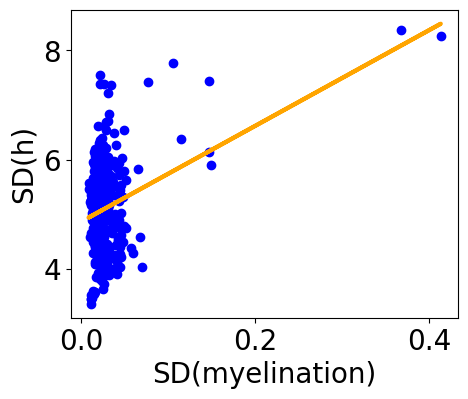

In [35]:
feature_index = 1
feature_name = feature_names[feature_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax=axs, feature=node_feature_std[:,feature_index], param=h_std, feature_name=f'SD({feature_name})', param_name='SD(h)', do_z=False, num_perms=1000)

SD(individual h)=8.09SD(thickness)+3.67, R^2=0.186, corr.=0.431, p-value=0
SD(individual h)=8.75SD(myelination)+4.87, R^2=0.115, corr.=0.338, p-value=0
SD(individual h)=-3.05SD(curvature)+5.23, R^2=0.00336, corr.=-0.0578, p-value=0.274
SD(individual h)=-2.19SD(sulcus depth)+5.5, R^2=0.0409, corr.=-0.202, p-value=0.000131


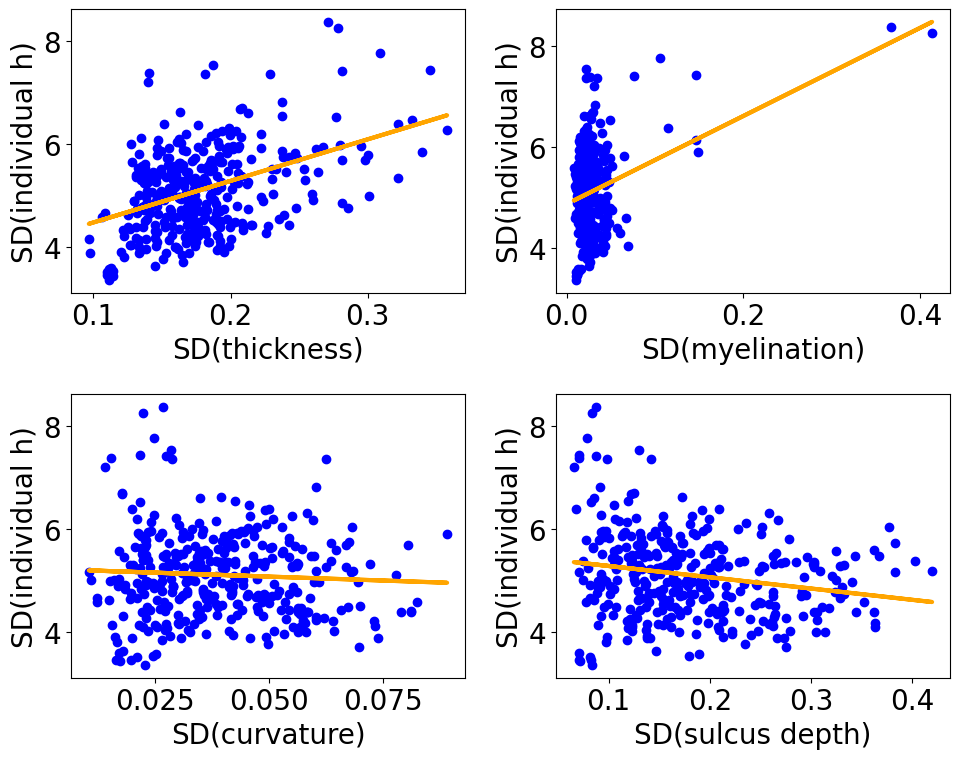

In [54]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
for feature_index, r, c in zip( range(4), [0,0,1,1], [0,1,0,1] ):
    feature_name = feature_names[feature_index]
    make_scatter_plot_with_regression_line(ax=axs[r,c], feature=node_feature_std[:,feature_index], param=h_std, feature_name=f'SD({feature_name})', param_name='SD(individual h)', do_z=False, num_perms=1000000)
fig.tight_layout()

In [52]:
J_std = J.std(dim=0)
sc_std = sc.std(dim=0)

SD(J)=142SD(SC)+4.14, R^2=0.186, corr.=0.432, p-value=0


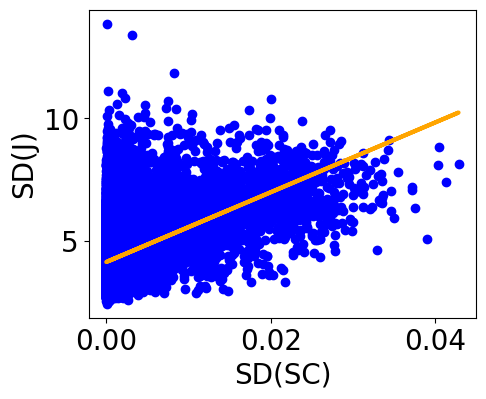

In [55]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax=axs, feature=sc_std, param=J_std, feature_name='SD(SC)', param_name='SD(J)', do_z=False, num_perms=1000000)

z(h-myelination correlation)=0.127SD(myelination)+0.00825, R^2=0.00254, corr.=0.0502, p-value=0.292


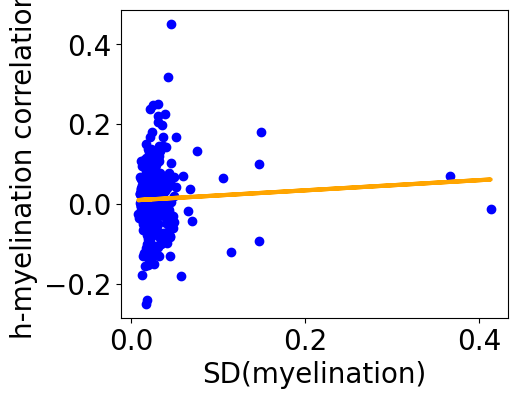

In [44]:
feature_index = 1
feature_name = feature_names[feature_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax=axs, feature=node_feature_std[:,feature_index], param=h_node_feature_corr_tensor[:,feature_index], feature_name=f'SD({feature_name})', param_name=f'h-{feature_name} correlation', do_z=False, num_perms=1000)

z(h)=-0.821thickness+-2.04, R^2=0.0383, corr.=-0.195
z(h)=1.37myelination+-2.04, R^2=0.107, corr.=0.326
z(h)=-0.638curvature+-2.04, R^2=0.0231, corr.=-0.152
z(h)=-0.975sulcus depth+-2.04, R^2=0.054, corr.=-0.232
z(J)=2.02SC+0.835, R^2=0.264, corr.=0.513
z(FC)=0.0254SC+0.223, R^2=0.0759, corr.=0.275


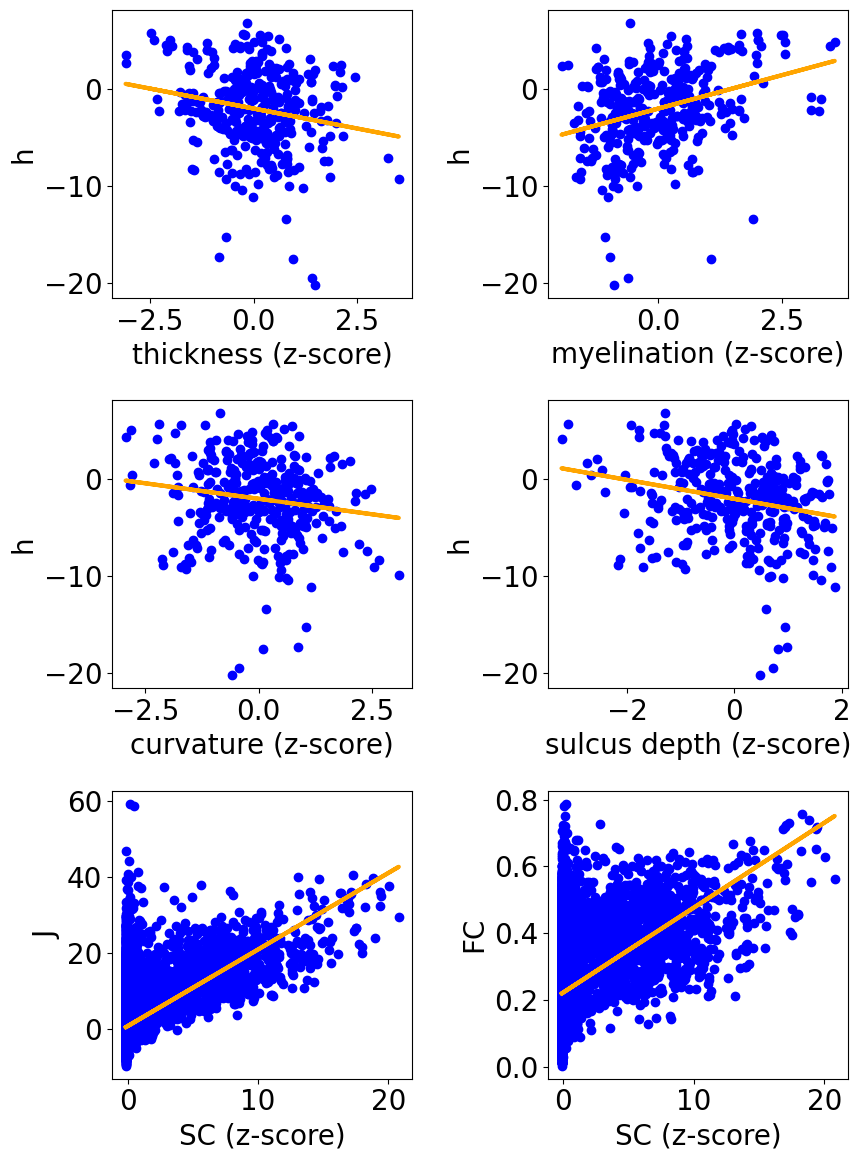

In [39]:
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
selected_h = h[selected_threshold_index,:]
selected_J = J[selected_threshold_index,:]
selected_fc = group_fc[selected_threshold_index,:]
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(9, 12) )
for feature_index, feature_name, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1]):
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=feature_name, param_name='h')
make_scatter_plot_with_regression_line(ax=axs[2,0], feature=mean_sc, param=selected_J, feature_name='SC', param_name='J')
make_scatter_plot_with_regression_line(ax=axs[2,1], feature=mean_sc, param=selected_fc, feature_name='SC', param_name='FC')
# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')
plt.tight_layout()
plt.show()

z(h (threshold=2.1))=-0.429thickness+-11.3, R^2=0.131, corr.=-0.36
z(h (threshold=2.1))=0.628myelination+-11.3, R^2=0.279, corr.=0.527
z(h (threshold=2.3))=-0.167curvature+-32.8, R^2=0.0455, corr.=-0.213
z(h (threshold=1.6))=-0.767sulcus depth+-14.2, R^2=0.0828, corr.=-0.287
z(J (threshold=0))=1.21SC+0.334, R^2=0.371, corr.=0.609
z(FC (threshold=3))=0.021SC+0.0879, R^2=0.137, corr.=0.37


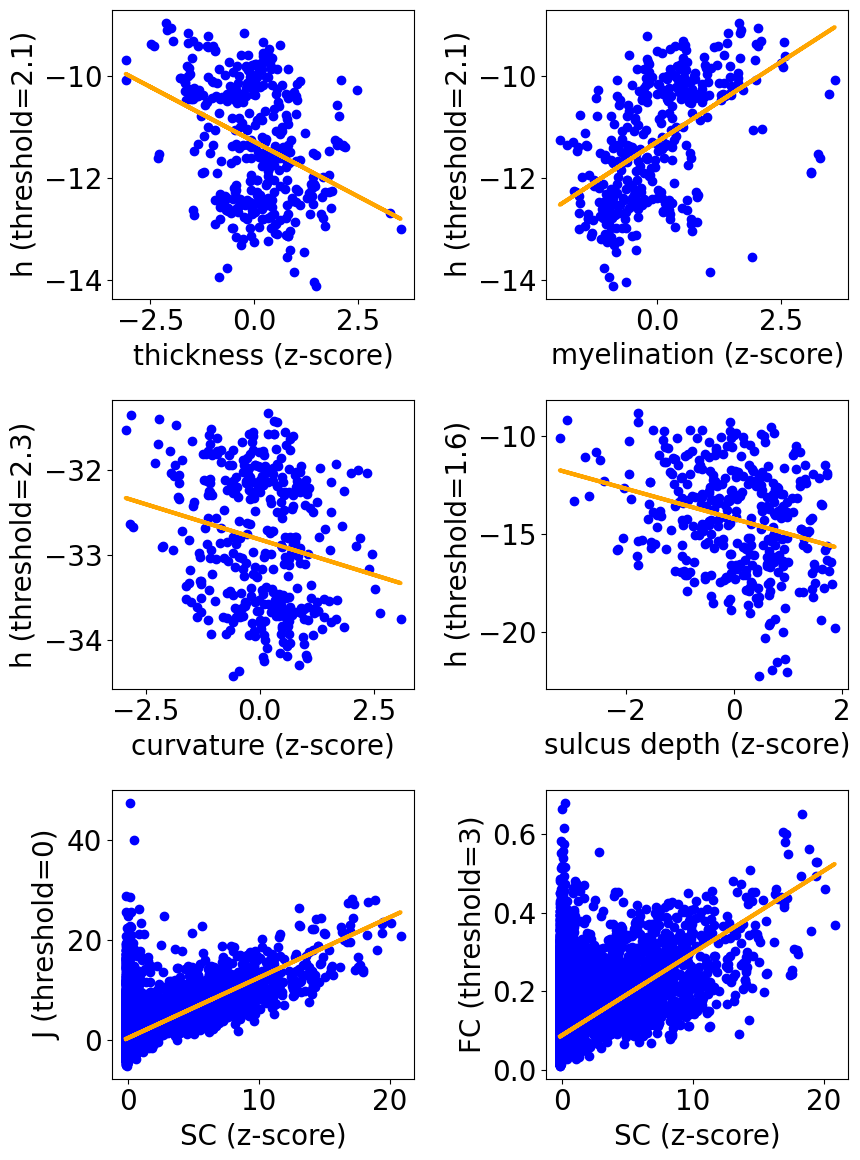

In [34]:
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(9, 12) )

for feature_index, feature_name, feature_row, feature_col, selected_threshold_index in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1], max_h_node_corr_index):
    selected_threshold = threshold[selected_threshold_index]
    selected_h = h[selected_threshold_index,:]
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=feature_name, param_name=f'h (threshold={selected_threshold:.3g})')

selected_threshold_index = torch.argmax( J_sc_corr.abs() )
selected_threshold = threshold[selected_threshold_index]
selected_J = J[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[2,0], feature=mean_sc, param=selected_J, feature_name='SC', param_name=f'J (threshold={selected_threshold:.3g})')

selected_threshold_index = torch.argmax( fc_sc_corr.abs() )
selected_threshold = threshold[selected_threshold_index]
selected_fc = group_fc[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[2,1], feature=mean_sc, param=selected_fc, feature_name='SC', param_name=f'FC (threshold={selected_threshold:.3g})')

# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')

plt.tight_layout()
plt.show()

z(h (threshold=2.1))=-0.429thickness+-11.3, R^2=0.131, corr.=-0.36
z(h (threshold=2.1))=0.628myelination+-11.3, R^2=0.279, corr.=0.527
z(h (threshold=2.3))=-0.167curvature+-32.8, R^2=0.0455, corr.=-0.213
z(h (threshold=1.6))=-0.767sulcus depth+-14.2, R^2=0.0828, corr.=-0.287
z(J (threshold=0))=1.21SC+0.334, R^2=0.371, corr.=0.609
z(FC (threshold=3))=0.021SC+0.0879, R^2=0.137, corr.=0.37


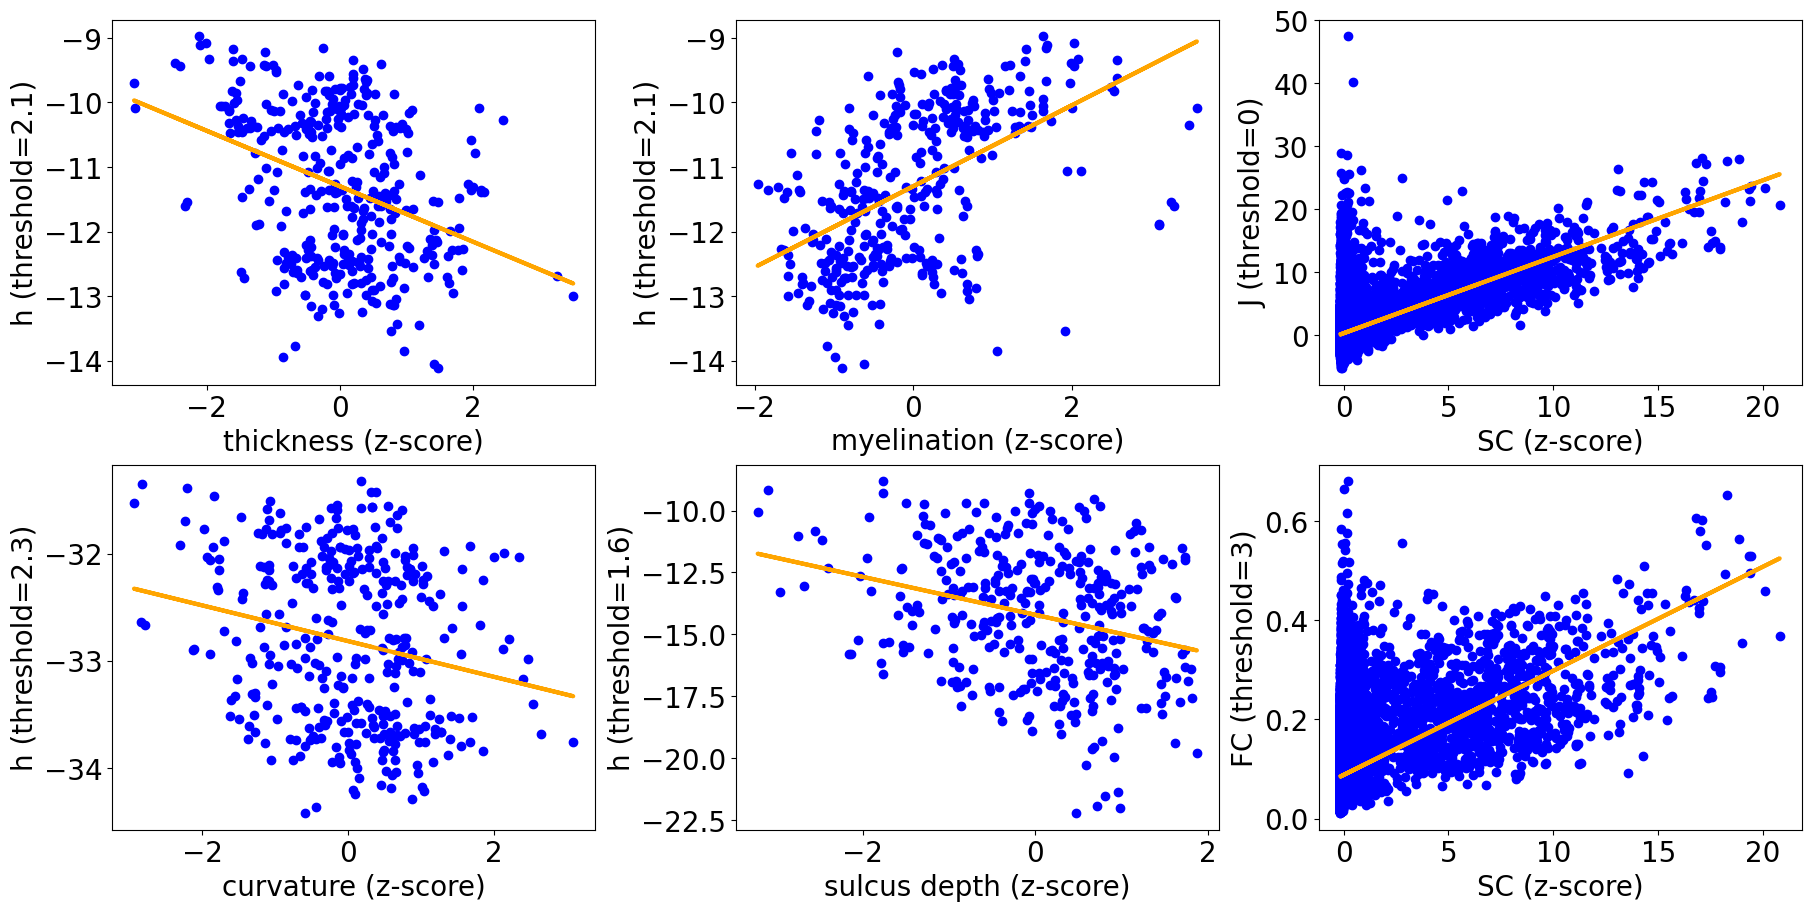

In [93]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(18, 9), layout='constrained' )

for feature_index, feature_name, feature_row, feature_col, selected_threshold_index in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1], max_h_node_corr_index):
    selected_threshold = threshold[selected_threshold_index]
    selected_h = h[selected_threshold_index,:]
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=feature_name, param_name=f'h (threshold={selected_threshold:.3g})')

selected_threshold_index = torch.argmax( J_sc_corr.abs() )
selected_threshold = threshold[selected_threshold_index]
selected_J = J[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[0,2], feature=mean_sc, param=selected_J, feature_name='SC', param_name=f'J (threshold={selected_threshold:.3g})')

selected_threshold_index = torch.argmax( fc_sc_corr.abs() )
selected_threshold = threshold[selected_threshold_index]
selected_fc = group_fc[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[1,2], feature=mean_sc, param=selected_fc, feature_name='SC', param_name=f'FC (threshold={selected_threshold:.3g})')

# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')

# plt.tight_layout()
plt.show()

z(h (threshold=1))=-0.821thickness+-2.04, R^2=0.0383, corr.=-0.195, p-value=0.000196
z(h (threshold=1))=1.37myelination+-2.04, R^2=0.107, corr.=0.326, p-value=0
z(h (threshold=1))=-0.638curvature+-2.04, R^2=0.0231, corr.=-0.152, p-value=0.00393
z(h (threshold=1))=-0.975sulcus depth+-2.04, R^2=0.054, corr.=-0.232, p-value=1.1e-05
z(J (threshold=1))=2.02SC+0.835, R^2=0.264, corr.=0.513, p-value=0
z(FC (threshold=1))=0.0254SC+0.223, R^2=0.0759, corr.=0.275, p-value=0


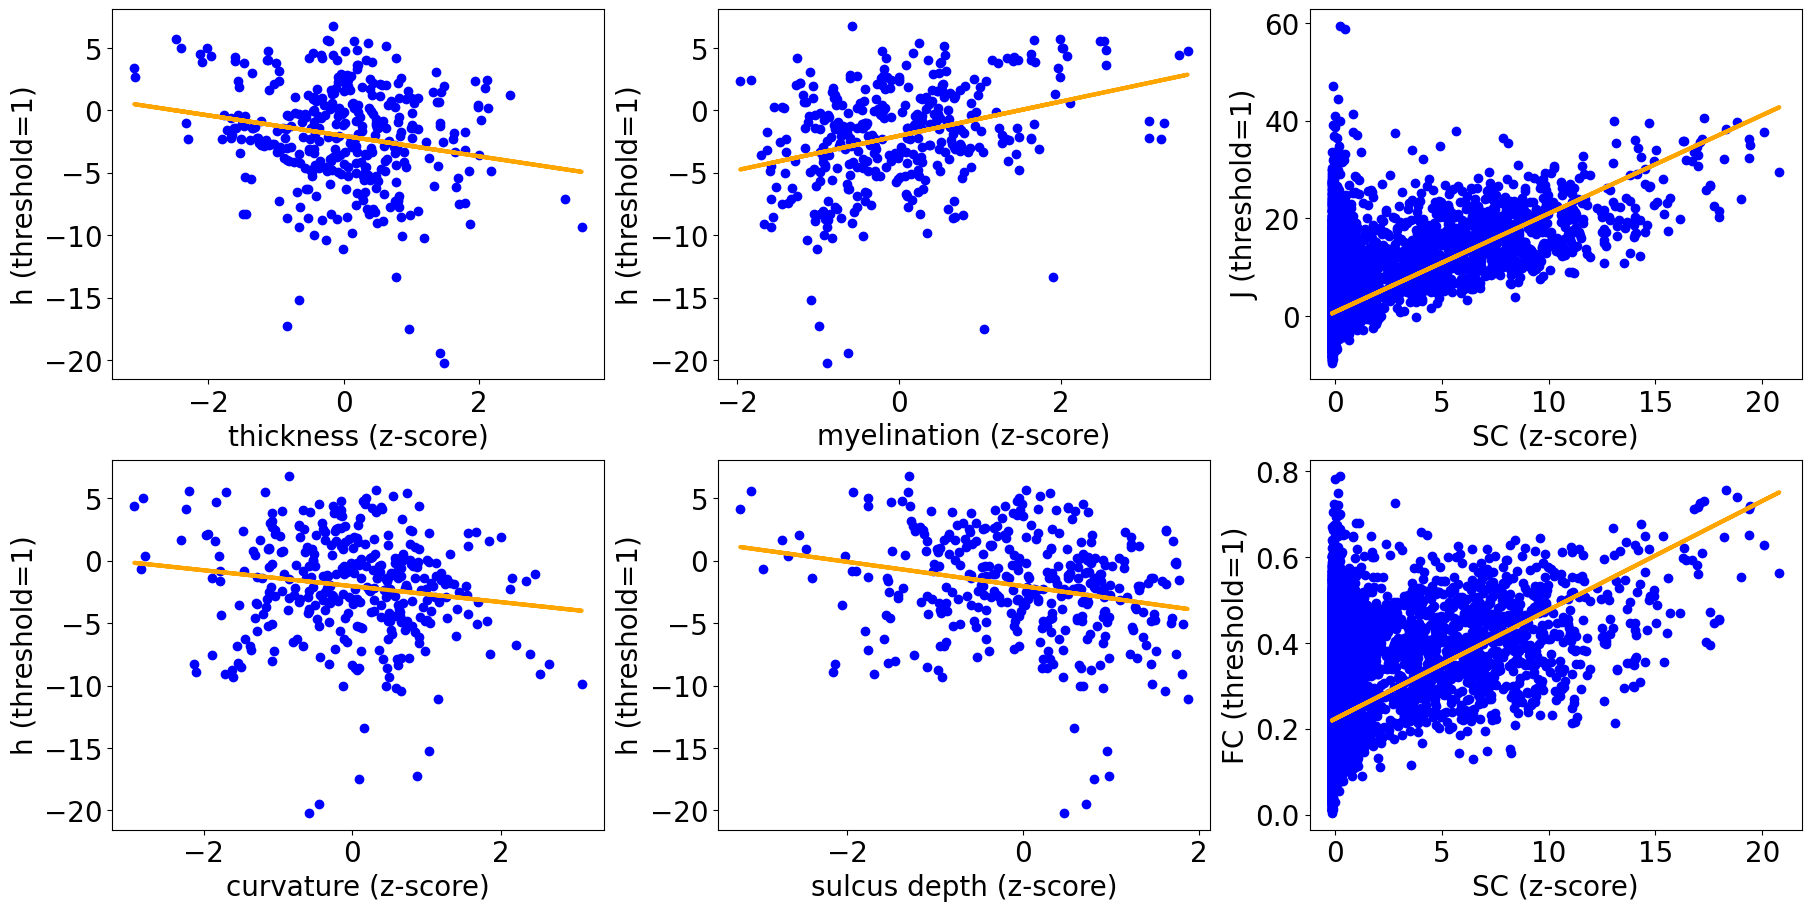

In [56]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(18, 9), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]

for feature_index, feature_name, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1]):
    selected_h = h[selected_threshold_index,:]
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=feature_name, param_name=f'h (threshold={selected_threshold:.3g})')

# selected_threshold_index = torch.argmax( J_sc_corr.abs() )
selected_J = J[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[0,2], feature=mean_sc, param=selected_J, feature_name='SC', param_name=f'J (threshold={selected_threshold:.3g})')

# selected_threshold_index = torch.argmax( fc_sc_corr.abs() )
selected_fc = group_fc[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[1,2], feature=mean_sc, param=selected_fc, feature_name='SC', param_name=f'FC (threshold={selected_threshold:.3g})')

# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')

# plt.tight_layout()
plt.show()

In [73]:
J_std = torch.std(J, dim=0)
print( J_std.size() )

torch.Size([64620])


In [74]:
fc_std = torch.std(fc, dim=0)
print( fc_std.size() )

torch.Size([64620])


z(SD of h (threshold=1))=0.267mean thickness+5.11, R^2=0.105, corr.=0.324, p-value=0
z(SD of h (threshold=1))=-0.365mean myelination+5.11, R^2=0.197, corr.=-0.442, p-value=0
z(SD of h (threshold=1))=0.181mean curvature+5.11, R^2=0.0485, corr.=0.22, p-value=2.3e-05
z(SD of h (threshold=1))=0.234mean sulcus depth+5.11, R^2=0.0806, corr.=0.283, p-value=0
z(SD of J (threshold=1))=0.326mean SC+4.27, R^2=0.122, corr.=0.349, p-value=0
z(SD of FC (threshold=1))=0.000348mean SC+0.109, R^2=0.00074, corr.=0.0272, p-value=0


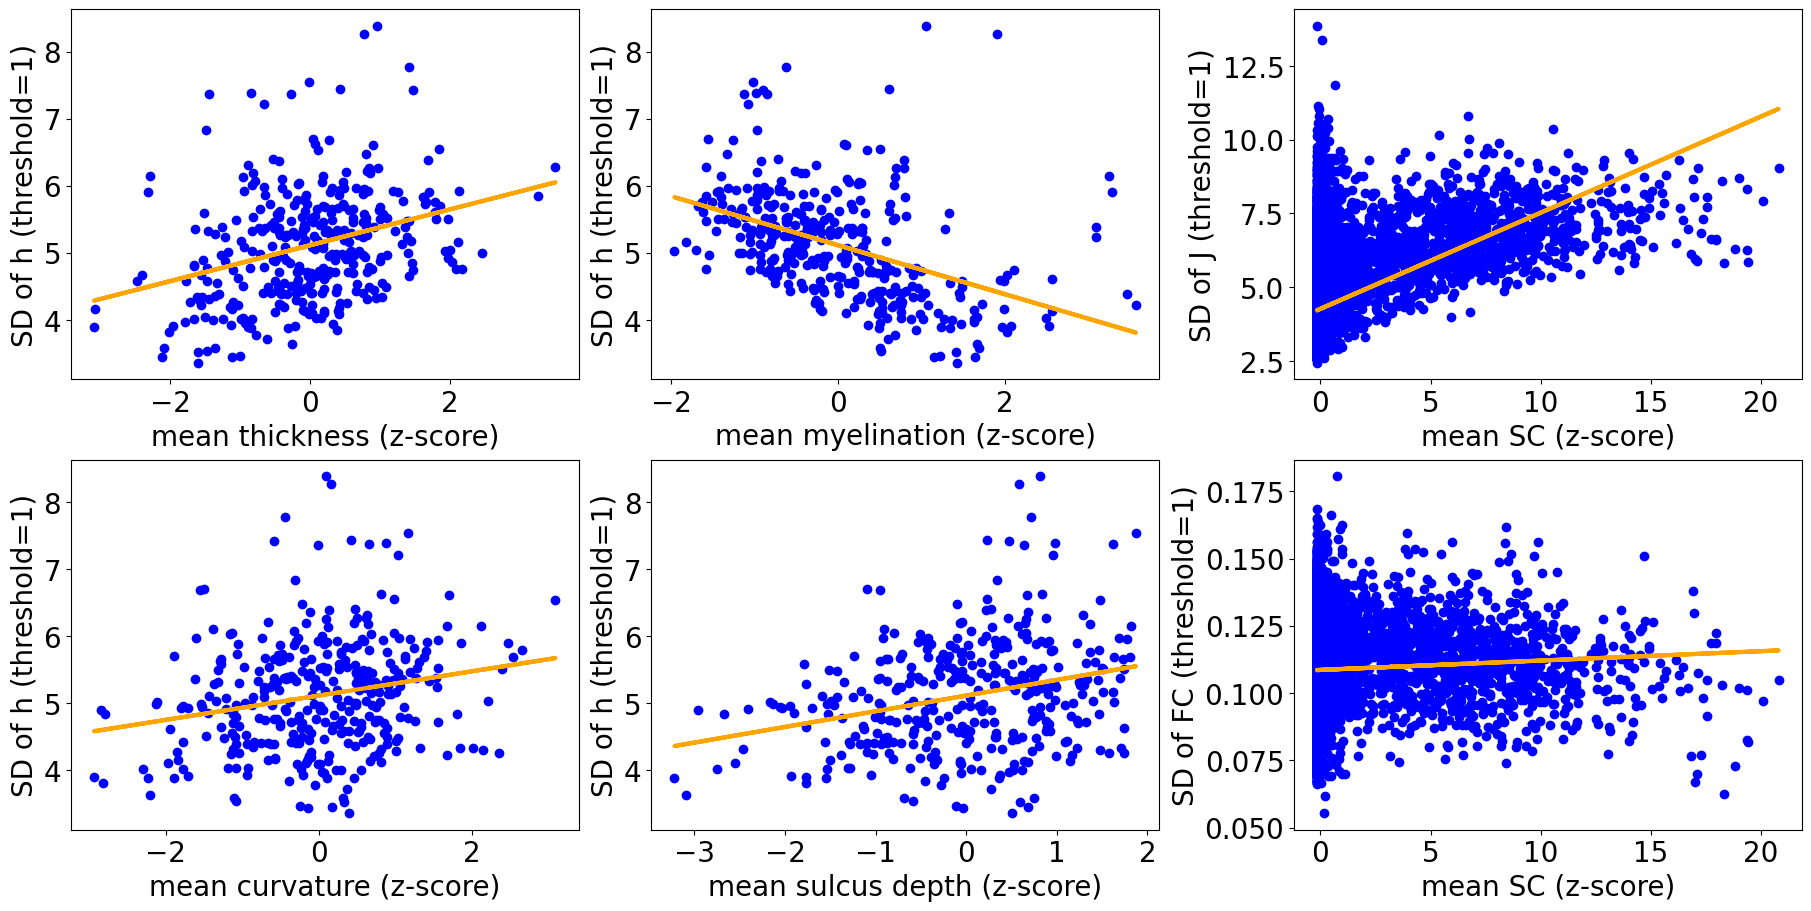

In [85]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(18, 9), layout='constrained' )

for feature_index, feature_name, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1]):
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=mean_node_features[:,feature_index], param=h_std, feature_name=f'mean {feature_name}', param_name=f'SD of h (threshold=1)')

make_scatter_plot_with_regression_line(ax=axs[0,2], feature=mean_sc, param=J_std, feature_name='mean SC', param_name=f'SD of J (threshold=1)')

make_scatter_plot_with_regression_line(ax=axs[1,2], feature=mean_sc, param=fc_std, feature_name='mean SC', param_name=f'SD of FC (threshold=1)')

# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')

# plt.tight_layout()
plt.show()

In [86]:
std_node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False ).std(dim=0)[:,:4]
print( 'SD node features size', std_node_features.size() )
std_sc = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False ).std(dim=0)[:,0]
print( 'SD SC size', std_sc.size() )

SD node features size torch.Size([360, 4])
SD SC size torch.Size([64620])


z(SD of h (threshold=1))=0.355SD of thickness+5.11, R^2=0.186, corr.=0.431, p-value=0
z(SD of h (threshold=1))=0.279SD of myelination+5.11, R^2=0.115, corr.=0.338, p-value=0
z(SD of h (threshold=1))=-0.0477SD of curvature+5.11, R^2=0.00336, corr.=-0.0578, p-value=0.273
z(SD of h (threshold=1))=-0.166SD of sulcus depth+5.11, R^2=0.0409, corr.=-0.202, p-value=0.000111
z(SD of J (threshold=1))=0.403SD of SC+4.27, R^2=0.186, corr.=0.432, p-value=0
z(SD of FC (threshold=1))=0.000986SD of SC+0.109, R^2=0.00594, corr.=0.0771, p-value=0


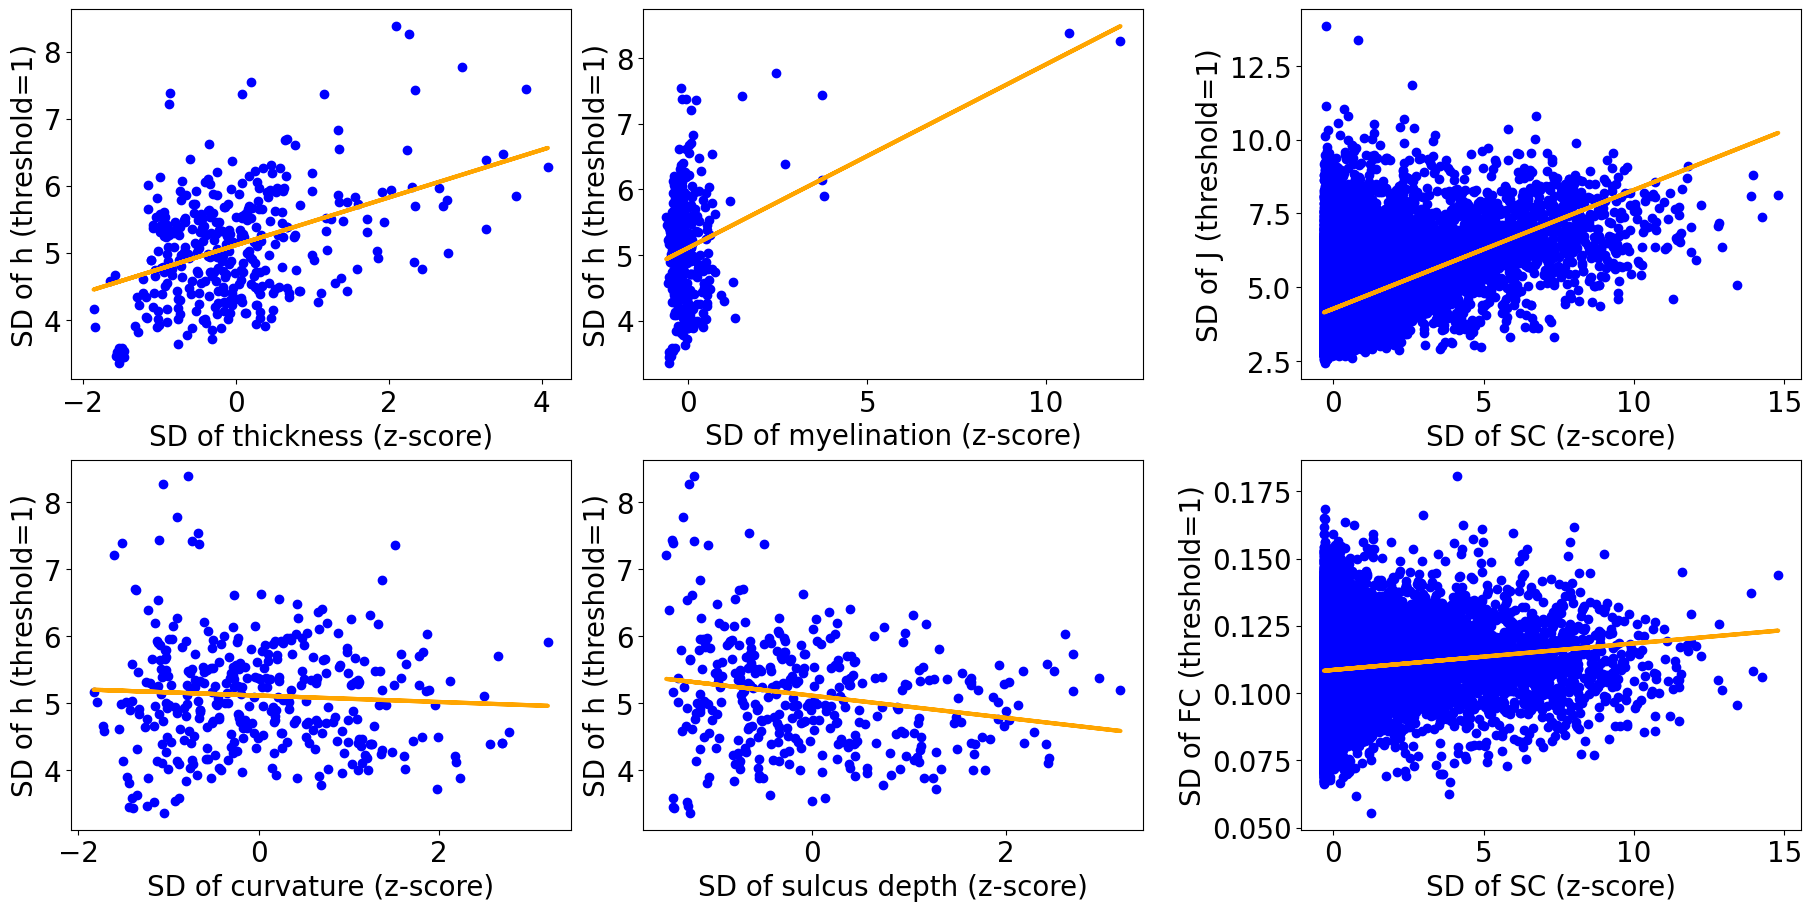

In [87]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(18, 9), layout='constrained' )

for feature_index, feature_name, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1]):
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=std_node_features[:,feature_index], param=h_std, feature_name=f'SD of {feature_name}', param_name=f'SD of h (threshold=1)')

make_scatter_plot_with_regression_line(ax=axs[0,2], feature=std_sc, param=J_std, feature_name='SD of SC', param_name=f'SD of J (threshold=1)')

make_scatter_plot_with_regression_line(ax=axs[1,2], feature=std_sc, param=fc_std, feature_name='SD of SC', param_name=f'SD of FC (threshold=1)')

# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')

# plt.tight_layout()
plt.show()

In [1]:
J_std, J_mean = torch.std_mean(J)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 9), layout='constrained' )
make_scatter_plot_with_regression_line(ax=axs, feature=J_mean, param=J_std, feature_name='mean of J (threshold=1)', param_name=f'SD of J (threshold=1)')

NameError: name 'torch' is not defined

In [10]:
test_series = torch.tensor([0.5, 0.7, 0.1, 0.2, 0.01, 0.9], dtype=float_type, device=device)
print('original order', test_series)
test_sorted, test_indices = test_series.sort(descending=True)
print('descending order', test_sorted)
print('descending order indices', test_indices)
test_range = torch.arange( end=test_series.numel(), dtype=int_type, device=device )[test_indices]
print('indices in matching order', test_range)

original order tensor([0.5000, 0.7000, 0.1000, 0.2000, 0.0100, 0.9000], device='cuda:0')
descending order tensor([0.9000, 0.7000, 0.5000, 0.2000, 0.1000, 0.0100], device='cuda:0')
descending order indices tensor([5, 1, 0, 3, 2, 4], device='cuda:0')
indices in matching order tensor([5, 1, 0, 3, 2, 4], device='cuda:0', dtype=torch.int32)


z(group model h (threshold=1))=1.64group mean myelination+-2.51, R^2=0.0758, corr.=0.275, p-value=0
z(SD of individual h (threshold=1))=-0.365group mean myelination+5.11, R^2=0.197, corr.=-0.442, p-value=0
z(group model J (threshold=1))=2.07group mean SC+1, R^2=0.127, corr.=0.357, p-value=0
z(SD of J (threshold=1))=0.326group mean SC+4.27, R^2=0.122, corr.=0.349, p-value=0


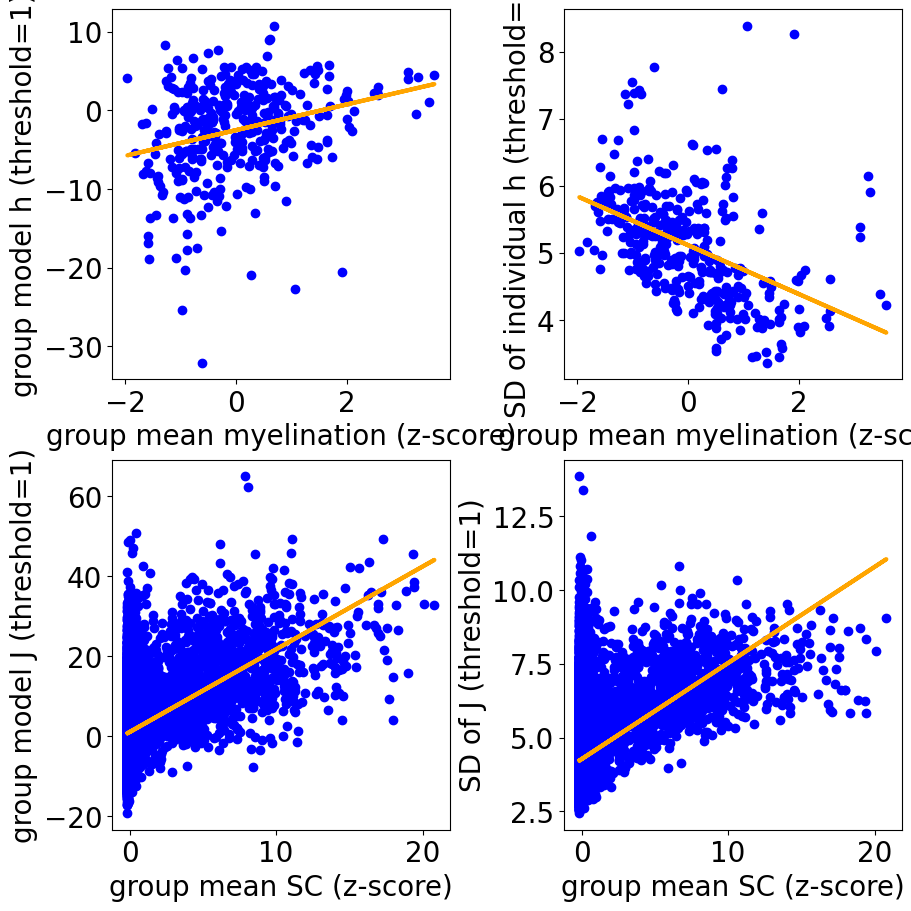

In [75]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(9, 9), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
feature_index = 1
feature_name = 'myelination'
selected_h = h[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[0,0], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=f'group mean {feature_name}', param_name=f'group model h (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line(ax=axs[0,1], feature=mean_node_features[:,feature_index], param=h_std, feature_name=f'group mean {feature_name}', param_name=f'SD of individual h (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line(ax=axs[1,0], feature=mean_sc, param=J[selected_threshold_index,:], feature_name='group mean SC', param_name=f'group model J (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line(ax=axs[1,1], feature=mean_sc, param=J_std, feature_name='group mean SC', param_name=f'SD of J (threshold={selected_threshold:.3g})')

In [76]:
def make_scatter_plot_with_regression_line_no_p(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_std, feature_mean = torch.std_mean(feature)
    feature_z = (feature - feature_mean)/feature_std

    feature_z_and_1 = torch.stack(  ( feature_z, torch.ones_like(feature_z) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_z_and_1, param_col)
    param_pred = torch.matmul(feature_z_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'z({param_name})={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}, corr.={corr:.3g}')
    
    feature_z_np = depytorch(feature_z)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_z_np, param_np, color='blue')
    ax.plot(feature_z_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name} (z-score)')
    ax.set_ylabel(f'{param_name}')

z(group h)=1.64myelination+-2.51, R^2=0.0758, corr.=0.275
z(SD of individual h)=-0.365myelination+5.11, R^2=0.197, corr.=-0.442
z(group J)=2.07SC+1, R^2=0.127, corr.=0.357
z(SD of individual J)=0.326SC+4.27, R^2=0.122, corr.=0.349


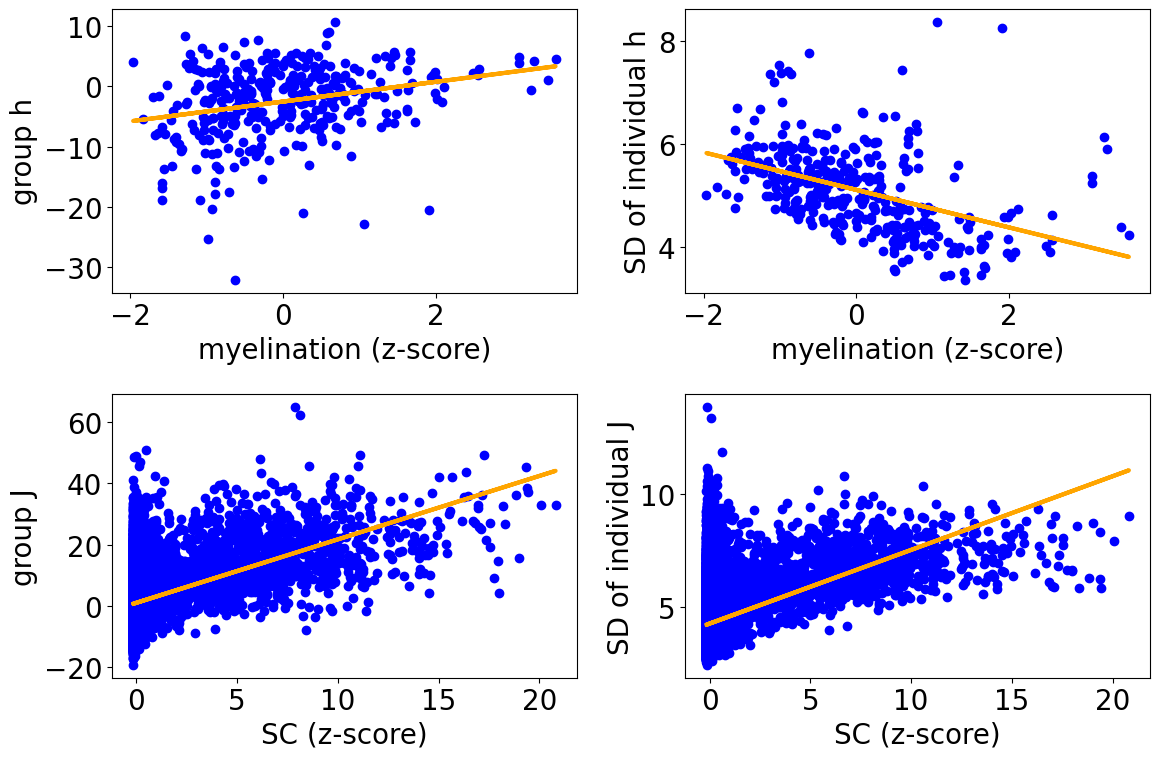

In [96]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 8) )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
feature_index = 1
feature_name = 'myelination'
selected_h = h[selected_threshold_index,:]
make_scatter_plot_with_regression_line_no_p(ax=axs[0,0], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=f'{feature_name}', param_name=f'group h')
make_scatter_plot_with_regression_line_no_p(ax=axs[0,1], feature=mean_node_features[:,feature_index], param=h_std, feature_name=f'{feature_name}', param_name=f'SD of individual h')
make_scatter_plot_with_regression_line_no_p(ax=axs[1,0], feature=mean_sc, param=J[selected_threshold_index,:], feature_name='SC', param_name=f'group J')
make_scatter_plot_with_regression_line_no_p(ax=axs[1,1], feature=mean_sc, param=J_std, feature_name='SC', param_name=f'SD of individual J')
fig.tight_layout()

z(group h)=1.64myelination+-2.51, R^2=0.0758, corr.=0.275
z(SD of individual h)=-0.365myelination+5.11, R^2=0.197, corr.=-0.442
z(group J)=2.07SC+1, R^2=0.127, corr.=0.357
z(SD of individual J)=0.326SC+4.27, R^2=0.122, corr.=0.349


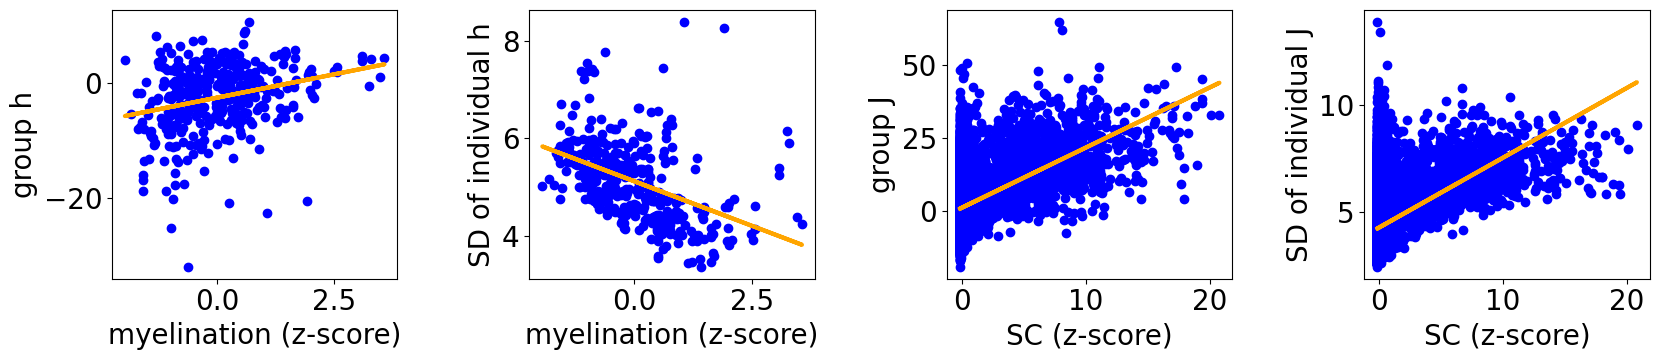

In [101]:
fig, axs = plt.subplots( nrows=1, ncols=4, figsize=(17, 4) )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
feature_index = 1
feature_name = 'myelination'
selected_h = h[selected_threshold_index,:]
make_scatter_plot_with_regression_line_no_p(ax=axs[0], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=f'{feature_name}', param_name=f'group h')
make_scatter_plot_with_regression_line_no_p(ax=axs[1], feature=mean_node_features[:,feature_index], param=h_std, feature_name=f'{feature_name}', param_name=f'SD of individual h')
make_scatter_plot_with_regression_line_no_p(ax=axs[2], feature=mean_sc, param=J[selected_threshold_index,:], feature_name='SC', param_name=f'group J')
make_scatter_plot_with_regression_line_no_p(ax=axs[3], feature=mean_sc, param=J_std, feature_name='SC', param_name=f'SD of individual J')
fig.tight_layout()

In [ ]:
write_node_file(file_name:str, coords:torch.Tensor, values_for_color:torch.Tensor=None, values_for_size:torch.Tensor=None, names:list=None)